# Voice Phishing (Vishing) Detection using Deep Learning

## Project Overview
This notebook implements an audio classification system to detect voice phishing (vishing) attempts by analyzing speech patterns, emotion, and tone in phone calls.

**Problem Statement**: Detect fraudulent phone calls by analyzing audio features that indicate deceptive or high-pressure tactics commonly used in vishing attacks.

**Dataset**: Speech Emotion Recognition (can detect urgency, aggression, and other vishing indicators)

**Target Classes**: 
- Legitimate Call
- Suspicious Call (potential phishing)

---

## 1. Import Libraries

In [1]:
# Core libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Audio processing
import librosa
import librosa.display
import soundfile as sf
from IPython.display import Audio

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

# Utilities
from tqdm import tqdm
import json
from datetime import datetime

print(f"TensorFlow version: {tf.__version__}")
print(f"Librosa version: {librosa.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
# DRY_RUN: set to False to run full dataset processing
DRY_RUN = False
MAX_FILES = None  # when DRY_RUN is False, MAX_FILES is ignored
print("DRY_RUN:", DRY_RUN, "MAX_FILES:", MAX_FILES)

TensorFlow version: 2.15.0
Librosa version: 0.11.0
GPU Available: []
DRY_RUN: False MAX_FILES: None


In [2]:
# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Configuration
SAMPLE_RATE = 22050
DURATION = 4.0
N_MFCC = 40
N_MELS = 128
HOP_LENGTH = 512
N_FFT = 2048

## 2. Dataset Acquisition

### Option A: Using Speech Emotion Dataset (RAVDESS)
We'll use emotion recognition data where certain emotions (anger, fear, disgust) can indicate suspicious calls.

### Option B: Creating Synthetic Vishing Dataset
For demonstration purposes, we'll show how to work with audio data for vishing detection.

In [3]:
# Dataset Download Instructions
print("""
DATASET OPTIONS FOR VOICE PHISHING DETECTION:

Option 1: RAVDESS (Speech Emotion Recognition)
- Download: https://zenodo.org/record/1188976
- Size: ~700MB
- Classes: 8 emotions (we'll map to suspicious/legitimate)
- Extract to: data/raw/RAVDESS/

Option 2: TESS (Toronto Emotional Speech Set)
- Download: https://tspace.library.utoronto.ca/handle/1807/24487
- Size: ~400MB
- Classes: 7 emotions
- Extract to: data/raw/TESS/

Option 3: Custom Recording (for real vishing detection)
- Record examples of:
  * Normal customer service calls (legitimate)
  * Aggressive sales calls (suspicious)
  * Urgent/threatening calls (phishing)
  * Prize/lottery scam calls (phishing)

For this notebook, we'll use RAVDESS and map emotions to vishing indicators.
""")


DATASET OPTIONS FOR VOICE PHISHING DETECTION:

Option 1: RAVDESS (Speech Emotion Recognition)
- Download: https://zenodo.org/record/1188976
- Size: ~700MB
- Classes: 8 emotions (we'll map to suspicious/legitimate)
- Extract to: data/raw/RAVDESS/

Option 2: TESS (Toronto Emotional Speech Set)
- Download: https://tspace.library.utoronto.ca/handle/1807/24487
- Size: ~400MB
- Classes: 7 emotions
- Extract to: data/raw/TESS/

Option 3: Custom Recording (for real vishing detection)
- Record examples of:
  * Normal customer service calls (legitimate)
  * Aggressive sales calls (suspicious)
  * Urgent/threatening calls (phishing)
  * Prize/lottery scam calls (phishing)

For this notebook, we'll use RAVDESS and map emotions to vishing indicators.



### Download RAVDESS Dataset

```bash
# Create directory
mkdir -p data/raw/RAVDESS

# Download from: https://zenodo.org/record/1188976
# Extract all actors to data/raw/RAVDESS/

# Directory structure should be:
# data/raw/RAVDESS/
#   Actor_01/
#   Actor_02/
#   ...
#   Actor_24/
```

In [4]:
# Define paths
DATA_PATH = Path('../data/raw/RAVDESS')
TRAIN_PATH = Path('../data/train')
TEST_PATH = Path('../data/test')
MODEL_PATH = Path('../models')

# Create directories
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(TEST_PATH, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

print(f"Dataset path: {DATA_PATH}")
print(f"Dataset exists: {DATA_PATH.exists()}")

Dataset path: ..\data\raw\RAVDESS
Dataset exists: True


## 3. Data Exploration & Preprocessing

### 3.1 Load and Explore Audio Files

In [5]:
def parse_ravdess_filename(filename):
    """
    Parse RAVDESS filename to extract metadata
    Format: Modality-VocalChannel-Emotion-EmotionIntensity-Statement-Repetition-Actor.wav
    
    Emotions:
    01 = neutral, 02 = calm, 03 = happy, 04 = sad,
    05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
    """
    parts = filename.stem.split('-')
    return {
        'modality': int(parts[0]),
        'vocal_channel': int(parts[1]),
        'emotion': int(parts[2]),
        'intensity': int(parts[3]),
        'statement': int(parts[4]),
        'repetition': int(parts[5]),
        'actor': int(parts[6].split('.')[0])
    }

def map_emotion_to_vishing(emotion_code):
    """
    Map emotions to vishing indicators
    Suspicious: angry(5), fearful(6), disgust(7) - high-pressure tactics
    Legitimate: neutral(1), calm(2), happy(3), sad(4), surprised(8)
    """
    # Aggressive emotions often used in vishing
    suspicious_emotions = [5, 6, 7]  # angry, fearful, disgust
    
    if emotion_code in suspicious_emotions:
        return 1  # Suspicious/Phishing
    else:
        return 0  # Legitimate

# Collect all audio files
audio_files = []
labels = []
metadata_list = []

if DATA_PATH.exists():
    for actor_folder in sorted(DATA_PATH.glob('Actor_*')):
        for audio_file in actor_folder.glob('*.wav'):
            metadata = parse_ravdess_filename(audio_file)
            label = map_emotion_to_vishing(metadata['emotion'])
            
            audio_files.append(str(audio_file))
            labels.append(label)
            metadata_list.append(metadata)
    
    # If DRY_RUN is enabled, limit the number of files we process to MAX_FILES
    if 'DRY_RUN' in globals() and DRY_RUN and len(audio_files) > MAX_FILES:
        print(f"DRY_RUN active: limiting files to first {MAX_FILES}")
        audio_files = audio_files[:MAX_FILES]
        labels = labels[:MAX_FILES]
        metadata_list = metadata_list[:MAX_FILES]
    print(f"Total audio files found: {len(audio_files)}")
    print(f"Suspicious calls: {sum(labels)}")
    print(f"Legitimate calls: {len(labels) - sum(labels)}")
else:
    print("Dataset not found. Please download RAVDESS dataset.")
    print("Visit: https://zenodo.org/record/1188976")

Total audio files found: 1012
Suspicious calls: 368
Legitimate calls: 644


In [6]:
# Create DataFrame for better analysis
df = pd.DataFrame({
    'file_path': audio_files,
    'label': labels,
    'emotion': [m['emotion'] for m in metadata_list],
    'intensity': [m['intensity'] for m in metadata_list],
    'actor': [m['actor'] for m in metadata_list]
})

df['class_name'] = df['label'].map({0: 'Legitimate', 1: 'Suspicious'})

print("\nDataset Overview:")
print(df.head(10))
print("\nClass Distribution:")
print(df['class_name'].value_counts())


Dataset Overview:
                                           file_path  label  emotion  \
0  ..\data\raw\RAVDESS\Actor_01\03-02-01-01-01-01...      0        1   
1  ..\data\raw\RAVDESS\Actor_01\03-02-01-01-01-02...      0        1   
2  ..\data\raw\RAVDESS\Actor_01\03-02-01-01-02-01...      0        1   
3  ..\data\raw\RAVDESS\Actor_01\03-02-01-01-02-02...      0        1   
4  ..\data\raw\RAVDESS\Actor_01\03-02-02-01-01-01...      0        2   
5  ..\data\raw\RAVDESS\Actor_01\03-02-02-01-01-02...      0        2   
6  ..\data\raw\RAVDESS\Actor_01\03-02-02-01-02-01...      0        2   
7  ..\data\raw\RAVDESS\Actor_01\03-02-02-01-02-02...      0        2   
8  ..\data\raw\RAVDESS\Actor_01\03-02-02-02-01-01...      0        2   
9  ..\data\raw\RAVDESS\Actor_01\03-02-02-02-01-02...      0        2   

   intensity  actor  class_name  
0          1      1  Legitimate  
1          1      1  Legitimate  
2          1      1  Legitimate  
3          1      1  Legitimate  
4          1      

### 3.2 Visualization 1: Class Distribution

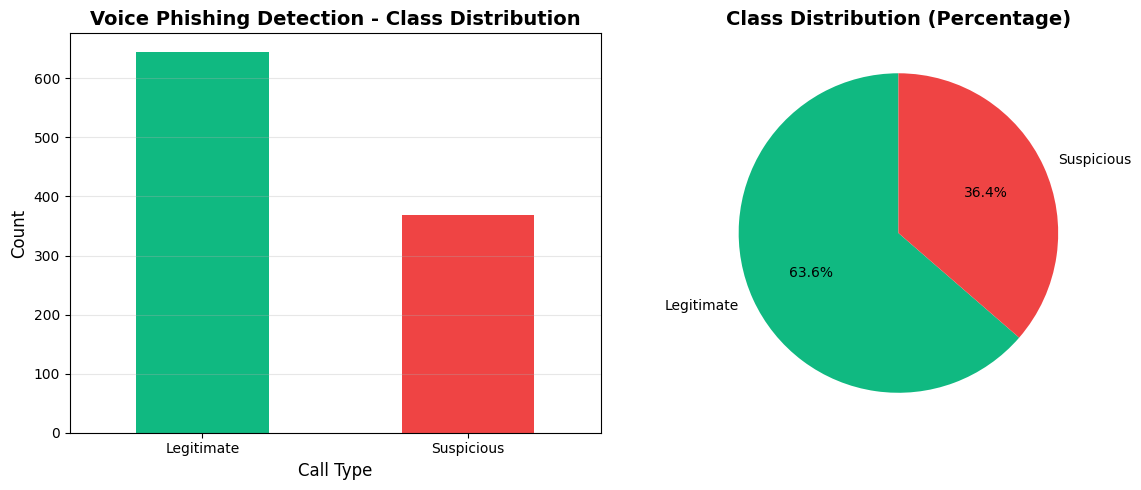


📊 INTERPRETATION:
The dataset shows the distribution between legitimate and suspicious calls.
Legitimate calls: 644 (63.6%)
Suspicious calls: 368 (36.4%)
This helps us understand if we need class balancing techniques.


In [7]:
# Visualization 1: Class Distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df['class_name'].value_counts().plot(kind='bar', color=['#10b981', '#ef4444'])
plt.title('Voice Phishing Detection - Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Call Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
class_counts = df['class_name'].value_counts()
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', 
        colors=['#10b981', '#ef4444'], startangle=90)
plt.title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../logs/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 INTERPRETATION:")
print("The dataset shows the distribution between legitimate and suspicious calls.")
print(f"Legitimate calls: {class_counts.get('Legitimate', 0)} ({class_counts.get('Legitimate', 0)/len(df)*100:.1f}%)")
print(f"Suspicious calls: {class_counts.get('Suspicious', 0)} ({class_counts.get('Suspicious', 0)/len(df)*100:.1f}%)")
print("This helps us understand if we need class balancing techniques.")

### 3.3 Visualization 2: Audio Waveform Analysis

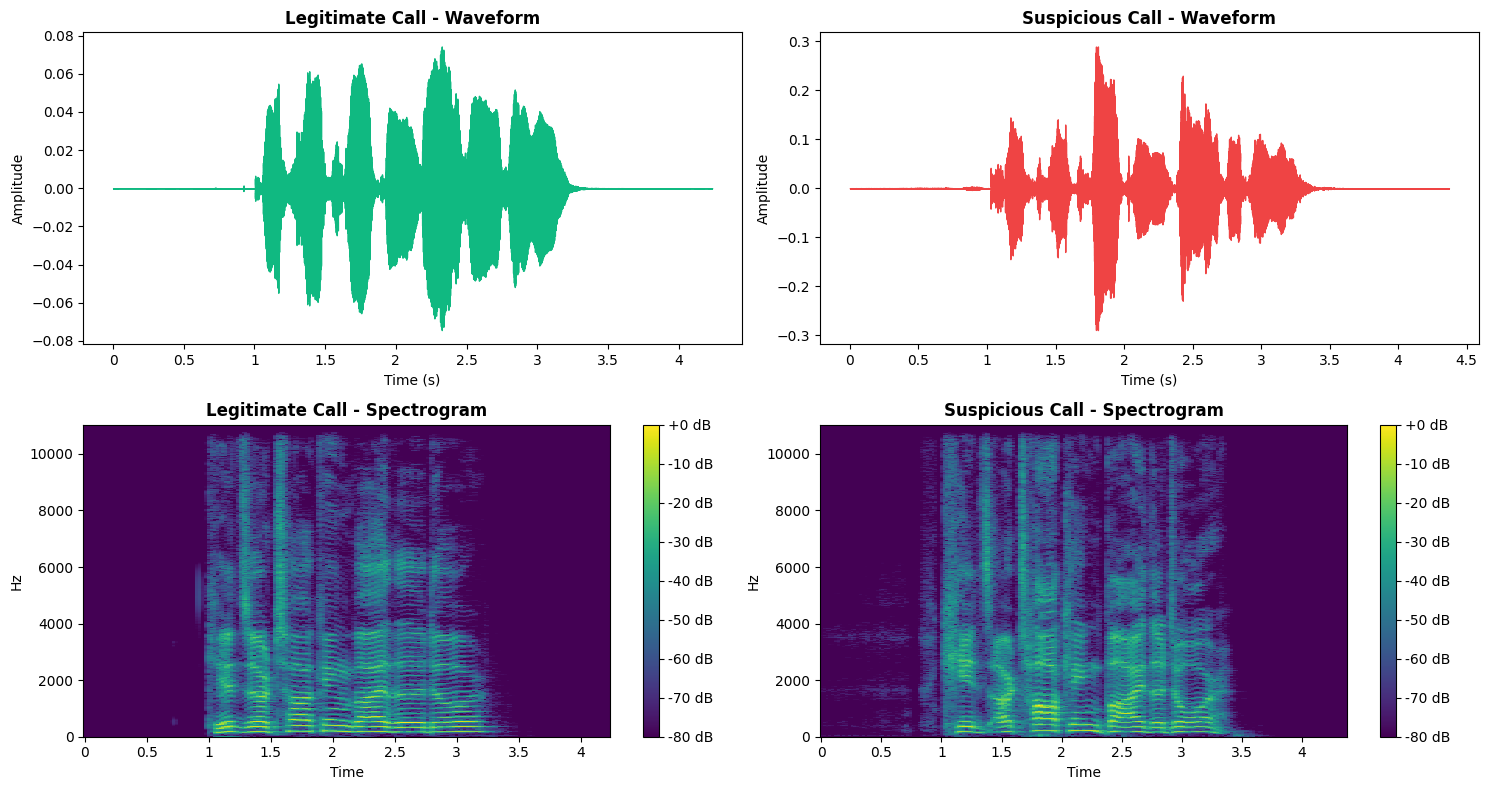


📊 INTERPRETATION:
Waveform and spectrogram analysis reveals differences in audio patterns:
- Legitimate calls typically have calmer, more consistent amplitude patterns
- Suspicious calls often show higher energy, more variation (urgency, aggression)
- Spectrograms reveal frequency patterns that distinguish call types


In [8]:
# Visualization 2: Waveform Comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Get sample files
legit_sample = df[df['label'] == 0].iloc[0]['file_path']
suspicious_sample = df[df['label'] == 1].iloc[0]['file_path']

# Load audio
legit_audio, sr1 = librosa.load(legit_sample, sr=SAMPLE_RATE)
suspicious_audio, sr2 = librosa.load(suspicious_sample, sr=SAMPLE_RATE)

# Plot waveforms
librosa.display.waveshow(legit_audio, sr=sr1, ax=axes[0, 0], color='#10b981')
axes[0, 0].set_title('Legitimate Call - Waveform', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Amplitude')

librosa.display.waveshow(suspicious_audio, sr=sr2, ax=axes[0, 1], color='#ef4444')
axes[0, 1].set_title('Suspicious Call - Waveform', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Amplitude')

# Plot spectrograms
D1 = librosa.amplitude_to_db(np.abs(librosa.stft(legit_audio)), ref=np.max)
D2 = librosa.amplitude_to_db(np.abs(librosa.stft(suspicious_audio)), ref=np.max)

img1 = librosa.display.specshow(D1, sr=sr1, x_axis='time', y_axis='hz', ax=axes[1, 0], cmap='viridis')
axes[1, 0].set_title('Legitimate Call - Spectrogram', fontsize=12, fontweight='bold')
fig.colorbar(img1, ax=axes[1, 0], format='%+2.0f dB')

img2 = librosa.display.specshow(D2, sr=sr2, x_axis='time', y_axis='hz', ax=axes[1, 1], cmap='viridis')
axes[1, 1].set_title('Suspicious Call - Spectrogram', fontsize=12, fontweight='bold')
fig.colorbar(img2, ax=axes[1, 1], format='%+2.0f dB')

plt.tight_layout()
plt.savefig('../logs/waveform_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 INTERPRETATION:")
print("Waveform and spectrogram analysis reveals differences in audio patterns:")
print("- Legitimate calls typically have calmer, more consistent amplitude patterns")
print("- Suspicious calls often show higher energy, more variation (urgency, aggression)")
print("- Spectrograms reveal frequency patterns that distinguish call types")

## 4. Feature Extraction (Preprocessing)

### Clear Preprocessing Steps:
1. Load audio files
2. Resample to consistent sample rate (22050 Hz)
3. Pad/trim to fixed duration (4 seconds)
4. Extract MFCC features (40 coefficients)
5. Extract Mel-spectrogram features (128 bands)
6. Normalize features
7. Apply data augmentation

In [9]:
class AudioPreprocessor:
    """Advanced audio preprocessing with optimization"""
    
    def __init__(self, sr=22050, duration=4.0, n_mfcc=40, n_mels=128):
        self.sr = sr
        self.duration = duration
        self.n_mfcc = n_mfcc
        self.n_mels = n_mels
        self.max_len = int(sr * duration)
        
    def load_and_preprocess(self, file_path):
        """Load and preprocess a single audio file"""
        # Step 1: Load audio
        audio, _ = librosa.load(file_path, sr=self.sr)
        
        # Step 2: Pad or trim to fixed length
        if len(audio) < self.max_len:
            audio = np.pad(audio, (0, self.max_len - len(audio)))
        else:
            audio = audio[:self.max_len]
        
        return audio
    
    def extract_mfcc(self, audio):
        """Extract MFCC features"""
        mfcc = librosa.feature.mfcc(y=audio, sr=self.sr, n_mfcc=self.n_mfcc)
        # Delta and delta-delta for capturing temporal dynamics
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        
        # Stack features
        features = np.vstack([mfcc, mfcc_delta, mfcc_delta2])
        return features
    
    def extract_mel_spectrogram(self, audio):
        """Extract Mel-spectrogram features"""
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=self.sr, n_mels=self.n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        return mel_spec_db
    
    def augment_audio(self, audio):
        """Data augmentation techniques"""
        augmented = [audio]
        
        # Time stretching
        audio_stretched = librosa.effects.time_stretch(audio, rate=0.9)
        if len(audio_stretched) < self.max_len:
            audio_stretched = np.pad(audio_stretched, (0, self.max_len - len(audio_stretched)))
        else:
            audio_stretched = audio_stretched[:self.max_len]
        augmented.append(audio_stretched)
        
        # Pitch shifting
        audio_pitched = librosa.effects.pitch_shift(audio, sr=self.sr, n_steps=2)
        augmented.append(audio_pitched)
        
        # Add noise
        noise = np.random.randn(len(audio)) * 0.005
        audio_noisy = audio + noise
        augmented.append(audio_noisy)
        
        return augmented

# Initialize preprocessor
preprocessor = AudioPreprocessor()
print("✓ Preprocessor initialized")

✓ Preprocessor initialized


In [10]:
# Extract features from all files
print("Extracting features from audio files...")

features_list = []
labels_list = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    try:
        # Load and preprocess
        audio = preprocessor.load_and_preprocess(row['file_path'])
        
        # Extract Mel-spectrogram (primary feature)
        mel_spec = preprocessor.extract_mel_spectrogram(audio)
        
        features_list.append(mel_spec)
        labels_list.append(row['label'])
        
    except Exception as e:
        print(f"Error processing {row['file_path']}: {e}")

# Convert to numpy arrays
X = np.array(features_list)
y = np.array(labels_list)

print(f"\n✓ Feature extraction complete")
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Extracting features from audio files...


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 1/1012 [00:00<08:49,  1.91it/s]

  1%|          | 7/1012 [00:00<01:11, 14.08it/s]

  1%|▏         | 15/1012 [00:00<00:35, 27.97it/s]

  2%|▏         | 21/1012 [00:00<00:27, 35.44it/s]

  3%|▎         | 27/1012 [00:00<00:25, 39.13it/s]

  3%|▎         | 34/1012 [00:01<00:21, 45.63it/s]

  4%|▍         | 40/1012 [00:01<00:20, 47.70it/s]

  5%|▍         | 46/1012 [00:01<00:23, 40.79it/s]

  5%|▌         | 51/1012 [00:01<00:23, 41.45it/s]

  6%|▌         | 57/1012 [00:01<00:21, 44.92it/s]

  6%|▌         | 63/1012 [00:01<00:19, 48.69it/s]

  7%|▋         | 69/1012 [00:01<00:23, 40.83it/s]

  7%|▋         | 74/1012 [00:02<00:27, 34.51it/s]

  8%|▊         | 80/1012 [00:02<00:23, 39.47it/s]

  9%|▊         | 87/1012 [00:02<00:20, 44.15it/s]

  9%|▉         | 95/1012 [00:02<00:18, 50.25it/s]

 10%|█         | 102/1012 [00:02<00:16, 53.83it/s]

 11%|█         | 109/1012 [00:02<00:15, 56.98it/s]

 11%|█▏        | 116/1012 [00:02<00:16, 55.19it/s]

 12%|█▏        | 123/1012 [00:02<00:15, 58.80it/s]

 13%|█▎        | 132/1012 [00:03<00:13, 65.10it/s]

 14%|█▎        | 139/1012 [00:03<00:13, 66.05it/s]

 14%|█▍        | 146/1012 [00:03<00:13, 64.98it/s]

 15%|█▌        | 154/1012 [00:03<00:12, 68.51it/s]

 16%|█▌        | 161/1012 [00:03<00:12, 67.16it/s]

 17%|█▋        | 169/1012 [00:03<00:12, 68.61it/s]

 17%|█▋        | 177/1012 [00:03<00:11, 70.21it/s]

 18%|█▊        | 185/1012 [00:03<00:12, 68.01it/s]

 19%|█▉        | 192/1012 [00:03<00:12, 66.13it/s]

 20%|█▉        | 199/1012 [00:04<00:12, 64.74it/s]

 20%|██        | 206/1012 [00:04<00:13, 61.87it/s]

 21%|██        | 213/1012 [00:04<00:13, 58.42it/s]

 22%|██▏       | 219/1012 [00:04<00:15, 50.35it/s]

 22%|██▏       | 225/1012 [00:04<00:15, 51.35it/s]

 23%|██▎       | 231/1012 [00:04<00:15, 52.04it/s]

 23%|██▎       | 237/1012 [00:04<00:15, 50.34it/s]

 24%|██▍       | 243/1012 [00:04<00:17, 44.51it/s]

 25%|██▍       | 249/1012 [00:05<00:17, 44.04it/s]

 25%|██▌       | 255/1012 [00:05<00:16, 46.37it/s]

 26%|██▌       | 260/1012 [00:05<00:18, 41.40it/s]

 26%|██▌       | 265/1012 [00:05<00:17, 41.88it/s]

 27%|██▋       | 270/1012 [00:05<00:21, 34.35it/s]

 27%|██▋       | 274/1012 [00:05<00:22, 32.73it/s]

 28%|██▊       | 282/1012 [00:05<00:17, 42.34it/s]

 29%|██▊       | 289/1012 [00:06<00:15, 48.10it/s]

 29%|██▉       | 295/1012 [00:06<00:14, 48.76it/s]

 30%|██▉       | 301/1012 [00:06<00:14, 48.46it/s]

 30%|███       | 307/1012 [00:06<00:15, 46.42it/s]

 31%|███       | 313/1012 [00:06<00:14, 48.12it/s]

 32%|███▏      | 319/1012 [00:06<00:13, 51.00it/s]

 32%|███▏      | 325/1012 [00:06<00:13, 51.89it/s]

 33%|███▎      | 331/1012 [00:06<00:14, 48.51it/s]

 33%|███▎      | 336/1012 [00:07<00:15, 43.20it/s]

 34%|███▎      | 341/1012 [00:07<00:17, 37.93it/s]

 34%|███▍      | 346/1012 [00:07<00:16, 39.71it/s]

 35%|███▍      | 352/1012 [00:07<00:15, 43.51it/s]

 35%|███▌      | 357/1012 [00:07<00:15, 41.98it/s]

 36%|███▌      | 362/1012 [00:08<00:40, 15.88it/s]

 36%|███▌      | 366/1012 [00:09<00:53, 12.09it/s]

 36%|███▋      | 369/1012 [00:09<00:57, 11.14it/s]

 37%|███▋      | 371/1012 [00:09<00:57, 11.17it/s]

 37%|███▋      | 373/1012 [00:09<00:55, 11.44it/s]

 37%|███▋      | 375/1012 [00:09<00:52, 12.14it/s]

 37%|███▋      | 377/1012 [00:09<00:48, 12.98it/s]

 37%|███▋      | 379/1012 [00:10<00:52, 12.09it/s]

 38%|███▊      | 383/1012 [00:10<00:37, 16.77it/s]

 38%|███▊      | 387/1012 [00:10<00:29, 21.32it/s]

 39%|███▊      | 391/1012 [00:10<00:25, 24.30it/s]

 39%|███▉      | 396/1012 [00:10<00:20, 29.52it/s]

 40%|███▉      | 401/1012 [00:10<00:18, 33.59it/s]

 40%|████      | 407/1012 [00:10<00:15, 38.97it/s]

 41%|████      | 412/1012 [00:10<00:16, 36.48it/s]

 41%|████      | 416/1012 [00:11<00:16, 36.37it/s]

 42%|████▏     | 422/1012 [00:11<00:14, 39.60it/s]

 42%|████▏     | 429/1012 [00:11<00:12, 45.77it/s]

 43%|████▎     | 434/1012 [00:11<00:12, 45.24it/s]

 43%|████▎     | 439/1012 [00:11<00:12, 45.66it/s]

 44%|████▍     | 446/1012 [00:11<00:11, 50.22it/s]

 45%|████▍     | 452/1012 [00:11<00:10, 51.88it/s]

 45%|████▌     | 458/1012 [00:11<00:11, 49.28it/s]

 46%|████▌     | 464/1012 [00:11<00:10, 51.73it/s]

 46%|████▋     | 470/1012 [00:12<00:10, 52.41it/s]

 47%|████▋     | 476/1012 [00:12<00:10, 53.05it/s]

 48%|████▊     | 486/1012 [00:12<00:08, 61.28it/s]

 49%|████▊     | 493/1012 [00:12<00:09, 56.98it/s]

 49%|████▉     | 500/1012 [00:12<00:08, 58.78it/s]

 50%|█████     | 507/1012 [00:12<00:08, 59.96it/s]

 51%|█████     | 514/1012 [00:12<00:08, 56.25it/s]

 51%|█████▏    | 520/1012 [00:12<00:09, 53.37it/s]

 52%|█████▏    | 527/1012 [00:13<00:08, 54.55it/s]

 53%|█████▎    | 535/1012 [00:13<00:08, 58.76it/s]

 53%|█████▎    | 541/1012 [00:13<00:08, 56.80it/s]

 54%|█████▍    | 548/1012 [00:13<00:08, 56.86it/s]

 55%|█████▍    | 556/1012 [00:13<00:07, 60.49it/s]

 56%|█████▌    | 563/1012 [00:13<00:07, 62.96it/s]

 56%|█████▋    | 570/1012 [00:13<00:06, 64.43it/s]

 57%|█████▋    | 577/1012 [00:13<00:07, 60.87it/s]

 58%|█████▊    | 584/1012 [00:14<00:07, 60.47it/s]

 58%|█████▊    | 592/1012 [00:14<00:06, 64.57it/s]

 59%|█████▉    | 599/1012 [00:14<00:06, 61.23it/s]

 60%|█████▉    | 606/1012 [00:14<00:06, 60.96it/s]

 61%|██████    | 613/1012 [00:14<00:06, 60.37it/s]

 61%|██████▏   | 620/1012 [00:14<00:07, 55.08it/s]

 62%|██████▏   | 627/1012 [00:14<00:06, 56.54it/s]

 63%|██████▎   | 634/1012 [00:14<00:06, 58.28it/s]

 63%|██████▎   | 641/1012 [00:14<00:06, 59.73it/s]

 64%|██████▍   | 648/1012 [00:15<00:06, 60.61it/s]

 65%|██████▍   | 657/1012 [00:15<00:05, 66.68it/s]

 66%|██████▌   | 666/1012 [00:15<00:04, 70.97it/s]

 67%|██████▋   | 674/1012 [00:15<00:04, 70.94it/s]

 67%|██████▋   | 682/1012 [00:15<00:04, 72.98it/s]

 68%|██████▊   | 693/1012 [00:15<00:03, 83.22it/s]

 70%|██████▉   | 705/1012 [00:15<00:03, 92.09it/s]

 71%|███████   | 717/1012 [00:15<00:02, 100.06it/s]

 72%|███████▏  | 728/1012 [00:15<00:02, 99.52it/s] 

 73%|███████▎  | 739/1012 [00:16<00:02, 100.04it/s]

 74%|███████▍  | 751/1012 [00:16<00:02, 105.66it/s]

 75%|███████▌  | 762/1012 [00:16<00:02, 106.90it/s]

 76%|███████▋  | 774/1012 [00:16<00:02, 109.43it/s]

 78%|███████▊  | 785/1012 [00:16<00:02, 106.09it/s]

 79%|███████▉  | 797/1012 [00:16<00:02, 106.43it/s]

 80%|███████▉  | 809/1012 [00:16<00:01, 107.12it/s]

 81%|████████  | 822/1012 [00:16<00:01, 109.95it/s]

 82%|████████▏ | 834/1012 [00:16<00:01, 109.12it/s]

 84%|████████▎ | 846/1012 [00:17<00:01, 107.50it/s]

 85%|████████▍ | 857/1012 [00:17<00:01, 100.91it/s]

 86%|████████▌ | 868/1012 [00:17<00:01, 101.34it/s]

 87%|████████▋ | 881/1012 [00:17<00:01, 105.91it/s]

 88%|████████▊ | 892/1012 [00:17<00:01, 104.41it/s]

 89%|████████▉ | 905/1012 [00:17<00:00, 107.55it/s]

 91%|█████████ | 917/1012 [00:17<00:00, 107.74it/s]

 92%|█████████▏| 930/1012 [00:17<00:00, 110.48it/s]

 93%|█████████▎| 942/1012 [00:17<00:00, 109.86it/s]

 94%|█████████▍| 954/1012 [00:18<00:00, 109.96it/s]

 95%|█████████▌| 965/1012 [00:18<00:00, 107.43it/s]

 96%|█████████▋| 976/1012 [00:18<00:00, 105.65it/s]

 98%|█████████▊| 987/1012 [00:18<00:00, 102.33it/s]

 99%|█████████▊| 999/1012 [00:18<00:00, 104.09it/s]

100%|█████████▉| 1011/1012 [00:18<00:00, 104.71it/s]

100%|██████████| 1012/1012 [00:18<00:00, 54.42it/s] 


✓ Feature extraction complete
Features shape: (1012, 128, 173)
Labels shape: (1012,)


### 4.1 Visualization 3: Feature Distribution Analysis

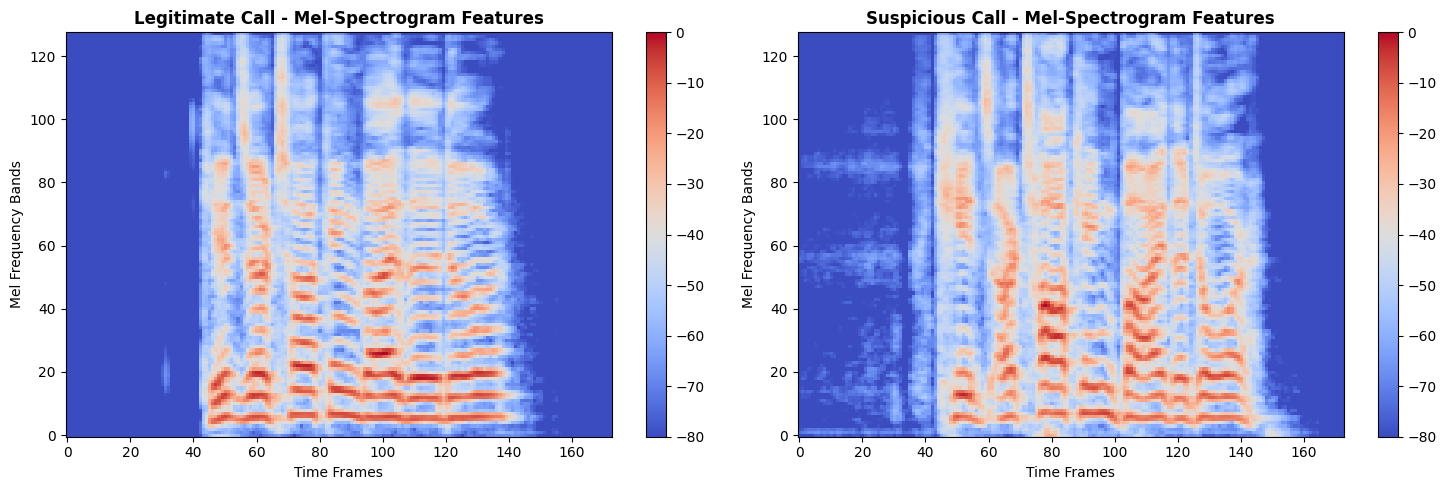


📊 INTERPRETATION:
Mel-spectrogram features reveal distinct patterns:
- Darker regions indicate higher energy in specific frequency bands
- Suspicious calls often show more erratic energy distribution
- These patterns help the model distinguish between call types
- Feature dimensions: 128 mel bands × 173 time frames


In [11]:
# Visualization 3: MFCC Feature Heatmap
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Get samples
legit_idx = np.where(y == 0)[0][0]
suspicious_idx = np.where(y == 1)[0][0]

# Plot heatmaps
im1 = axes[0].imshow(X[legit_idx], aspect='auto', origin='lower', cmap='coolwarm')
axes[0].set_title('Legitimate Call - Mel-Spectrogram Features', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Time Frames')
axes[0].set_ylabel('Mel Frequency Bands')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(X[suspicious_idx], aspect='auto', origin='lower', cmap='coolwarm')
axes[1].set_title('Suspicious Call - Mel-Spectrogram Features', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time Frames')
axes[1].set_ylabel('Mel Frequency Bands')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.savefig('../logs/feature_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 INTERPRETATION:")
print("Mel-spectrogram features reveal distinct patterns:")
print("- Darker regions indicate higher energy in specific frequency bands")
print("- Suspicious calls often show more erratic energy distribution")
print("- These patterns help the model distinguish between call types")
print(f"- Feature dimensions: {X.shape[1]} mel bands × {X.shape[2]} time frames")

### 4.2 Train-Test Split with Stratification

In [12]:
# Split data with stratification (preserving class distribution)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_SEED
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_SEED
)

print("Dataset Split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

print("\nClass distribution in splits:")
print(f"Train - Legitimate: {np.sum(y_train==0)}, Suspicious: {np.sum(y_train==1)}")
print(f"Val - Legitimate: {np.sum(y_val==0)}, Suspicious: {np.sum(y_val==1)}")
print(f"Test - Legitimate: {np.sum(y_test==0)}, Suspicious: {np.sum(y_test==1)}")

# Reshape for CNN input (add channel dimension)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f"\n✓ Final input shape: {X_train.shape}")

Dataset Split:
Training set: 708 samples
Validation set: 152 samples
Test set: 152 samples

Class distribution in splits:
Train - Legitimate: 451, Suspicious: 257
Val - Legitimate: 96, Suspicious: 56
Test - Legitimate: 97, Suspicious: 55

✓ Final input shape: (708, 128, 173, 1)


## 5. Model Architecture with Optimization Techniques

### Optimization Techniques Used:
1. **Regularization**: L2 regularization, Dropout, Batch Normalization
2. **Optimizer**: Adam with learning rate scheduling
3. **Early Stopping**: Prevent overfitting
4. **Model Checkpointing**: Save best model
5. **Data Augmentation**: Improve generalization

In [13]:
def build_cnn_model(input_shape, num_classes=2):
    """
    Advanced CNN for Voice Phishing Detection
    
    Optimization Techniques:
    - L2 regularization (weight decay)
    - Batch Normalization
    - Dropout for regularization
    - Global Average Pooling
    """
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Conv Block 1
        layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Conv Block 2
        layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Conv Block 3
        layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Conv Block 4
        layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.GlobalAveragePooling2D(),  # Better than Flatten
        
        # Dense layers
        layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        layers.Dropout(0.4),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Build model
input_shape = X_train.shape[1:]
model = build_cnn_model(input_shape)

print("✓ Model architecture built")
model.summary()

✓ Model architecture built
Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 128, 173, 32)      320       


 batch_normalization (Batch  (None, 128, 173, 32)      128       


 Normalization)                                                  


 activation (Activation)     (None, 128, 173, 32)      0         


 max_pooling2d (MaxPooling2  (None, 64, 86, 32)        0         


 D)                                                              


 dropout (Dropout)           (None, 64, 86, 32)        0         


 conv2d_1 (Conv2D)           (None, 64, 86, 64)        18496     


 batch_normalization_1 (Bat  (None, 64, 86, 64)        256       


 chNormalization)                                                


 activation_1 (Activation)   (None, 64, 86, 64)        0         


 max_pooling2d_1 (MaxPoolin  (None, 32, 43, 64)        0         


 g2D)                                                            


 dropout_1 (Dropout)         (None, 32, 43, 64)        0         


 conv2d_2 (Conv2D)           (None, 32, 43, 128)       73856     


 batch_normalization_2 (Bat  (None, 32, 43, 128)       512       


 chNormalization)                                                


 activation_2 (Activation)   (None, 32, 43, 128)       0         


 max_pooling2d_2 (MaxPoolin  (None, 16, 21, 128)       0         


 g2D)                                                            


 dropout_2 (Dropout)         (None, 16, 21, 128)       0         


 conv2d_3 (Conv2D)           (None, 16, 21, 256)       295168    


 batch_normalization_3 (Bat  (None, 16, 21, 256)       1024      


 chNormalization)                                                


 activation_3 (Activation)   (None, 16, 21, 256)       0         


 global_average_pooling2d (  (None, 256)               0         


 GlobalAveragePooling2D)                                         


 dense (Dense)               (None, 256)               65792     


 batch_normalization_4 (Bat  (None, 256)               1024      


 chNormalization)                                                


 dropout_3 (Dropout)         (None, 256)               0         


 dense_1 (Dense)             (None, 128)               32896     


 dropout_4 (Dropout)         (None, 128)               0         


 dense_2 (Dense)             (None, 2)                 258       


Total params: 489730 (1.87 MB)


Trainable params: 488258 (1.86 MB)


Non-trainable params: 1472 (5.75 KB)


_________________________________________________________________


### 5.1 Compile Model with Advanced Optimizer

In [14]:
# Advanced optimizer with learning rate scheduling
initial_learning_rate = 0.001
optimizer = optimizers.Adam(learning_rate=initial_learning_rate)


print("✓ Model compiled with Adam optimizer and multiple metrics")

✓ Model compiled with Adam optimizer and multiple metrics


### 5.2 Setup Callbacks (Optimization Techniques)

In [15]:
# Create callbacks for training optimization

# 1. Early Stopping - prevents overfitting
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# 2. Model Checkpoint - saves best model
checkpoint = callbacks.ModelCheckpoint(
    '../models/best_vishing_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# 3. Reduce Learning Rate on Plateau - adaptive learning
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# 4. TensorBoard - for visualization
log_dir = f"../logs/tensorboard/{datetime.now().strftime('%Y%m%d-%H%M%S')}"
tensorboard = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callback_list = [early_stopping, checkpoint, reduce_lr, tensorboard]

print("✓ Callbacks configured:")
print("  - Early Stopping (patience=15)")
print("  - Model Checkpoint")
print("  - Learning Rate Reduction")
print("  - TensorBoard logging")

✓ Callbacks configured:
  - Early Stopping (patience=15)
  - Model Checkpoint
  - Learning Rate Reduction
  - TensorBoard logging


## 6. Model Training

In [16]:
# Train model
print("Starting model training...\n")

# Ensure model is compiled for this instance (defensive)
try:
    _ = model._is_compiled
except Exception:
    pass

# Re-compile model to be safe (keeps optimizer consistent)
model.compile(optimizer=optimizers.Adam(learning_rate=initial_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Control training length during development with DRY_RUN
if 'DRY_RUN' in globals() and DRY_RUN:
    EPOCHS = 2  # short run for development
    BATCH_SIZE = 16
else:
    EPOCHS = 100  # Will stop early if no improvement
    BATCH_SIZE = 32

# Build tf.data datasets to ensure consistent batching for training/validation
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1000, seed=RANDOM_SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callback_list,
    verbose=1,
)

print("\n✓ Training complete!")

Starting model training...



Epoch 1/100


 1/23 [>.............................] - ETA: 1:35 - loss: 1.6042 - accuracy: 0.4375

 2/23 [=>............................] - ETA: 7s - loss: 1.5718 - accuracy: 0.5000  

 3/23 [==>...........................] - ETA: 7s - loss: 1.5672 - accuracy: 0.5312

 4/23 [====>.........................] - ETA: 7s - loss: 1.5829 - accuracy: 0.5312

 5/23 [=====>........................] - ETA: 6s - loss: 1.5317 - accuracy: 0.5625

 6/23 [======>.......................] - ETA: 6s - loss: 1.4949 - accuracy: 0.5833

 7/23 [========>.....................] - ETA: 5s - loss: 1.4614 - accuracy: 0.5982

 8/23 [=========>....................] - ETA: 5s - loss: 1.4162 - accuracy: 0.6250

 9/23 [==========>...................] - ETA: 5s - loss: 1.3883 - accuracy: 0.6354

10/23 [============>.................] - ETA: 4s - loss: 1.3772 - accuracy: 0.6500

11/23 [=============>................] - ETA: 4s - loss: 1.3834 - accuracy: 0.6534

12/23 [==============>...............] - ETA: 3s - loss: 1.3499 - accuracy: 0.6745

13/23 [===============>..............] - ETA: 3s - loss: 1.3520 - accuracy: 0.6803

14/23 [=================>............] - ETA: 3s - loss: 1.3626 - accuracy: 0.6853

15/23 [==================>...........] - ETA: 2s - loss: 1.3532 - accuracy: 0.6938

16/23 [===================>..........] - ETA: 2s - loss: 1.3427 - accuracy: 0.6973

17/23 [=====================>........] - ETA: 2s - loss: 1.3277 - accuracy: 0.7022

18/23 [======================>.......] - ETA: 1s - loss: 1.3266 - accuracy: 0.7083

19/23 [=======================>......] - ETA: 1s - loss: 1.3191 - accuracy: 0.7089

20/23 [=========================>....] - ETA: 1s - loss: 1.3174 - accuracy: 0.7125

21/23 [==========================>...] - ETA: 0s - loss: 1.3153 - accuracy: 0.7128

22/23 [===========================>..] - ETA: 0s - loss: 1.3080 - accuracy: 0.7145

23/23 [==============================] - ETA: 0s - loss: 1.3050 - accuracy: 0.7161


Epoch 1: val_accuracy improved from -inf to 0.63158, saving model to ../models\best_vishing_model.h5


23/23 [==============================] - 13s 401ms/step - loss: 1.3050 - accuracy: 0.7161 - val_loss: 1.3650 - val_accuracy: 0.6316 - lr: 0.0010


Epoch 2/100


 1/23 [>.............................] - ETA: 8s - loss: 1.2083 - accuracy: 0.7188

 2/23 [=>............................] - ETA: 7s - loss: 1.1950 - accuracy: 0.7344

 3/23 [==>...........................] - ETA: 6s - loss: 1.2040 - accuracy: 0.7604

 4/23 [====>.........................] - ETA: 6s - loss: 1.2317 - accuracy: 0.7422

 5/23 [=====>........................] - ETA: 6s - loss: 1.1780 - accuracy: 0.7563

 6/23 [======>.......................] - ETA: 5s - loss: 1.1358 - accuracy: 0.7917

 7/23 [========>.....................] - ETA: 5s - loss: 1.1389 - accuracy: 0.7857

 8/23 [=========>....................] - ETA: 5s - loss: 1.1172 - accuracy: 0.7891

 9/23 [==========>...................] - ETA: 4s - loss: 1.1412 - accuracy: 0.7882

10/23 [============>.................] - ETA: 4s - loss: 1.1275 - accuracy: 0.7906

11/23 [=============>................] - ETA: 4s - loss: 1.1388 - accuracy: 0.7841

12/23 [==============>...............] - ETA: 3s - loss: 1.1182 - accuracy: 0.7943

13/23 [===============>..............] - ETA: 3s - loss: 1.1166 - accuracy: 0.7981

14/23 [=================>............] - ETA: 3s - loss: 1.1125 - accuracy: 0.7991

15/23 [==================>...........] - ETA: 2s - loss: 1.1117 - accuracy: 0.7958

16/23 [===================>..........] - ETA: 2s - loss: 1.1314 - accuracy: 0.7910

17/23 [=====================>........] - ETA: 2s - loss: 1.1250 - accuracy: 0.7904

18/23 [======================>.......] - ETA: 1s - loss: 1.1290 - accuracy: 0.7899

19/23 [=======================>......] - ETA: 1s - loss: 1.1241 - accuracy: 0.7928

20/23 [=========================>....] - ETA: 1s - loss: 1.1298 - accuracy: 0.7875

21/23 [==========================>...] - ETA: 0s - loss: 1.1256 - accuracy: 0.7887

22/23 [===========================>..] - ETA: 0s - loss: 1.1306 - accuracy: 0.7884

23/23 [==============================] - ETA: 0s - loss: 1.1287 - accuracy: 0.7895


Epoch 2: val_accuracy did not improve from 0.63158


23/23 [==============================] - 9s 384ms/step - loss: 1.1287 - accuracy: 0.7895 - val_loss: 1.4568 - val_accuracy: 0.6316 - lr: 0.0010


Epoch 3/100


 1/23 [>.............................] - ETA: 9s - loss: 1.2094 - accuracy: 0.7188

 2/23 [=>............................] - ETA: 9s - loss: 1.0855 - accuracy: 0.7656

 3/23 [==>...........................] - ETA: 8s - loss: 1.0776 - accuracy: 0.7708

 4/23 [====>.........................] - ETA: 8s - loss: 1.0849 - accuracy: 0.7734

 5/23 [=====>........................] - ETA: 7s - loss: 1.1419 - accuracy: 0.7437

 6/23 [======>.......................] - ETA: 7s - loss: 1.1499 - accuracy: 0.7500

 7/23 [========>.....................] - ETA: 6s - loss: 1.1439 - accuracy: 0.7545

 8/23 [=========>....................] - ETA: 6s - loss: 1.1464 - accuracy: 0.7539

 9/23 [==========>...................] - ETA: 6s - loss: 1.1289 - accuracy: 0.7639

10/23 [============>.................] - ETA: 5s - loss: 1.1131 - accuracy: 0.7719

11/23 [=============>................] - ETA: 5s - loss: 1.0947 - accuracy: 0.7841

12/23 [==============>...............] - ETA: 4s - loss: 1.0994 - accuracy: 0.7786

13/23 [===============>..............] - ETA: 4s - loss: 1.1017 - accuracy: 0.7716

14/23 [=================>............] - ETA: 3s - loss: 1.0836 - accuracy: 0.7835

15/23 [==================>...........] - ETA: 3s - loss: 1.0876 - accuracy: 0.7792

16/23 [===================>..........] - ETA: 3s - loss: 1.0779 - accuracy: 0.7812

17/23 [=====================>........] - ETA: 2s - loss: 1.0998 - accuracy: 0.7757

18/23 [======================>.......] - ETA: 2s - loss: 1.0977 - accuracy: 0.7743

19/23 [=======================>......] - ETA: 1s - loss: 1.1071 - accuracy: 0.7714

20/23 [=========================>....] - ETA: 1s - loss: 1.1020 - accuracy: 0.7719

21/23 [==========================>...] - ETA: 0s - loss: 1.1033 - accuracy: 0.7723

22/23 [===========================>..] - ETA: 0s - loss: 1.1028 - accuracy: 0.7727

23/23 [==============================] - ETA: 0s - loss: 1.1004 - accuracy: 0.7740


Epoch 3: val_accuracy did not improve from 0.63158


23/23 [==============================] - 10s 443ms/step - loss: 1.1004 - accuracy: 0.7740 - val_loss: 1.2960 - val_accuracy: 0.6316 - lr: 0.0010


Epoch 4/100


 1/23 [>.............................] - ETA: 8s - loss: 0.8273 - accuracy: 0.8438

 2/23 [=>............................] - ETA: 7s - loss: 0.9051 - accuracy: 0.8438

 3/23 [==>...........................] - ETA: 7s - loss: 0.9657 - accuracy: 0.8021

 4/23 [====>.........................] - ETA: 7s - loss: 0.9929 - accuracy: 0.7656

 5/23 [=====>........................] - ETA: 7s - loss: 1.0055 - accuracy: 0.7750

 6/23 [======>.......................] - ETA: 7s - loss: 0.9948 - accuracy: 0.7708

 7/23 [========>.....................] - ETA: 6s - loss: 0.9880 - accuracy: 0.7768

 8/23 [=========>....................] - ETA: 6s - loss: 0.9829 - accuracy: 0.7812

 9/23 [==========>...................] - ETA: 5s - loss: 0.9847 - accuracy: 0.7847

10/23 [============>.................] - ETA: 5s - loss: 0.9885 - accuracy: 0.7844

11/23 [=============>................] - ETA: 5s - loss: 0.9963 - accuracy: 0.7812

12/23 [==============>...............] - ETA: 4s - loss: 1.0041 - accuracy: 0.7812

13/23 [===============>..............] - ETA: 4s - loss: 1.0084 - accuracy: 0.7788

14/23 [=================>............] - ETA: 3s - loss: 1.0082 - accuracy: 0.7835

15/23 [==================>...........] - ETA: 3s - loss: 1.0199 - accuracy: 0.7812

16/23 [===================>..........] - ETA: 3s - loss: 1.0188 - accuracy: 0.7852

17/23 [=====================>........] - ETA: 2s - loss: 1.0134 - accuracy: 0.7886

18/23 [======================>.......] - ETA: 2s - loss: 1.0207 - accuracy: 0.7865

19/23 [=======================>......] - ETA: 1s - loss: 1.0264 - accuracy: 0.7812

20/23 [=========================>....] - ETA: 1s - loss: 1.0332 - accuracy: 0.7797

21/23 [==========================>...] - ETA: 0s - loss: 1.0387 - accuracy: 0.7798

22/23 [===========================>..] - ETA: 0s - loss: 1.0390 - accuracy: 0.7812

23/23 [==============================] - ETA: 0s - loss: 1.0419 - accuracy: 0.7797


Epoch 4: val_accuracy did not improve from 0.63158


23/23 [==============================] - 10s 447ms/step - loss: 1.0419 - accuracy: 0.7797 - val_loss: 1.2199 - val_accuracy: 0.6316 - lr: 0.0010


Epoch 5/100


 1/23 [>.............................] - ETA: 7s - loss: 1.1915 - accuracy: 0.5938

 2/23 [=>............................] - ETA: 8s - loss: 1.1277 - accuracy: 0.6719

 3/23 [==>...........................] - ETA: 7s - loss: 1.0962 - accuracy: 0.6875

 4/23 [====>.........................] - ETA: 7s - loss: 1.0624 - accuracy: 0.7188

 5/23 [=====>........................] - ETA: 7s - loss: 1.0378 - accuracy: 0.7437

 6/23 [======>.......................] - ETA: 6s - loss: 1.0251 - accuracy: 0.7500

 7/23 [========>.....................] - ETA: 6s - loss: 1.0331 - accuracy: 0.7545

 8/23 [=========>....................] - ETA: 5s - loss: 1.0148 - accuracy: 0.7695

 9/23 [==========>...................] - ETA: 5s - loss: 1.0215 - accuracy: 0.7743

10/23 [============>.................] - ETA: 5s - loss: 1.0357 - accuracy: 0.7625

11/23 [=============>................] - ETA: 4s - loss: 1.0432 - accuracy: 0.7614

12/23 [==============>...............] - ETA: 4s - loss: 1.0340 - accuracy: 0.7656

13/23 [===============>..............] - ETA: 4s - loss: 1.0369 - accuracy: 0.7620

14/23 [=================>............] - ETA: 3s - loss: 1.0445 - accuracy: 0.7656

15/23 [==================>...........] - ETA: 3s - loss: 1.0425 - accuracy: 0.7688

16/23 [===================>..........] - ETA: 2s - loss: 1.0440 - accuracy: 0.7656

17/23 [=====================>........] - ETA: 2s - loss: 1.0346 - accuracy: 0.7739

18/23 [======================>.......] - ETA: 2s - loss: 1.0318 - accuracy: 0.7778

19/23 [=======================>......] - ETA: 1s - loss: 1.0397 - accuracy: 0.7747

20/23 [=========================>....] - ETA: 1s - loss: 1.0391 - accuracy: 0.7750

21/23 [==========================>...] - ETA: 0s - loss: 1.0407 - accuracy: 0.7768

22/23 [===========================>..] - ETA: 0s - loss: 1.0340 - accuracy: 0.7812

23/23 [==============================] - ETA: 0s - loss: 1.0322 - accuracy: 0.7825


Epoch 5: val_accuracy did not improve from 0.63158


23/23 [==============================] - 10s 433ms/step - loss: 1.0322 - accuracy: 0.7825 - val_loss: 2.6080 - val_accuracy: 0.6316 - lr: 0.0010


Epoch 6/100


 1/23 [>.............................] - ETA: 8s - loss: 1.1219 - accuracy: 0.7812

 2/23 [=>............................] - ETA: 8s - loss: 1.0829 - accuracy: 0.7812

 3/23 [==>...........................] - ETA: 7s - loss: 1.0337 - accuracy: 0.8021

 4/23 [====>.........................] - ETA: 7s - loss: 1.0296 - accuracy: 0.7891

 5/23 [=====>........................] - ETA: 7s - loss: 1.0028 - accuracy: 0.7937

 6/23 [======>.......................] - ETA: 6s - loss: 0.9848 - accuracy: 0.8021

 7/23 [========>.....................] - ETA: 6s - loss: 0.9597 - accuracy: 0.8125

 8/23 [=========>....................] - ETA: 5s - loss: 0.9727 - accuracy: 0.8047

 9/23 [==========>...................] - ETA: 5s - loss: 0.9798 - accuracy: 0.7917

10/23 [============>.................] - ETA: 5s - loss: 1.0142 - accuracy: 0.7906

11/23 [=============>................] - ETA: 4s - loss: 1.0240 - accuracy: 0.7841

12/23 [==============>...............] - ETA: 4s - loss: 1.0385 - accuracy: 0.7812

13/23 [===============>..............] - ETA: 3s - loss: 1.0293 - accuracy: 0.7837

14/23 [=================>............] - ETA: 3s - loss: 1.0291 - accuracy: 0.7812

15/23 [==================>...........] - ETA: 3s - loss: 1.0175 - accuracy: 0.7875

16/23 [===================>..........] - ETA: 2s - loss: 1.0065 - accuracy: 0.7910

17/23 [=====================>........] - ETA: 2s - loss: 0.9979 - accuracy: 0.7941

18/23 [======================>.......] - ETA: 1s - loss: 0.9958 - accuracy: 0.7969

19/23 [=======================>......] - ETA: 1s - loss: 0.9869 - accuracy: 0.7993

20/23 [=========================>....] - ETA: 1s - loss: 0.9971 - accuracy: 0.7937

21/23 [==========================>...] - ETA: 0s - loss: 0.9971 - accuracy: 0.7902

22/23 [===========================>..] - ETA: 0s - loss: 1.0044 - accuracy: 0.7884

23/23 [==============================] - ETA: 0s - loss: 1.0048 - accuracy: 0.7881


Epoch 6: val_accuracy improved from 0.63158 to 0.82237, saving model to ../models\best_vishing_model.h5


23/23 [==============================] - 11s 467ms/step - loss: 1.0048 - accuracy: 0.7881 - val_loss: 1.0150 - val_accuracy: 0.8224 - lr: 0.0010


Epoch 7/100


 1/23 [>.............................] - ETA: 7s - loss: 1.2815 - accuracy: 0.6875

 2/23 [=>............................] - ETA: 7s - loss: 1.1476 - accuracy: 0.7500

 3/23 [==>...........................] - ETA: 6s - loss: 1.1122 - accuracy: 0.7812

 4/23 [====>.........................] - ETA: 6s - loss: 1.0789 - accuracy: 0.7891

 5/23 [=====>........................] - ETA: 6s - loss: 1.0463 - accuracy: 0.7937

 6/23 [======>.......................] - ETA: 6s - loss: 1.0377 - accuracy: 0.7865

 7/23 [========>.....................] - ETA: 6s - loss: 1.0133 - accuracy: 0.7991

 8/23 [=========>....................] - ETA: 5s - loss: 0.9915 - accuracy: 0.8008

 9/23 [==========>...................] - ETA: 5s - loss: 0.9774 - accuracy: 0.8056

10/23 [============>.................] - ETA: 5s - loss: 0.9823 - accuracy: 0.7969

11/23 [=============>................] - ETA: 4s - loss: 0.9772 - accuracy: 0.8011

12/23 [==============>...............] - ETA: 4s - loss: 0.9620 - accuracy: 0.8073

13/23 [===============>..............] - ETA: 3s - loss: 0.9635 - accuracy: 0.8053

14/23 [=================>............] - ETA: 3s - loss: 0.9619 - accuracy: 0.8103

15/23 [==================>...........] - ETA: 3s - loss: 0.9836 - accuracy: 0.8042

16/23 [===================>..........] - ETA: 2s - loss: 0.9802 - accuracy: 0.8027

17/23 [=====================>........] - ETA: 2s - loss: 0.9745 - accuracy: 0.8051

18/23 [======================>.......] - ETA: 1s - loss: 0.9735 - accuracy: 0.8073

19/23 [=======================>......] - ETA: 1s - loss: 0.9888 - accuracy: 0.8010

20/23 [=========================>....] - ETA: 1s - loss: 0.9883 - accuracy: 0.8031

21/23 [==========================>...] - ETA: 0s - loss: 0.9809 - accuracy: 0.8065

22/23 [===========================>..] - ETA: 0s - loss: 0.9774 - accuracy: 0.8068

23/23 [==============================] - ETA: 0s - loss: 0.9756 - accuracy: 0.8079


Epoch 7: val_accuracy did not improve from 0.82237


23/23 [==============================] - 9s 416ms/step - loss: 0.9756 - accuracy: 0.8079 - val_loss: 1.2225 - val_accuracy: 0.6645 - lr: 0.0010


Epoch 8/100


 1/23 [>.............................] - ETA: 7s - loss: 1.1838 - accuracy: 0.6875

 2/23 [=>............................] - ETA: 8s - loss: 0.9560 - accuracy: 0.8125

 3/23 [==>...........................] - ETA: 8s - loss: 0.9566 - accuracy: 0.7917

 4/23 [====>.........................] - ETA: 7s - loss: 0.9198 - accuracy: 0.8125

 5/23 [=====>........................] - ETA: 7s - loss: 0.9591 - accuracy: 0.8062

 6/23 [======>.......................] - ETA: 6s - loss: 0.9504 - accuracy: 0.8021

 7/23 [========>.....................] - ETA: 6s - loss: 0.9507 - accuracy: 0.8036

 8/23 [=========>....................] - ETA: 6s - loss: 0.9489 - accuracy: 0.8008

 9/23 [==========>...................] - ETA: 5s - loss: 0.9415 - accuracy: 0.8021

10/23 [============>.................] - ETA: 5s - loss: 0.9450 - accuracy: 0.7969

11/23 [=============>................] - ETA: 4s - loss: 0.9345 - accuracy: 0.8040

12/23 [==============>...............] - ETA: 4s - loss: 0.9246 - accuracy: 0.8073

13/23 [===============>..............] - ETA: 4s - loss: 0.9366 - accuracy: 0.8005

14/23 [=================>............] - ETA: 3s - loss: 0.9392 - accuracy: 0.8013

15/23 [==================>...........] - ETA: 3s - loss: 0.9265 - accuracy: 0.8083

16/23 [===================>..........] - ETA: 2s - loss: 0.9198 - accuracy: 0.8125

17/23 [=====================>........] - ETA: 2s - loss: 0.9180 - accuracy: 0.8162

18/23 [======================>.......] - ETA: 2s - loss: 0.9281 - accuracy: 0.8038

19/23 [=======================>......] - ETA: 1s - loss: 0.9330 - accuracy: 0.8026

20/23 [=========================>....] - ETA: 1s - loss: 0.9364 - accuracy: 0.8031

21/23 [==========================>...] - ETA: 0s - loss: 0.9347 - accuracy: 0.8036

22/23 [===========================>..] - ETA: 0s - loss: 0.9299 - accuracy: 0.8068

23/23 [==============================] - ETA: 0s - loss: 0.9285 - accuracy: 0.8079


Epoch 8: val_accuracy did not improve from 0.82237


23/23 [==============================] - 10s 434ms/step - loss: 0.9285 - accuracy: 0.8079 - val_loss: 4.0711 - val_accuracy: 0.6316 - lr: 0.0010


Epoch 9/100


 1/23 [>.............................] - ETA: 8s - loss: 1.0613 - accuracy: 0.7812

 2/23 [=>............................] - ETA: 8s - loss: 0.9754 - accuracy: 0.7969

 3/23 [==>...........................] - ETA: 8s - loss: 0.9269 - accuracy: 0.8229

 4/23 [====>.........................] - ETA: 8s - loss: 1.0009 - accuracy: 0.7734

 5/23 [=====>........................] - ETA: 7s - loss: 1.0010 - accuracy: 0.7625

 6/23 [======>.......................] - ETA: 7s - loss: 0.9783 - accuracy: 0.7708

 7/23 [========>.....................] - ETA: 6s - loss: 0.9690 - accuracy: 0.7812

 8/23 [=========>....................] - ETA: 6s - loss: 0.9828 - accuracy: 0.7773

 9/23 [==========>...................] - ETA: 5s - loss: 0.9579 - accuracy: 0.7917

10/23 [============>.................] - ETA: 5s - loss: 0.9596 - accuracy: 0.7937

11/23 [=============>................] - ETA: 5s - loss: 0.9715 - accuracy: 0.7898

12/23 [==============>...............] - ETA: 4s - loss: 0.9572 - accuracy: 0.7995

13/23 [===============>..............] - ETA: 4s - loss: 0.9490 - accuracy: 0.8005

14/23 [=================>............] - ETA: 3s - loss: 0.9441 - accuracy: 0.7991

15/23 [==================>...........] - ETA: 3s - loss: 0.9358 - accuracy: 0.8042

16/23 [===================>..........] - ETA: 3s - loss: 0.9313 - accuracy: 0.8066

17/23 [=====================>........] - ETA: 2s - loss: 0.9275 - accuracy: 0.8051

18/23 [======================>.......] - ETA: 2s - loss: 0.9269 - accuracy: 0.8021

19/23 [=======================>......] - ETA: 1s - loss: 0.9205 - accuracy: 0.8043

20/23 [=========================>....] - ETA: 1s - loss: 0.9245 - accuracy: 0.8031

21/23 [==========================>...] - ETA: 0s - loss: 0.9218 - accuracy: 0.8051

22/23 [===========================>..] - ETA: 0s - loss: 0.9223 - accuracy: 0.8026

23/23 [==============================] - ETA: 0s - loss: 0.9214 - accuracy: 0.8037


Epoch 9: val_accuracy did not improve from 0.82237


23/23 [==============================] - 10s 459ms/step - loss: 0.9214 - accuracy: 0.8037 - val_loss: 0.9118 - val_accuracy: 0.8026 - lr: 0.0010


Epoch 10/100


 1/23 [>.............................] - ETA: 8s - loss: 1.1229 - accuracy: 0.6875

 2/23 [=>............................] - ETA: 8s - loss: 0.9996 - accuracy: 0.7188

 3/23 [==>...........................] - ETA: 8s - loss: 0.9660 - accuracy: 0.7500

 4/23 [====>.........................] - ETA: 8s - loss: 0.9713 - accuracy: 0.7734

 5/23 [=====>........................] - ETA: 7s - loss: 0.9401 - accuracy: 0.8062

 6/23 [======>.......................] - ETA: 7s - loss: 0.9290 - accuracy: 0.8125

 7/23 [========>.....................] - ETA: 7s - loss: 0.9175 - accuracy: 0.8259

 8/23 [=========>....................] - ETA: 6s - loss: 0.8949 - accuracy: 0.8359

 9/23 [==========>...................] - ETA: 6s - loss: 0.8893 - accuracy: 0.8299

10/23 [============>.................] - ETA: 5s - loss: 0.8936 - accuracy: 0.8219

11/23 [=============>................] - ETA: 5s - loss: 0.9039 - accuracy: 0.8182

12/23 [==============>...............] - ETA: 4s - loss: 0.9040 - accuracy: 0.8125

13/23 [===============>..............] - ETA: 4s - loss: 0.9119 - accuracy: 0.8077

14/23 [=================>............] - ETA: 3s - loss: 0.9097 - accuracy: 0.8147

15/23 [==================>...........] - ETA: 3s - loss: 0.9073 - accuracy: 0.8167

16/23 [===================>..........] - ETA: 3s - loss: 0.8949 - accuracy: 0.8262

17/23 [=====================>........] - ETA: 2s - loss: 0.9008 - accuracy: 0.8235

18/23 [======================>.......] - ETA: 2s - loss: 0.8963 - accuracy: 0.8229

19/23 [=======================>......] - ETA: 1s - loss: 0.8935 - accuracy: 0.8207

20/23 [=========================>....] - ETA: 1s - loss: 0.8974 - accuracy: 0.8172

21/23 [==========================>...] - ETA: 0s - loss: 0.9020 - accuracy: 0.8170

22/23 [===========================>..] - ETA: 0s - loss: 0.8986 - accuracy: 0.8210

23/23 [==============================] - ETA: 0s - loss: 0.8965 - accuracy: 0.8220


Epoch 10: val_accuracy did not improve from 0.82237


23/23 [==============================] - 10s 449ms/step - loss: 0.8965 - accuracy: 0.8220 - val_loss: 1.0062 - val_accuracy: 0.6974 - lr: 0.0010


Epoch 11/100


 1/23 [>.............................] - ETA: 8s - loss: 0.8515 - accuracy: 0.8438

 2/23 [=>............................] - ETA: 8s - loss: 0.8318 - accuracy: 0.8281

 3/23 [==>...........................] - ETA: 8s - loss: 0.7955 - accuracy: 0.8333

 4/23 [====>.........................] - ETA: 7s - loss: 0.7997 - accuracy: 0.8359

 5/23 [=====>........................] - ETA: 7s - loss: 0.7879 - accuracy: 0.8438

 6/23 [======>.......................] - ETA: 7s - loss: 0.8241 - accuracy: 0.8125

 7/23 [========>.....................] - ETA: 6s - loss: 0.8137 - accuracy: 0.8170

 8/23 [=========>....................] - ETA: 6s - loss: 0.8094 - accuracy: 0.8242

 9/23 [==========>...................] - ETA: 5s - loss: 0.8104 - accuracy: 0.8229

10/23 [============>.................] - ETA: 5s - loss: 0.8076 - accuracy: 0.8281

11/23 [=============>................] - ETA: 5s - loss: 0.8248 - accuracy: 0.8153

12/23 [==============>...............] - ETA: 4s - loss: 0.8228 - accuracy: 0.8229

13/23 [===============>..............] - ETA: 4s - loss: 0.8588 - accuracy: 0.8125

14/23 [=================>............] - ETA: 3s - loss: 0.8522 - accuracy: 0.8147

15/23 [==================>...........] - ETA: 3s - loss: 0.8628 - accuracy: 0.8125

16/23 [===================>..........] - ETA: 3s - loss: 0.8694 - accuracy: 0.8086

17/23 [=====================>........] - ETA: 2s - loss: 0.8602 - accuracy: 0.8107

18/23 [======================>.......] - ETA: 2s - loss: 0.8561 - accuracy: 0.8142

19/23 [=======================>......] - ETA: 1s - loss: 0.8587 - accuracy: 0.8109

20/23 [=========================>....] - ETA: 1s - loss: 0.8546 - accuracy: 0.8125

21/23 [==========================>...] - ETA: 0s - loss: 0.8607 - accuracy: 0.8125

22/23 [===========================>..] - ETA: 0s - loss: 0.8583 - accuracy: 0.8125

23/23 [==============================] - ETA: 0s - loss: 0.8588 - accuracy: 0.8121


Epoch 11: val_accuracy did not improve from 0.82237


23/23 [==============================] - 10s 453ms/step - loss: 0.8588 - accuracy: 0.8121 - val_loss: 1.0924 - val_accuracy: 0.6382 - lr: 0.0010


Epoch 12/100


 1/23 [>.............................] - ETA: 8s - loss: 0.8521 - accuracy: 0.8438

 2/23 [=>............................] - ETA: 9s - loss: 1.0062 - accuracy: 0.7656

 3/23 [==>...........................] - ETA: 8s - loss: 0.9475 - accuracy: 0.7917

 4/23 [====>.........................] - ETA: 8s - loss: 0.9367 - accuracy: 0.7734

 5/23 [=====>........................] - ETA: 7s - loss: 0.9046 - accuracy: 0.7937

 6/23 [======>.......................] - ETA: 7s - loss: 0.8941 - accuracy: 0.7917

 7/23 [========>.....................] - ETA: 6s - loss: 0.8776 - accuracy: 0.8080

 8/23 [=========>....................] - ETA: 6s - loss: 0.8877 - accuracy: 0.7969

 9/23 [==========>...................] - ETA: 5s - loss: 0.8880 - accuracy: 0.7986

10/23 [============>.................] - ETA: 5s - loss: 0.8777 - accuracy: 0.8094

11/23 [=============>................] - ETA: 5s - loss: 0.8987 - accuracy: 0.8068

12/23 [==============>...............] - ETA: 4s - loss: 0.8951 - accuracy: 0.8099

13/23 [===============>..............] - ETA: 4s - loss: 0.8923 - accuracy: 0.8077

14/23 [=================>............] - ETA: 3s - loss: 0.8840 - accuracy: 0.8170

15/23 [==================>...........] - ETA: 3s - loss: 0.8708 - accuracy: 0.8250

16/23 [===================>..........] - ETA: 2s - loss: 0.8684 - accuracy: 0.8262

17/23 [=====================>........] - ETA: 2s - loss: 0.8694 - accuracy: 0.8217

18/23 [======================>.......] - ETA: 2s - loss: 0.8631 - accuracy: 0.8264

19/23 [=======================>......] - ETA: 1s - loss: 0.8674 - accuracy: 0.8240

20/23 [=========================>....] - ETA: 1s - loss: 0.8660 - accuracy: 0.8234

21/23 [==========================>...] - ETA: 0s - loss: 0.8624 - accuracy: 0.8259

22/23 [===========================>..] - ETA: 0s - loss: 0.8596 - accuracy: 0.8253

23/23 [==============================] - ETA: 0s - loss: 0.8594 - accuracy: 0.8263


Epoch 12: val_accuracy did not improve from 0.82237


23/23 [==============================] - 10s 438ms/step - loss: 0.8594 - accuracy: 0.8263 - val_loss: 0.9082 - val_accuracy: 0.7697 - lr: 0.0010


Epoch 13/100


 1/23 [>.............................] - ETA: 7s - loss: 0.7138 - accuracy: 0.9062

 2/23 [=>............................] - ETA: 10s - loss: 0.8346 - accuracy: 0.8281

 3/23 [==>...........................] - ETA: 9s - loss: 0.9050 - accuracy: 0.7917 

 4/23 [====>.........................] - ETA: 8s - loss: 0.8930 - accuracy: 0.8047

 5/23 [=====>........................] - ETA: 7s - loss: 0.8923 - accuracy: 0.8062

 6/23 [======>.......................] - ETA: 7s - loss: 0.8658 - accuracy: 0.8125

 7/23 [========>.....................] - ETA: 7s - loss: 0.8426 - accuracy: 0.8348

 8/23 [=========>....................] - ETA: 6s - loss: 0.8312 - accuracy: 0.8477

 9/23 [==========>...................] - ETA: 6s - loss: 0.8283 - accuracy: 0.8403

10/23 [============>.................] - ETA: 5s - loss: 0.8187 - accuracy: 0.8531

11/23 [=============>................] - ETA: 5s - loss: 0.8184 - accuracy: 0.8551

12/23 [==============>...............] - ETA: 4s - loss: 0.8182 - accuracy: 0.8516

13/23 [===============>..............] - ETA: 4s - loss: 0.8210 - accuracy: 0.8486

14/23 [=================>............] - ETA: 3s - loss: 0.8246 - accuracy: 0.8438

15/23 [==================>...........] - ETA: 3s - loss: 0.8280 - accuracy: 0.8375

16/23 [===================>..........] - ETA: 3s - loss: 0.8252 - accuracy: 0.8320

17/23 [=====================>........] - ETA: 2s - loss: 0.8334 - accuracy: 0.8327

18/23 [======================>.......] - ETA: 2s - loss: 0.8359 - accuracy: 0.8316

19/23 [=======================>......] - ETA: 1s - loss: 0.8405 - accuracy: 0.8355

20/23 [=========================>....] - ETA: 1s - loss: 0.8444 - accuracy: 0.8375

21/23 [==========================>...] - ETA: 0s - loss: 0.8468 - accuracy: 0.8363

22/23 [===========================>..] - ETA: 0s - loss: 0.8440 - accuracy: 0.8366

23/23 [==============================] - ETA: 0s - loss: 0.8431 - accuracy: 0.8376


Epoch 13: val_accuracy did not improve from 0.82237


23/23 [==============================] - 12s 526ms/step - loss: 0.8431 - accuracy: 0.8376 - val_loss: 0.9246 - val_accuracy: 0.7895 - lr: 0.0010


Epoch 14/100


 1/23 [>.............................] - ETA: 9s - loss: 0.7277 - accuracy: 0.8750

 2/23 [=>............................] - ETA: 8s - loss: 0.7832 - accuracy: 0.8594

 3/23 [==>...........................] - ETA: 8s - loss: 0.7504 - accuracy: 0.8854

 4/23 [====>.........................] - ETA: 7s - loss: 0.7409 - accuracy: 0.8906

 5/23 [=====>........................] - ETA: 7s - loss: 0.7504 - accuracy: 0.8813

 6/23 [======>.......................] - ETA: 7s - loss: 0.7552 - accuracy: 0.8750

 7/23 [========>.....................] - ETA: 6s - loss: 0.7610 - accuracy: 0.8661

 8/23 [=========>....................] - ETA: 6s - loss: 0.7669 - accuracy: 0.8594

 9/23 [==========>...................] - ETA: 5s - loss: 0.7739 - accuracy: 0.8576

10/23 [============>.................] - ETA: 5s - loss: 0.7790 - accuracy: 0.8500

11/23 [=============>................] - ETA: 5s - loss: 0.7821 - accuracy: 0.8494

12/23 [==============>...............] - ETA: 4s - loss: 0.7946 - accuracy: 0.8490

13/23 [===============>..............] - ETA: 4s - loss: 0.7928 - accuracy: 0.8462

14/23 [=================>............] - ETA: 3s - loss: 0.7901 - accuracy: 0.8482

15/23 [==================>...........] - ETA: 3s - loss: 0.7954 - accuracy: 0.8458

16/23 [===================>..........] - ETA: 2s - loss: 0.7940 - accuracy: 0.8457

17/23 [=====================>........] - ETA: 2s - loss: 0.7923 - accuracy: 0.8419

18/23 [======================>.......] - ETA: 2s - loss: 0.7899 - accuracy: 0.8455

19/23 [=======================>......] - ETA: 1s - loss: 0.7893 - accuracy: 0.8454

20/23 [=========================>....] - ETA: 1s - loss: 0.7887 - accuracy: 0.8406

21/23 [==========================>...] - ETA: 0s - loss: 0.7938 - accuracy: 0.8408

22/23 [===========================>..] - ETA: 0s - loss: 0.7918 - accuracy: 0.8423

23/23 [==============================] - ETA: 0s - loss: 0.7908 - accuracy: 0.8432


Epoch 14: val_accuracy did not improve from 0.82237


23/23 [==============================] - 10s 442ms/step - loss: 0.7908 - accuracy: 0.8432 - val_loss: 4.2409 - val_accuracy: 0.6316 - lr: 0.0010


Epoch 15/100


 1/23 [>.............................] - ETA: 8s - loss: 0.7463 - accuracy: 0.7812

 2/23 [=>............................] - ETA: 8s - loss: 0.7348 - accuracy: 0.8125

 3/23 [==>...........................] - ETA: 8s - loss: 0.7345 - accuracy: 0.8021

 4/23 [====>.........................] - ETA: 7s - loss: 0.7147 - accuracy: 0.8281

 5/23 [=====>........................] - ETA: 7s - loss: 0.7423 - accuracy: 0.8125

 6/23 [======>.......................] - ETA: 7s - loss: 0.7667 - accuracy: 0.8125

 7/23 [========>.....................] - ETA: 6s - loss: 0.7856 - accuracy: 0.8080

 8/23 [=========>....................] - ETA: 6s - loss: 0.7735 - accuracy: 0.8281

 9/23 [==========>...................] - ETA: 5s - loss: 0.7761 - accuracy: 0.8264

10/23 [============>.................] - ETA: 5s - loss: 0.7829 - accuracy: 0.8250

11/23 [=============>................] - ETA: 4s - loss: 0.7715 - accuracy: 0.8324

12/23 [==============>...............] - ETA: 4s - loss: 0.7820 - accuracy: 0.8255

13/23 [===============>..............] - ETA: 4s - loss: 0.7832 - accuracy: 0.8293

14/23 [=================>............] - ETA: 3s - loss: 0.7775 - accuracy: 0.8326

15/23 [==================>...........] - ETA: 3s - loss: 0.7837 - accuracy: 0.8271

16/23 [===================>..........] - ETA: 2s - loss: 0.7841 - accuracy: 0.8281

17/23 [=====================>........] - ETA: 2s - loss: 0.7812 - accuracy: 0.8327

18/23 [======================>.......] - ETA: 2s - loss: 0.7736 - accuracy: 0.8385

19/23 [=======================>......] - ETA: 1s - loss: 0.7735 - accuracy: 0.8421

20/23 [=========================>....] - ETA: 1s - loss: 0.7724 - accuracy: 0.8406

21/23 [==========================>...] - ETA: 0s - loss: 0.7661 - accuracy: 0.8438

22/23 [===========================>..] - ETA: 0s - loss: 0.7650 - accuracy: 0.8438

23/23 [==============================] - ETA: 0s - loss: 0.7680 - accuracy: 0.8418


Epoch 15: val_accuracy did not improve from 0.82237


23/23 [==============================] - 10s 430ms/step - loss: 0.7680 - accuracy: 0.8418 - val_loss: 3.0990 - val_accuracy: 0.6513 - lr: 0.0010


Epoch 16/100


 1/23 [>.............................] - ETA: 8s - loss: 0.6718 - accuracy: 0.9375

 2/23 [=>............................] - ETA: 8s - loss: 0.6846 - accuracy: 0.9219

 3/23 [==>...........................] - ETA: 8s - loss: 0.6997 - accuracy: 0.8958

 4/23 [====>.........................] - ETA: 7s - loss: 0.7255 - accuracy: 0.8906

 5/23 [=====>........................] - ETA: 7s - loss: 0.7366 - accuracy: 0.8813

 6/23 [======>.......................] - ETA: 7s - loss: 0.7420 - accuracy: 0.8646

 7/23 [========>.....................] - ETA: 6s - loss: 0.7366 - accuracy: 0.8661

 8/23 [=========>....................] - ETA: 6s - loss: 0.7671 - accuracy: 0.8555

 9/23 [==========>...................] - ETA: 5s - loss: 0.7704 - accuracy: 0.8576

10/23 [============>.................] - ETA: 5s - loss: 0.7857 - accuracy: 0.8500

11/23 [=============>................] - ETA: 4s - loss: 0.7790 - accuracy: 0.8494

12/23 [==============>...............] - ETA: 4s - loss: 0.7649 - accuracy: 0.8568

13/23 [===============>..............] - ETA: 4s - loss: 0.7603 - accuracy: 0.8558

14/23 [=================>............] - ETA: 3s - loss: 0.7583 - accuracy: 0.8549

15/23 [==================>...........] - ETA: 3s - loss: 0.7646 - accuracy: 0.8521

16/23 [===================>..........] - ETA: 2s - loss: 0.7674 - accuracy: 0.8457

17/23 [=====================>........] - ETA: 2s - loss: 0.7740 - accuracy: 0.8419

18/23 [======================>.......] - ETA: 2s - loss: 0.7693 - accuracy: 0.8438

19/23 [=======================>......] - ETA: 1s - loss: 0.7743 - accuracy: 0.8405

20/23 [=========================>....] - ETA: 1s - loss: 0.7706 - accuracy: 0.8422

21/23 [==========================>...] - ETA: 0s - loss: 0.7682 - accuracy: 0.8423

22/23 [===========================>..] - ETA: 0s - loss: 0.7649 - accuracy: 0.8438

23/23 [==============================] - ETA: 0s - loss: 0.7637 - accuracy: 0.8446


Epoch 16: val_accuracy did not improve from 0.82237


23/23 [==============================] - 10s 429ms/step - loss: 0.7637 - accuracy: 0.8446 - val_loss: 1.1755 - val_accuracy: 0.6513 - lr: 0.0010


Epoch 17/100


 1/23 [>.............................] - ETA: 9s - loss: 0.9235 - accuracy: 0.6875

 2/23 [=>............................] - ETA: 8s - loss: 0.8903 - accuracy: 0.7344

 3/23 [==>...........................] - ETA: 8s - loss: 0.8399 - accuracy: 0.8021

 4/23 [====>.........................] - ETA: 7s - loss: 0.8048 - accuracy: 0.8203

 5/23 [=====>........................] - ETA: 7s - loss: 0.7890 - accuracy: 0.8313

 6/23 [======>.......................] - ETA: 7s - loss: 0.8109 - accuracy: 0.8177

 7/23 [========>.....................] - ETA: 6s - loss: 0.8183 - accuracy: 0.8125

 8/23 [=========>....................] - ETA: 6s - loss: 0.7988 - accuracy: 0.8203

 9/23 [==========>...................] - ETA: 6s - loss: 0.7973 - accuracy: 0.8194

10/23 [============>.................] - ETA: 5s - loss: 0.7843 - accuracy: 0.8313

11/23 [=============>................] - ETA: 5s - loss: 0.7794 - accuracy: 0.8295

12/23 [==============>...............] - ETA: 4s - loss: 0.7879 - accuracy: 0.8229

13/23 [===============>..............] - ETA: 4s - loss: 0.7799 - accuracy: 0.8293

14/23 [=================>............] - ETA: 3s - loss: 0.7758 - accuracy: 0.8304

15/23 [==================>...........] - ETA: 3s - loss: 0.7798 - accuracy: 0.8292

16/23 [===================>..........] - ETA: 2s - loss: 0.7855 - accuracy: 0.8262

17/23 [=====================>........] - ETA: 2s - loss: 0.7818 - accuracy: 0.8254

18/23 [======================>.......] - ETA: 2s - loss: 0.7748 - accuracy: 0.8264

19/23 [=======================>......] - ETA: 1s - loss: 0.7701 - accuracy: 0.8289

20/23 [=========================>....] - ETA: 1s - loss: 0.7664 - accuracy: 0.8281

21/23 [==========================>...] - ETA: 0s - loss: 0.7581 - accuracy: 0.8348

22/23 [===========================>..] - ETA: 0s - loss: 0.7561 - accuracy: 0.8366

23/23 [==============================] - ETA: 0s - loss: 0.7555 - accuracy: 0.8376


Epoch 17: val_accuracy improved from 0.82237 to 0.85526, saving model to ../models\best_vishing_model.h5


23/23 [==============================] - 10s 443ms/step - loss: 0.7555 - accuracy: 0.8376 - val_loss: 0.7883 - val_accuracy: 0.8553 - lr: 0.0010


Epoch 18/100


 1/23 [>.............................] - ETA: 8s - loss: 0.7541 - accuracy: 0.8125

 2/23 [=>............................] - ETA: 9s - loss: 0.7572 - accuracy: 0.7969

 3/23 [==>...........................] - ETA: 8s - loss: 0.7750 - accuracy: 0.8125

 4/23 [====>.........................] - ETA: 7s - loss: 0.7953 - accuracy: 0.7969

 5/23 [=====>........................] - ETA: 7s - loss: 0.8273 - accuracy: 0.7875

 6/23 [======>.......................] - ETA: 7s - loss: 0.8333 - accuracy: 0.7865

 7/23 [========>.....................] - ETA: 6s - loss: 0.8139 - accuracy: 0.8080

 8/23 [=========>....................] - ETA: 6s - loss: 0.7976 - accuracy: 0.8125

 9/23 [==========>...................] - ETA: 5s - loss: 0.7893 - accuracy: 0.8160

10/23 [============>.................] - ETA: 5s - loss: 0.7813 - accuracy: 0.8250

11/23 [=============>................] - ETA: 4s - loss: 0.7865 - accuracy: 0.8182

12/23 [==============>...............] - ETA: 4s - loss: 0.7894 - accuracy: 0.8229

13/23 [===============>..............] - ETA: 4s - loss: 0.7779 - accuracy: 0.8269

14/23 [=================>............] - ETA: 3s - loss: 0.7865 - accuracy: 0.8214

15/23 [==================>...........] - ETA: 3s - loss: 0.7755 - accuracy: 0.8292

16/23 [===================>..........] - ETA: 2s - loss: 0.7716 - accuracy: 0.8281

17/23 [=====================>........] - ETA: 2s - loss: 0.7671 - accuracy: 0.8309

18/23 [======================>.......] - ETA: 2s - loss: 0.7596 - accuracy: 0.8368

19/23 [=======================>......] - ETA: 1s - loss: 0.7618 - accuracy: 0.8306

20/23 [=========================>....] - ETA: 1s - loss: 0.7567 - accuracy: 0.8313

21/23 [==========================>...] - ETA: 0s - loss: 0.7582 - accuracy: 0.8348

22/23 [===========================>..] - ETA: 0s - loss: 0.7519 - accuracy: 0.8395

23/23 [==============================] - ETA: 0s - loss: 0.7513 - accuracy: 0.8404


Epoch 18: val_accuracy did not improve from 0.85526


23/23 [==============================] - 10s 440ms/step - loss: 0.7513 - accuracy: 0.8404 - val_loss: 3.9857 - val_accuracy: 0.6316 - lr: 0.0010


Epoch 19/100


 1/23 [>.............................] - ETA: 8s - loss: 0.7723 - accuracy: 0.8125

 2/23 [=>............................] - ETA: 9s - loss: 0.6746 - accuracy: 0.8750

 3/23 [==>...........................] - ETA: 8s - loss: 0.7966 - accuracy: 0.8438

 4/23 [====>.........................] - ETA: 7s - loss: 0.8184 - accuracy: 0.8281

 5/23 [=====>........................] - ETA: 7s - loss: 0.8129 - accuracy: 0.8375

 6/23 [======>.......................] - ETA: 7s - loss: 0.7980 - accuracy: 0.8333

 7/23 [========>.....................] - ETA: 6s - loss: 0.8162 - accuracy: 0.8348

 8/23 [=========>....................] - ETA: 6s - loss: 0.8133 - accuracy: 0.8320

 9/23 [==========>...................] - ETA: 5s - loss: 0.8304 - accuracy: 0.8229

10/23 [============>.................] - ETA: 5s - loss: 0.8128 - accuracy: 0.8281

11/23 [=============>................] - ETA: 4s - loss: 0.8255 - accuracy: 0.8267

12/23 [==============>...............] - ETA: 4s - loss: 0.8058 - accuracy: 0.8359

13/23 [===============>..............] - ETA: 4s - loss: 0.7871 - accuracy: 0.8462

14/23 [=================>............] - ETA: 3s - loss: 0.7752 - accuracy: 0.8482

15/23 [==================>...........] - ETA: 3s - loss: 0.7653 - accuracy: 0.8542

16/23 [===================>..........] - ETA: 2s - loss: 0.7624 - accuracy: 0.8516

17/23 [=====================>........] - ETA: 2s - loss: 0.7638 - accuracy: 0.8548

18/23 [======================>.......] - ETA: 2s - loss: 0.7660 - accuracy: 0.8472

19/23 [=======================>......] - ETA: 1s - loss: 0.7618 - accuracy: 0.8487

20/23 [=========================>....] - ETA: 1s - loss: 0.7561 - accuracy: 0.8500

21/23 [==========================>...] - ETA: 0s - loss: 0.7633 - accuracy: 0.8378

22/23 [===========================>..] - ETA: 0s - loss: 0.7563 - accuracy: 0.8423


Epoch 19: val_accuracy did not improve from 0.85526


23/23 [==============================] - 10s 435ms/step - loss: 0.7550 - accuracy: 0.8432 - val_loss: 4.2094 - val_accuracy: 0.3684 - lr: 0.0010


Epoch 20/100


 1/23 [>.............................] - ETA: 9s - loss: 0.6468 - accuracy: 0.8750

 2/23 [=>............................] - ETA: 8s - loss: 0.6894 - accuracy: 0.8125

 3/23 [==>...........................] - ETA: 8s - loss: 0.6947 - accuracy: 0.8229

 4/23 [====>.........................] - ETA: 7s - loss: 0.6855 - accuracy: 0.8359

 5/23 [=====>........................] - ETA: 7s - loss: 0.6970 - accuracy: 0.8313

 6/23 [======>.......................] - ETA: 7s - loss: 0.7058 - accuracy: 0.8229

 7/23 [========>.....................] - ETA: 6s - loss: 0.6902 - accuracy: 0.8393

 8/23 [=========>....................] - ETA: 6s - loss: 0.6862 - accuracy: 0.8359

 9/23 [==========>...................] - ETA: 5s - loss: 0.6770 - accuracy: 0.8438

10/23 [============>.................] - ETA: 5s - loss: 0.6703 - accuracy: 0.8469

11/23 [=============>................] - ETA: 4s - loss: 0.6692 - accuracy: 0.8551

12/23 [==============>...............] - ETA: 4s - loss: 0.6594 - accuracy: 0.8594

13/23 [===============>..............] - ETA: 4s - loss: 0.6656 - accuracy: 0.8582

14/23 [=================>............] - ETA: 3s - loss: 0.6830 - accuracy: 0.8482

15/23 [==================>...........] - ETA: 3s - loss: 0.6801 - accuracy: 0.8521

16/23 [===================>..........] - ETA: 2s - loss: 0.6781 - accuracy: 0.8535

17/23 [=====================>........] - ETA: 2s - loss: 0.6745 - accuracy: 0.8566

18/23 [======================>.......] - ETA: 2s - loss: 0.6784 - accuracy: 0.8576

19/23 [=======================>......] - ETA: 1s - loss: 0.6833 - accuracy: 0.8503

20/23 [=========================>....] - ETA: 1s - loss: 0.6850 - accuracy: 0.8469

21/23 [==========================>...] - ETA: 0s - loss: 0.6873 - accuracy: 0.8482

22/23 [===========================>..] - ETA: 0s - loss: 0.6912 - accuracy: 0.8466

23/23 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.8475


Epoch 20: val_accuracy did not improve from 0.85526


23/23 [==============================] - 10s 438ms/step - loss: 0.6903 - accuracy: 0.8475 - val_loss: 1.5368 - val_accuracy: 0.7697 - lr: 0.0010


Epoch 21/100


 1/23 [>.............................] - ETA: 8s - loss: 0.7504 - accuracy: 0.8438

 2/23 [=>............................] - ETA: 8s - loss: 0.6472 - accuracy: 0.9062

 3/23 [==>...........................] - ETA: 8s - loss: 0.6918 - accuracy: 0.8750

 4/23 [====>.........................] - ETA: 7s - loss: 0.6649 - accuracy: 0.8828

 5/23 [=====>........................] - ETA: 7s - loss: 0.6775 - accuracy: 0.8562

 6/23 [======>.......................] - ETA: 6s - loss: 0.6793 - accuracy: 0.8646

 7/23 [========>.....................] - ETA: 6s - loss: 0.6781 - accuracy: 0.8527

 8/23 [=========>....................] - ETA: 6s - loss: 0.6632 - accuracy: 0.8594

 9/23 [==========>...................] - ETA: 5s - loss: 0.6802 - accuracy: 0.8507

10/23 [============>.................] - ETA: 5s - loss: 0.6992 - accuracy: 0.8469

11/23 [=============>................] - ETA: 4s - loss: 0.6961 - accuracy: 0.8494

12/23 [==============>...............] - ETA: 4s - loss: 0.6885 - accuracy: 0.8594

13/23 [===============>..............] - ETA: 4s - loss: 0.6788 - accuracy: 0.8630

14/23 [=================>............] - ETA: 3s - loss: 0.6870 - accuracy: 0.8638

15/23 [==================>...........] - ETA: 3s - loss: 0.6842 - accuracy: 0.8667

16/23 [===================>..........] - ETA: 2s - loss: 0.6793 - accuracy: 0.8691

17/23 [=====================>........] - ETA: 2s - loss: 0.6820 - accuracy: 0.8658

18/23 [======================>.......] - ETA: 2s - loss: 0.6798 - accuracy: 0.8663

19/23 [=======================>......] - ETA: 1s - loss: 0.6735 - accuracy: 0.8701

20/23 [=========================>....] - ETA: 1s - loss: 0.6719 - accuracy: 0.8687

21/23 [==========================>...] - ETA: 0s - loss: 0.6786 - accuracy: 0.8646

22/23 [===========================>..] - ETA: 0s - loss: 0.6776 - accuracy: 0.8636

23/23 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.8616


Epoch 21: val_accuracy did not improve from 0.85526


23/23 [==============================] - 10s 430ms/step - loss: 0.6790 - accuracy: 0.8616 - val_loss: 2.6824 - val_accuracy: 0.3684 - lr: 0.0010


Epoch 22/100


 1/23 [>.............................] - ETA: 8s - loss: 0.6738 - accuracy: 0.8750

 2/23 [=>............................] - ETA: 8s - loss: 0.6388 - accuracy: 0.9062

 3/23 [==>...........................] - ETA: 8s - loss: 0.6196 - accuracy: 0.9062

 4/23 [====>.........................] - ETA: 7s - loss: 0.6465 - accuracy: 0.9062

 5/23 [=====>........................] - ETA: 7s - loss: 0.6796 - accuracy: 0.8813

 6/23 [======>.......................] - ETA: 6s - loss: 0.6713 - accuracy: 0.8854

 7/23 [========>.....................] - ETA: 6s - loss: 0.6483 - accuracy: 0.8973

 8/23 [=========>....................] - ETA: 6s - loss: 0.6482 - accuracy: 0.8867

 9/23 [==========>...................] - ETA: 5s - loss: 0.6523 - accuracy: 0.8889

10/23 [============>.................] - ETA: 5s - loss: 0.6545 - accuracy: 0.8844

11/23 [=============>................] - ETA: 4s - loss: 0.6628 - accuracy: 0.8778

12/23 [==============>...............] - ETA: 4s - loss: 0.6606 - accuracy: 0.8828

13/23 [===============>..............] - ETA: 4s - loss: 0.6736 - accuracy: 0.8750

14/23 [=================>............] - ETA: 3s - loss: 0.6707 - accuracy: 0.8772

15/23 [==================>...........] - ETA: 3s - loss: 0.6731 - accuracy: 0.8750

16/23 [===================>..........] - ETA: 2s - loss: 0.6701 - accuracy: 0.8750

17/23 [=====================>........] - ETA: 2s - loss: 0.6651 - accuracy: 0.8768

18/23 [======================>.......] - ETA: 2s - loss: 0.6621 - accuracy: 0.8767

19/23 [=======================>......] - ETA: 1s - loss: 0.6573 - accuracy: 0.8816

20/23 [=========================>....] - ETA: 1s - loss: 0.6708 - accuracy: 0.8750

21/23 [==========================>...] - ETA: 0s - loss: 0.6718 - accuracy: 0.8750

22/23 [===========================>..] - ETA: 0s - loss: 0.6694 - accuracy: 0.8764

23/23 [==============================] - ETA: 0s - loss: 0.6686 - accuracy: 0.8771


Epoch 22: val_accuracy did not improve from 0.85526



Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


23/23 [==============================] - 10s 427ms/step - loss: 0.6686 - accuracy: 0.8771 - val_loss: 1.9946 - val_accuracy: 0.3684 - lr: 0.0010


Epoch 23/100


 1/23 [>.............................] - ETA: 8s - loss: 0.7097 - accuracy: 0.8438

 2/23 [=>............................] - ETA: 8s - loss: 0.6647 - accuracy: 0.8750

 3/23 [==>...........................] - ETA: 8s - loss: 0.6282 - accuracy: 0.9062

 4/23 [====>.........................] - ETA: 7s - loss: 0.6431 - accuracy: 0.8906

 5/23 [=====>........................] - ETA: 7s - loss: 0.6572 - accuracy: 0.8813

 6/23 [======>.......................] - ETA: 7s - loss: 0.6749 - accuracy: 0.8594

 7/23 [========>.....................] - ETA: 6s - loss: 0.6952 - accuracy: 0.8438

 8/23 [=========>....................] - ETA: 6s - loss: 0.6951 - accuracy: 0.8359

 9/23 [==========>...................] - ETA: 6s - loss: 0.6803 - accuracy: 0.8403

10/23 [============>.................] - ETA: 5s - loss: 0.6725 - accuracy: 0.8531

11/23 [=============>................] - ETA: 5s - loss: 0.6616 - accuracy: 0.8608

12/23 [==============>...............] - ETA: 4s - loss: 0.6646 - accuracy: 0.8568

13/23 [===============>..............] - ETA: 4s - loss: 0.6567 - accuracy: 0.8630

14/23 [=================>............] - ETA: 3s - loss: 0.6513 - accuracy: 0.8616

15/23 [==================>...........] - ETA: 3s - loss: 0.6533 - accuracy: 0.8625

16/23 [===================>..........] - ETA: 2s - loss: 0.6480 - accuracy: 0.8652

17/23 [=====================>........] - ETA: 2s - loss: 0.6406 - accuracy: 0.8676

18/23 [======================>.......] - ETA: 2s - loss: 0.6371 - accuracy: 0.8715

19/23 [=======================>......] - ETA: 1s - loss: 0.6328 - accuracy: 0.8750

20/23 [=========================>....] - ETA: 1s - loss: 0.6324 - accuracy: 0.8781

21/23 [==========================>...] - ETA: 0s - loss: 0.6375 - accuracy: 0.8735

22/23 [===========================>..] - ETA: 0s - loss: 0.6341 - accuracy: 0.8778

23/23 [==============================] - ETA: 0s - loss: 0.6356 - accuracy: 0.8771


Epoch 23: val_accuracy did not improve from 0.85526


23/23 [==============================] - 10s 446ms/step - loss: 0.6356 - accuracy: 0.8771 - val_loss: 0.8214 - val_accuracy: 0.7763 - lr: 5.0000e-04


Epoch 24/100


 1/23 [>.............................] - ETA: 8s - loss: 0.4944 - accuracy: 0.9688

 2/23 [=>............................] - ETA: 8s - loss: 0.5568 - accuracy: 0.9219

 3/23 [==>...........................] - ETA: 8s - loss: 0.5732 - accuracy: 0.9167

 4/23 [====>.........................] - ETA: 7s - loss: 0.5640 - accuracy: 0.9297

 5/23 [=====>........................] - ETA: 7s - loss: 0.5906 - accuracy: 0.9125

 6/23 [======>.......................] - ETA: 6s - loss: 0.5955 - accuracy: 0.9115

 7/23 [========>.....................] - ETA: 6s - loss: 0.5937 - accuracy: 0.9107

 8/23 [=========>....................] - ETA: 6s - loss: 0.6021 - accuracy: 0.9023

 9/23 [==========>...................] - ETA: 5s - loss: 0.6228 - accuracy: 0.8958

10/23 [============>.................] - ETA: 5s - loss: 0.6200 - accuracy: 0.9000

11/23 [=============>................] - ETA: 4s - loss: 0.6360 - accuracy: 0.8949

12/23 [==============>...............] - ETA: 4s - loss: 0.6231 - accuracy: 0.9010

13/23 [===============>..............] - ETA: 4s - loss: 0.6218 - accuracy: 0.8990

14/23 [=================>............] - ETA: 3s - loss: 0.6252 - accuracy: 0.8951

15/23 [==================>...........] - ETA: 3s - loss: 0.6262 - accuracy: 0.8958

16/23 [===================>..........] - ETA: 2s - loss: 0.6264 - accuracy: 0.8945

17/23 [=====================>........] - ETA: 2s - loss: 0.6330 - accuracy: 0.8860

18/23 [======================>.......] - ETA: 2s - loss: 0.6273 - accuracy: 0.8872

19/23 [=======================>......] - ETA: 1s - loss: 0.6233 - accuracy: 0.8882

20/23 [=========================>....] - ETA: 1s - loss: 0.6196 - accuracy: 0.8906

21/23 [==========================>...] - ETA: 0s - loss: 0.6208 - accuracy: 0.8929

22/23 [===========================>..] - ETA: 0s - loss: 0.6243 - accuracy: 0.8906

23/23 [==============================] - ETA: 0s - loss: 0.6244 - accuracy: 0.8898


Epoch 24: val_accuracy did not improve from 0.85526


23/23 [==============================] - 10s 433ms/step - loss: 0.6244 - accuracy: 0.8898 - val_loss: 2.6871 - val_accuracy: 0.3684 - lr: 5.0000e-04


Epoch 25/100


 1/23 [>.............................] - ETA: 8s - loss: 0.5507 - accuracy: 0.9375

 2/23 [=>............................] - ETA: 8s - loss: 0.5575 - accuracy: 0.9062

 3/23 [==>...........................] - ETA: 7s - loss: 0.5769 - accuracy: 0.9062

 4/23 [====>.........................] - ETA: 7s - loss: 0.5788 - accuracy: 0.9062

 5/23 [=====>........................] - ETA: 7s - loss: 0.6116 - accuracy: 0.9000

 6/23 [======>.......................] - ETA: 7s - loss: 0.5990 - accuracy: 0.9062

 7/23 [========>.....................] - ETA: 6s - loss: 0.6038 - accuracy: 0.8973

 8/23 [=========>....................] - ETA: 6s - loss: 0.6024 - accuracy: 0.8906

 9/23 [==========>...................] - ETA: 5s - loss: 0.6184 - accuracy: 0.8889

10/23 [============>.................] - ETA: 5s - loss: 0.6346 - accuracy: 0.8813

11/23 [=============>................] - ETA: 4s - loss: 0.6368 - accuracy: 0.8864

12/23 [==============>...............] - ETA: 4s - loss: 0.6297 - accuracy: 0.8906

13/23 [===============>..............] - ETA: 4s - loss: 0.6173 - accuracy: 0.8966

14/23 [=================>............] - ETA: 3s - loss: 0.6166 - accuracy: 0.8951

15/23 [==================>...........] - ETA: 3s - loss: 0.6107 - accuracy: 0.8979

16/23 [===================>..........] - ETA: 2s - loss: 0.6223 - accuracy: 0.8906

17/23 [=====================>........] - ETA: 2s - loss: 0.6258 - accuracy: 0.8860

18/23 [======================>.......] - ETA: 2s - loss: 0.6317 - accuracy: 0.8819

19/23 [=======================>......] - ETA: 1s - loss: 0.6299 - accuracy: 0.8832

20/23 [=========================>....] - ETA: 1s - loss: 0.6359 - accuracy: 0.8750

21/23 [==========================>...] - ETA: 0s - loss: 0.6400 - accuracy: 0.8720

22/23 [===========================>..] - ETA: 0s - loss: 0.6410 - accuracy: 0.8707

23/23 [==============================] - ETA: 0s - loss: 0.6397 - accuracy: 0.8715


Epoch 25: val_accuracy did not improve from 0.85526


23/23 [==============================] - 10s 435ms/step - loss: 0.6397 - accuracy: 0.8715 - val_loss: 1.1149 - val_accuracy: 0.7632 - lr: 5.0000e-04


Epoch 26/100


 1/23 [>.............................] - ETA: 8s - loss: 0.5856 - accuracy: 0.8750

 2/23 [=>............................] - ETA: 8s - loss: 0.6524 - accuracy: 0.8125

 3/23 [==>...........................] - ETA: 8s - loss: 0.6066 - accuracy: 0.8646

 4/23 [====>.........................] - ETA: 7s - loss: 0.6295 - accuracy: 0.8672

 5/23 [=====>........................] - ETA: 7s - loss: 0.6003 - accuracy: 0.8875

 6/23 [======>.......................] - ETA: 7s - loss: 0.6062 - accuracy: 0.8802

 7/23 [========>.....................] - ETA: 6s - loss: 0.5985 - accuracy: 0.8795

 8/23 [=========>....................] - ETA: 6s - loss: 0.5934 - accuracy: 0.8828

 9/23 [==========>...................] - ETA: 5s - loss: 0.6007 - accuracy: 0.8750

10/23 [============>.................] - ETA: 5s - loss: 0.5873 - accuracy: 0.8844

11/23 [=============>................] - ETA: 4s - loss: 0.6064 - accuracy: 0.8778

12/23 [==============>...............] - ETA: 4s - loss: 0.6053 - accuracy: 0.8776

13/23 [===============>..............] - ETA: 4s - loss: 0.6039 - accuracy: 0.8798

14/23 [=================>............] - ETA: 3s - loss: 0.6013 - accuracy: 0.8795

15/23 [==================>...........] - ETA: 3s - loss: 0.5982 - accuracy: 0.8833

16/23 [===================>..........] - ETA: 2s - loss: 0.5992 - accuracy: 0.8809

17/23 [=====================>........] - ETA: 2s - loss: 0.5991 - accuracy: 0.8824

18/23 [======================>.......] - ETA: 2s - loss: 0.5949 - accuracy: 0.8872

19/23 [=======================>......] - ETA: 1s - loss: 0.5956 - accuracy: 0.8849

20/23 [=========================>....] - ETA: 1s - loss: 0.5975 - accuracy: 0.8828

21/23 [==========================>...] - ETA: 0s - loss: 0.5953 - accuracy: 0.8839

22/23 [===========================>..] - ETA: 0s - loss: 0.5958 - accuracy: 0.8835

23/23 [==============================] - ETA: 0s - loss: 0.5987 - accuracy: 0.8814


Epoch 26: val_accuracy did not improve from 0.85526


23/23 [==============================] - 10s 435ms/step - loss: 0.5987 - accuracy: 0.8814 - val_loss: 0.9681 - val_accuracy: 0.7434 - lr: 5.0000e-04


Epoch 27/100


 1/23 [>.............................] - ETA: 7s - loss: 0.5776 - accuracy: 0.9062

 2/23 [=>............................] - ETA: 9s - loss: 0.6109 - accuracy: 0.8750

 3/23 [==>...........................] - ETA: 8s - loss: 0.5882 - accuracy: 0.9062

 4/23 [====>.........................] - ETA: 8s - loss: 0.5949 - accuracy: 0.8984

 5/23 [=====>........................] - ETA: 7s - loss: 0.6173 - accuracy: 0.8813

 6/23 [======>.......................] - ETA: 7s - loss: 0.6001 - accuracy: 0.8958

 7/23 [========>.....................] - ETA: 6s - loss: 0.5913 - accuracy: 0.9018

 8/23 [=========>....................] - ETA: 6s - loss: 0.5911 - accuracy: 0.8906

 9/23 [==========>...................] - ETA: 5s - loss: 0.5889 - accuracy: 0.8924

10/23 [============>.................] - ETA: 5s - loss: 0.5899 - accuracy: 0.8938

11/23 [=============>................] - ETA: 4s - loss: 0.5925 - accuracy: 0.8977

12/23 [==============>...............] - ETA: 4s - loss: 0.5916 - accuracy: 0.8958

13/23 [===============>..............] - ETA: 4s - loss: 0.5887 - accuracy: 0.8990

14/23 [=================>............] - ETA: 3s - loss: 0.5861 - accuracy: 0.9018

15/23 [==================>...........] - ETA: 3s - loss: 0.5873 - accuracy: 0.9000

16/23 [===================>..........] - ETA: 2s - loss: 0.5890 - accuracy: 0.8945

17/23 [=====================>........] - ETA: 2s - loss: 0.5885 - accuracy: 0.8934

18/23 [======================>.......] - ETA: 2s - loss: 0.5883 - accuracy: 0.8924

19/23 [=======================>......] - ETA: 1s - loss: 0.5983 - accuracy: 0.8882

20/23 [=========================>....] - ETA: 1s - loss: 0.5929 - accuracy: 0.8891

21/23 [==========================>...] - ETA: 0s - loss: 0.5912 - accuracy: 0.8899

22/23 [===========================>..] - ETA: 0s - loss: 0.5868 - accuracy: 0.8935

23/23 [==============================] - ETA: 0s - loss: 0.5862 - accuracy: 0.8941


Epoch 27: val_accuracy did not improve from 0.85526



Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


23/23 [==============================] - 10s 437ms/step - loss: 0.5862 - accuracy: 0.8941 - val_loss: 1.2920 - val_accuracy: 0.6974 - lr: 5.0000e-04


Epoch 28/100


 1/23 [>.............................] - ETA: 8s - loss: 0.5595 - accuracy: 0.9062

 2/23 [=>............................] - ETA: 8s - loss: 0.5965 - accuracy: 0.9062

 3/23 [==>...........................] - ETA: 8s - loss: 0.5607 - accuracy: 0.9271

 4/23 [====>.........................] - ETA: 7s - loss: 0.5605 - accuracy: 0.9219

 5/23 [=====>........................] - ETA: 7s - loss: 0.5452 - accuracy: 0.9312

 6/23 [======>.......................] - ETA: 6s - loss: 0.5520 - accuracy: 0.9167

 7/23 [========>.....................] - ETA: 6s - loss: 0.5593 - accuracy: 0.9018

 8/23 [=========>....................] - ETA: 6s - loss: 0.5589 - accuracy: 0.9023

 9/23 [==========>...................] - ETA: 5s - loss: 0.5642 - accuracy: 0.8958

10/23 [============>.................] - ETA: 5s - loss: 0.5720 - accuracy: 0.8938

11/23 [=============>................] - ETA: 4s - loss: 0.5802 - accuracy: 0.8892

12/23 [==============>...............] - ETA: 4s - loss: 0.5834 - accuracy: 0.8854

13/23 [===============>..............] - ETA: 4s - loss: 0.5820 - accuracy: 0.8894

14/23 [=================>............] - ETA: 3s - loss: 0.5740 - accuracy: 0.8951

15/23 [==================>...........] - ETA: 3s - loss: 0.5746 - accuracy: 0.8979

16/23 [===================>..........] - ETA: 2s - loss: 0.5788 - accuracy: 0.9004

17/23 [=====================>........] - ETA: 2s - loss: 0.5762 - accuracy: 0.8989

18/23 [======================>.......] - ETA: 2s - loss: 0.5732 - accuracy: 0.9010

19/23 [=======================>......] - ETA: 1s - loss: 0.5679 - accuracy: 0.9046

20/23 [=========================>....] - ETA: 1s - loss: 0.5780 - accuracy: 0.9000

21/23 [==========================>...] - ETA: 0s - loss: 0.5833 - accuracy: 0.8958

22/23 [===========================>..] - ETA: 0s - loss: 0.5852 - accuracy: 0.8949

23/23 [==============================] - ETA: 0s - loss: 0.5841 - accuracy: 0.8955


Epoch 28: val_accuracy did not improve from 0.85526


23/23 [==============================] - 10s 429ms/step - loss: 0.5841 - accuracy: 0.8955 - val_loss: 6.7660 - val_accuracy: 0.6316 - lr: 2.5000e-04


Epoch 29/100


 1/23 [>.............................] - ETA: 8s - loss: 0.5550 - accuracy: 0.9062

 2/23 [=>............................] - ETA: 8s - loss: 0.5543 - accuracy: 0.9062

 3/23 [==>...........................] - ETA: 8s - loss: 0.5588 - accuracy: 0.8958

 4/23 [====>.........................] - ETA: 7s - loss: 0.6018 - accuracy: 0.8672

 5/23 [=====>........................] - ETA: 7s - loss: 0.6002 - accuracy: 0.8562

 6/23 [======>.......................] - ETA: 7s - loss: 0.5832 - accuracy: 0.8698

 7/23 [========>.....................] - ETA: 6s - loss: 0.5696 - accuracy: 0.8795

 8/23 [=========>....................] - ETA: 6s - loss: 0.5809 - accuracy: 0.8672

 9/23 [==========>...................] - ETA: 6s - loss: 0.5749 - accuracy: 0.8750

10/23 [============>.................] - ETA: 5s - loss: 0.5778 - accuracy: 0.8781

11/23 [=============>................] - ETA: 5s - loss: 0.5849 - accuracy: 0.8778

12/23 [==============>...............] - ETA: 4s - loss: 0.5849 - accuracy: 0.8750

13/23 [===============>..............] - ETA: 4s - loss: 0.5884 - accuracy: 0.8774

14/23 [=================>............] - ETA: 3s - loss: 0.5812 - accuracy: 0.8839

15/23 [==================>...........] - ETA: 3s - loss: 0.5850 - accuracy: 0.8833

16/23 [===================>..........] - ETA: 2s - loss: 0.5784 - accuracy: 0.8887

17/23 [=====================>........] - ETA: 2s - loss: 0.5806 - accuracy: 0.8860

18/23 [======================>.......] - ETA: 2s - loss: 0.5753 - accuracy: 0.8906

19/23 [=======================>......] - ETA: 1s - loss: 0.5694 - accuracy: 0.8947

20/23 [=========================>....] - ETA: 1s - loss: 0.5748 - accuracy: 0.8938

21/23 [==========================>...] - ETA: 0s - loss: 0.5768 - accuracy: 0.8914

22/23 [===========================>..] - ETA: 0s - loss: 0.5738 - accuracy: 0.8920

23/23 [==============================] - ETA: 0s - loss: 0.5728 - accuracy: 0.8927


Epoch 29: val_accuracy did not improve from 0.85526


23/23 [==============================] - 10s 441ms/step - loss: 0.5728 - accuracy: 0.8927 - val_loss: 1.1652 - val_accuracy: 0.7632 - lr: 2.5000e-04


Epoch 30/100


 1/23 [>.............................] - ETA: 8s - loss: 0.6255 - accuracy: 0.8438

 2/23 [=>............................] - ETA: 8s - loss: 0.5659 - accuracy: 0.8906

 3/23 [==>...........................] - ETA: 8s - loss: 0.5495 - accuracy: 0.8958

 4/23 [====>.........................] - ETA: 7s - loss: 0.5193 - accuracy: 0.9141

 5/23 [=====>........................] - ETA: 7s - loss: 0.5167 - accuracy: 0.9187

 6/23 [======>.......................] - ETA: 6s - loss: 0.5488 - accuracy: 0.8906

 7/23 [========>.....................] - ETA: 6s - loss: 0.5431 - accuracy: 0.8929

 8/23 [=========>....................] - ETA: 6s - loss: 0.5455 - accuracy: 0.8906

 9/23 [==========>...................] - ETA: 5s - loss: 0.5547 - accuracy: 0.8924

10/23 [============>.................] - ETA: 5s - loss: 0.5477 - accuracy: 0.9031

11/23 [=============>................] - ETA: 4s - loss: 0.5552 - accuracy: 0.9034

12/23 [==============>...............] - ETA: 4s - loss: 0.5503 - accuracy: 0.9062

13/23 [===============>..............] - ETA: 4s - loss: 0.5529 - accuracy: 0.9038

14/23 [=================>............] - ETA: 3s - loss: 0.5491 - accuracy: 0.9040

15/23 [==================>...........] - ETA: 3s - loss: 0.5549 - accuracy: 0.9021

16/23 [===================>..........] - ETA: 2s - loss: 0.5499 - accuracy: 0.9043

17/23 [=====================>........] - ETA: 2s - loss: 0.5457 - accuracy: 0.9081

18/23 [======================>.......] - ETA: 2s - loss: 0.5429 - accuracy: 0.9097

19/23 [=======================>......] - ETA: 1s - loss: 0.5389 - accuracy: 0.9112

20/23 [=========================>....] - ETA: 1s - loss: 0.5366 - accuracy: 0.9109

21/23 [==========================>...] - ETA: 0s - loss: 0.5376 - accuracy: 0.9122

22/23 [===========================>..] - ETA: 0s - loss: 0.5437 - accuracy: 0.9091

23/23 [==============================] - ETA: 0s - loss: 0.5478 - accuracy: 0.9082


Epoch 30: val_accuracy did not improve from 0.85526


23/23 [==============================] - 10s 435ms/step - loss: 0.5478 - accuracy: 0.9082 - val_loss: 3.7890 - val_accuracy: 0.6447 - lr: 2.5000e-04


Epoch 31/100


 1/23 [>.............................] - ETA: 8s - loss: 0.6902 - accuracy: 0.8750

 2/23 [=>............................] - ETA: 9s - loss: 0.5792 - accuracy: 0.9062

 3/23 [==>...........................] - ETA: 8s - loss: 0.5429 - accuracy: 0.9271

 4/23 [====>.........................] - ETA: 7s - loss: 0.5885 - accuracy: 0.9062

 5/23 [=====>........................] - ETA: 7s - loss: 0.5654 - accuracy: 0.9125

 6/23 [======>.......................] - ETA: 6s - loss: 0.5615 - accuracy: 0.9219

 7/23 [========>.....................] - ETA: 6s - loss: 0.5493 - accuracy: 0.9286

 8/23 [=========>....................] - ETA: 6s - loss: 0.5463 - accuracy: 0.9297

 9/23 [==========>...................] - ETA: 5s - loss: 0.5448 - accuracy: 0.9306

10/23 [============>.................] - ETA: 5s - loss: 0.5449 - accuracy: 0.9250

11/23 [=============>................] - ETA: 4s - loss: 0.5698 - accuracy: 0.9119

12/23 [==============>...............] - ETA: 4s - loss: 0.5660 - accuracy: 0.9062

13/23 [===============>..............] - ETA: 4s - loss: 0.5684 - accuracy: 0.9038

14/23 [=================>............] - ETA: 3s - loss: 0.5717 - accuracy: 0.9018

15/23 [==================>...........] - ETA: 3s - loss: 0.5696 - accuracy: 0.9042

16/23 [===================>..........] - ETA: 2s - loss: 0.5662 - accuracy: 0.9043

17/23 [=====================>........] - ETA: 2s - loss: 0.5676 - accuracy: 0.9007

18/23 [======================>.......] - ETA: 2s - loss: 0.5690 - accuracy: 0.8976

19/23 [=======================>......] - ETA: 1s - loss: 0.5648 - accuracy: 0.8997

20/23 [=========================>....] - ETA: 1s - loss: 0.5659 - accuracy: 0.9000

21/23 [==========================>...] - ETA: 0s - loss: 0.5664 - accuracy: 0.8988

22/23 [===========================>..] - ETA: 0s - loss: 0.5673 - accuracy: 0.8991

23/23 [==============================] - ETA: 0s - loss: 0.5665 - accuracy: 0.8997


Epoch 31: val_accuracy did not improve from 0.85526


23/23 [==============================] - 11s 461ms/step - loss: 0.5665 - accuracy: 0.8997 - val_loss: 0.9108 - val_accuracy: 0.8026 - lr: 2.5000e-04


Epoch 32/100


 1/23 [>.............................] - ETA: 11s - loss: 0.5546 - accuracy: 0.8750

 2/23 [=>............................] - ETA: 12s - loss: 0.5292 - accuracy: 0.9062

 3/23 [==>...........................] - ETA: 11s - loss: 0.5991 - accuracy: 0.8750

 4/23 [====>.........................] - ETA: 10s - loss: 0.5976 - accuracy: 0.8828

 5/23 [=====>........................] - ETA: 9s - loss: 0.5698 - accuracy: 0.8938 

 6/23 [======>.......................] - ETA: 8s - loss: 0.5710 - accuracy: 0.8906

 7/23 [========>.....................] - ETA: 7s - loss: 0.5768 - accuracy: 0.8839

 8/23 [=========>....................] - ETA: 7s - loss: 0.5733 - accuracy: 0.8867

 9/23 [==========>...................] - ETA: 6s - loss: 0.5840 - accuracy: 0.8785

10/23 [============>.................] - ETA: 6s - loss: 0.5722 - accuracy: 0.8906

11/23 [=============>................] - ETA: 5s - loss: 0.5738 - accuracy: 0.8920

12/23 [==============>...............] - ETA: 5s - loss: 0.5772 - accuracy: 0.8828

13/23 [===============>..............] - ETA: 4s - loss: 0.5754 - accuracy: 0.8846

14/23 [=================>............] - ETA: 4s - loss: 0.5705 - accuracy: 0.8862

15/23 [==================>...........] - ETA: 3s - loss: 0.5699 - accuracy: 0.8875

16/23 [===================>..........] - ETA: 3s - loss: 0.5668 - accuracy: 0.8906

17/23 [=====================>........] - ETA: 2s - loss: 0.5724 - accuracy: 0.8915

18/23 [======================>.......] - ETA: 2s - loss: 0.5759 - accuracy: 0.8889

19/23 [=======================>......] - ETA: 1s - loss: 0.5737 - accuracy: 0.8898

20/23 [=========================>....] - ETA: 1s - loss: 0.5681 - accuracy: 0.8938

21/23 [==========================>...] - ETA: 0s - loss: 0.5678 - accuracy: 0.8929

22/23 [===========================>..] - ETA: 0s - loss: 0.5668 - accuracy: 0.8935

23/23 [==============================] - ETA: 0s - loss: 0.5684 - accuracy: 0.8927


Epoch 32: val_accuracy did not improve from 0.85526


23/23 [==============================] - 11s 466ms/step - loss: 0.5684 - accuracy: 0.8927 - val_loss: 0.6559 - val_accuracy: 0.8553 - lr: 2.5000e-04


Epoch 33/100


 1/23 [>.............................] - ETA: 8s - loss: 0.4825 - accuracy: 0.9375

 2/23 [=>............................] - ETA: 8s - loss: 0.5436 - accuracy: 0.9219

 3/23 [==>...........................] - ETA: 8s - loss: 0.5184 - accuracy: 0.9271

 4/23 [====>.........................] - ETA: 7s - loss: 0.5157 - accuracy: 0.9297

 5/23 [=====>........................] - ETA: 7s - loss: 0.5206 - accuracy: 0.9187

 6/23 [======>.......................] - ETA: 7s - loss: 0.5163 - accuracy: 0.9167

 7/23 [========>.....................] - ETA: 6s - loss: 0.5179 - accuracy: 0.9196

 8/23 [=========>....................] - ETA: 6s - loss: 0.5226 - accuracy: 0.9141

 9/23 [==========>...................] - ETA: 5s - loss: 0.5329 - accuracy: 0.9062

10/23 [============>.................] - ETA: 5s - loss: 0.5356 - accuracy: 0.9062

11/23 [=============>................] - ETA: 4s - loss: 0.5316 - accuracy: 0.9119

12/23 [==============>...............] - ETA: 4s - loss: 0.5241 - accuracy: 0.9167

13/23 [===============>..............] - ETA: 4s - loss: 0.5293 - accuracy: 0.9135

14/23 [=================>............] - ETA: 3s - loss: 0.5296 - accuracy: 0.9129

15/23 [==================>...........] - ETA: 3s - loss: 0.5227 - accuracy: 0.9187

16/23 [===================>..........] - ETA: 2s - loss: 0.5197 - accuracy: 0.9199

17/23 [=====================>........] - ETA: 2s - loss: 0.5194 - accuracy: 0.9210

18/23 [======================>.......] - ETA: 2s - loss: 0.5238 - accuracy: 0.9201

19/23 [=======================>......] - ETA: 1s - loss: 0.5226 - accuracy: 0.9211

20/23 [=========================>....] - ETA: 1s - loss: 0.5302 - accuracy: 0.9172

21/23 [==========================>...] - ETA: 0s - loss: 0.5285 - accuracy: 0.9196

22/23 [===========================>..] - ETA: 0s - loss: 0.5308 - accuracy: 0.9190

23/23 [==============================] - ETA: 0s - loss: 0.5323 - accuracy: 0.9181


Epoch 33: val_accuracy did not improve from 0.85526


23/23 [==============================] - 10s 434ms/step - loss: 0.5323 - accuracy: 0.9181 - val_loss: 0.7039 - val_accuracy: 0.8553 - lr: 2.5000e-04


Epoch 34/100


 1/23 [>.............................] - ETA: 8s - loss: 0.4440 - accuracy: 0.9375

 2/23 [=>............................] - ETA: 8s - loss: 0.4750 - accuracy: 0.9375

 3/23 [==>...........................] - ETA: 8s - loss: 0.4678 - accuracy: 0.9271

 4/23 [====>.........................] - ETA: 7s - loss: 0.4926 - accuracy: 0.9297

 5/23 [=====>........................] - ETA: 7s - loss: 0.5240 - accuracy: 0.9187

 6/23 [======>.......................] - ETA: 6s - loss: 0.5260 - accuracy: 0.9219

 7/23 [========>.....................] - ETA: 6s - loss: 0.5231 - accuracy: 0.9241

 8/23 [=========>....................] - ETA: 6s - loss: 0.5237 - accuracy: 0.9219

 9/23 [==========>...................] - ETA: 5s - loss: 0.5286 - accuracy: 0.9201

10/23 [============>.................] - ETA: 5s - loss: 0.5210 - accuracy: 0.9250

11/23 [=============>................] - ETA: 4s - loss: 0.5290 - accuracy: 0.9176

12/23 [==============>...............] - ETA: 4s - loss: 0.5246 - accuracy: 0.9219

13/23 [===============>..............] - ETA: 4s - loss: 0.5292 - accuracy: 0.9159

14/23 [=================>............] - ETA: 3s - loss: 0.5304 - accuracy: 0.9107

15/23 [==================>...........] - ETA: 3s - loss: 0.5323 - accuracy: 0.9104

16/23 [===================>..........] - ETA: 2s - loss: 0.5327 - accuracy: 0.9102

17/23 [=====================>........] - ETA: 2s - loss: 0.5322 - accuracy: 0.9118

18/23 [======================>.......] - ETA: 2s - loss: 0.5287 - accuracy: 0.9149

19/23 [=======================>......] - ETA: 1s - loss: 0.5257 - accuracy: 0.9145

20/23 [=========================>....] - ETA: 1s - loss: 0.5241 - accuracy: 0.9141

21/23 [==========================>...] - ETA: 0s - loss: 0.5220 - accuracy: 0.9137

22/23 [===========================>..] - ETA: 0s - loss: 0.5234 - accuracy: 0.9105

23/23 [==============================] - ETA: 0s - loss: 0.5277 - accuracy: 0.9096


Epoch 34: val_accuracy did not improve from 0.85526


23/23 [==============================] - 10s 431ms/step - loss: 0.5277 - accuracy: 0.9096 - val_loss: 1.2848 - val_accuracy: 0.5724 - lr: 2.5000e-04


Epoch 35/100


 1/23 [>.............................] - ETA: 8s - loss: 0.5101 - accuracy: 0.9375

 2/23 [=>............................] - ETA: 8s - loss: 0.5240 - accuracy: 0.9375

 3/23 [==>...........................] - ETA: 8s - loss: 0.5476 - accuracy: 0.9062

 4/23 [====>.........................] - ETA: 8s - loss: 0.5404 - accuracy: 0.9062

 5/23 [=====>........................] - ETA: 8s - loss: 0.5402 - accuracy: 0.9062

 6/23 [======>.......................] - ETA: 7s - loss: 0.5533 - accuracy: 0.9010

 7/23 [========>.....................] - ETA: 7s - loss: 0.5452 - accuracy: 0.9062

 8/23 [=========>....................] - ETA: 6s - loss: 0.5553 - accuracy: 0.9023

 9/23 [==========>...................] - ETA: 6s - loss: 0.5582 - accuracy: 0.8993

10/23 [============>.................] - ETA: 5s - loss: 0.5487 - accuracy: 0.9031

11/23 [=============>................] - ETA: 5s - loss: 0.5425 - accuracy: 0.9062

12/23 [==============>...............] - ETA: 4s - loss: 0.5443 - accuracy: 0.9036

13/23 [===============>..............] - ETA: 4s - loss: 0.5392 - accuracy: 0.9087

14/23 [=================>............] - ETA: 3s - loss: 0.5336 - accuracy: 0.9129

15/23 [==================>...........] - ETA: 3s - loss: 0.5378 - accuracy: 0.9042

16/23 [===================>..........] - ETA: 3s - loss: 0.5388 - accuracy: 0.9043

17/23 [=====================>........] - ETA: 2s - loss: 0.5368 - accuracy: 0.9062

18/23 [======================>.......] - ETA: 2s - loss: 0.5336 - accuracy: 0.9080

19/23 [=======================>......] - ETA: 1s - loss: 0.5432 - accuracy: 0.9062

20/23 [=========================>....] - ETA: 1s - loss: 0.5411 - accuracy: 0.9062

21/23 [==========================>...] - ETA: 0s - loss: 0.5359 - accuracy: 0.9107

22/23 [===========================>..] - ETA: 0s - loss: 0.5327 - accuracy: 0.9119

23/23 [==============================] - ETA: 0s - loss: 0.5333 - accuracy: 0.9124


Epoch 35: val_accuracy did not improve from 0.85526


23/23 [==============================] - 10s 446ms/step - loss: 0.5333 - accuracy: 0.9124 - val_loss: 0.9508 - val_accuracy: 0.7237 - lr: 2.5000e-04


Epoch 36/100


 1/23 [>.............................] - ETA: 8s - loss: 0.5881 - accuracy: 0.8438

 2/23 [=>............................] - ETA: 8s - loss: 0.5383 - accuracy: 0.9062

 3/23 [==>...........................] - ETA: 8s - loss: 0.5595 - accuracy: 0.8854

 4/23 [====>.........................] - ETA: 7s - loss: 0.5398 - accuracy: 0.8984

 5/23 [=====>........................] - ETA: 7s - loss: 0.5449 - accuracy: 0.9125

 6/23 [======>.......................] - ETA: 7s - loss: 0.5351 - accuracy: 0.9115

 7/23 [========>.....................] - ETA: 6s - loss: 0.5137 - accuracy: 0.9241

 8/23 [=========>....................] - ETA: 6s - loss: 0.5074 - accuracy: 0.9258

 9/23 [==========>...................] - ETA: 5s - loss: 0.5041 - accuracy: 0.9271

10/23 [============>.................] - ETA: 5s - loss: 0.5078 - accuracy: 0.9219

11/23 [=============>................] - ETA: 4s - loss: 0.5056 - accuracy: 0.9233

12/23 [==============>...............] - ETA: 4s - loss: 0.5047 - accuracy: 0.9245

13/23 [===============>..............] - ETA: 4s - loss: 0.5206 - accuracy: 0.9231

14/23 [=================>............] - ETA: 3s - loss: 0.5217 - accuracy: 0.9219

15/23 [==================>...........] - ETA: 3s - loss: 0.5146 - accuracy: 0.9250

16/23 [===================>..........] - ETA: 2s - loss: 0.5281 - accuracy: 0.9219

17/23 [=====================>........] - ETA: 2s - loss: 0.5245 - accuracy: 0.9228

18/23 [======================>.......] - ETA: 2s - loss: 0.5263 - accuracy: 0.9201

19/23 [=======================>......] - ETA: 1s - loss: 0.5210 - accuracy: 0.9227

20/23 [=========================>....] - ETA: 1s - loss: 0.5162 - accuracy: 0.9266

21/23 [==========================>...] - ETA: 0s - loss: 0.5220 - accuracy: 0.9226

22/23 [===========================>..] - ETA: 0s - loss: 0.5293 - accuracy: 0.9205

23/23 [==============================] - ETA: 0s - loss: 0.5284 - accuracy: 0.9209


Epoch 36: val_accuracy did not improve from 0.85526


23/23 [==============================] - 10s 438ms/step - loss: 0.5284 - accuracy: 0.9209 - val_loss: 1.1180 - val_accuracy: 0.8289 - lr: 2.5000e-04


Epoch 37/100


 1/23 [>.............................] - ETA: 8s - loss: 0.5550 - accuracy: 0.8125

 2/23 [=>............................] - ETA: 8s - loss: 0.6162 - accuracy: 0.8594

 3/23 [==>...........................] - ETA: 8s - loss: 0.5906 - accuracy: 0.8646

 4/23 [====>.........................] - ETA: 7s - loss: 0.5511 - accuracy: 0.8906

 5/23 [=====>........................] - ETA: 7s - loss: 0.5542 - accuracy: 0.8875

 6/23 [======>.......................] - ETA: 6s - loss: 0.5766 - accuracy: 0.8750

 7/23 [========>.....................] - ETA: 6s - loss: 0.5725 - accuracy: 0.8750

 8/23 [=========>....................] - ETA: 6s - loss: 0.5542 - accuracy: 0.8828

 9/23 [==========>...................] - ETA: 5s - loss: 0.5583 - accuracy: 0.8854

10/23 [============>.................] - ETA: 5s - loss: 0.5683 - accuracy: 0.8844

11/23 [=============>................] - ETA: 4s - loss: 0.5539 - accuracy: 0.8949

12/23 [==============>...............] - ETA: 4s - loss: 0.5590 - accuracy: 0.8932

13/23 [===============>..............] - ETA: 4s - loss: 0.5543 - accuracy: 0.8966

14/23 [=================>............] - ETA: 3s - loss: 0.5492 - accuracy: 0.8996

15/23 [==================>...........] - ETA: 3s - loss: 0.5514 - accuracy: 0.8979

16/23 [===================>..........] - ETA: 2s - loss: 0.5429 - accuracy: 0.9023

17/23 [=====================>........] - ETA: 2s - loss: 0.5419 - accuracy: 0.9007

18/23 [======================>.......] - ETA: 2s - loss: 0.5461 - accuracy: 0.8993

19/23 [=======================>......] - ETA: 1s - loss: 0.5400 - accuracy: 0.9030

20/23 [=========================>....] - ETA: 1s - loss: 0.5416 - accuracy: 0.9016

21/23 [==========================>...] - ETA: 0s - loss: 0.5388 - accuracy: 0.9048

22/23 [===========================>..] - ETA: 0s - loss: 0.5392 - accuracy: 0.9034

23/23 [==============================] - ETA: 0s - loss: 0.5380 - accuracy: 0.9040


Epoch 37: val_accuracy did not improve from 0.85526



Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


23/23 [==============================] - 10s 429ms/step - loss: 0.5380 - accuracy: 0.9040 - val_loss: 0.8310 - val_accuracy: 0.7961 - lr: 2.5000e-04


Epoch 38/100


 1/23 [>.............................] - ETA: 8s - loss: 0.5710 - accuracy: 0.9375

 2/23 [=>............................] - ETA: 8s - loss: 0.5454 - accuracy: 0.9062

 3/23 [==>...........................] - ETA: 8s - loss: 0.5230 - accuracy: 0.9167

 4/23 [====>.........................] - ETA: 7s - loss: 0.5198 - accuracy: 0.9062

 5/23 [=====>........................] - ETA: 7s - loss: 0.5222 - accuracy: 0.9062

 6/23 [======>.......................] - ETA: 6s - loss: 0.5112 - accuracy: 0.9115

 7/23 [========>.....................] - ETA: 6s - loss: 0.5120 - accuracy: 0.9107

 8/23 [=========>....................] - ETA: 6s - loss: 0.5177 - accuracy: 0.9102

 9/23 [==========>...................] - ETA: 5s - loss: 0.5218 - accuracy: 0.9062

10/23 [============>.................] - ETA: 5s - loss: 0.5193 - accuracy: 0.9062

11/23 [=============>................] - ETA: 4s - loss: 0.5142 - accuracy: 0.9091

12/23 [==============>...............] - ETA: 4s - loss: 0.5098 - accuracy: 0.9115

13/23 [===============>..............] - ETA: 4s - loss: 0.5042 - accuracy: 0.9159

14/23 [=================>............] - ETA: 3s - loss: 0.4977 - accuracy: 0.9196

15/23 [==================>...........] - ETA: 3s - loss: 0.5068 - accuracy: 0.9187

16/23 [===================>..........] - ETA: 2s - loss: 0.5055 - accuracy: 0.9219

17/23 [=====================>........] - ETA: 2s - loss: 0.5110 - accuracy: 0.9191

18/23 [======================>.......] - ETA: 2s - loss: 0.5178 - accuracy: 0.9184

19/23 [=======================>......] - ETA: 1s - loss: 0.5184 - accuracy: 0.9178

20/23 [=========================>....] - ETA: 1s - loss: 0.5175 - accuracy: 0.9187

21/23 [==========================>...] - ETA: 0s - loss: 0.5146 - accuracy: 0.9196

22/23 [===========================>..] - ETA: 0s - loss: 0.5140 - accuracy: 0.9205

23/23 [==============================] - ETA: 0s - loss: 0.5152 - accuracy: 0.9195


Epoch 38: val_accuracy did not improve from 0.85526


23/23 [==============================] - 10s 433ms/step - loss: 0.5152 - accuracy: 0.9195 - val_loss: 0.8894 - val_accuracy: 0.8355 - lr: 1.2500e-04


Epoch 39/100


 1/23 [>.............................] - ETA: 8s - loss: 0.4390 - accuracy: 1.0000

 2/23 [=>............................] - ETA: 8s - loss: 0.5074 - accuracy: 0.9531

 3/23 [==>...........................] - ETA: 8s - loss: 0.4905 - accuracy: 0.9688

 4/23 [====>.........................] - ETA: 7s - loss: 0.5087 - accuracy: 0.9375

 5/23 [=====>........................] - ETA: 7s - loss: 0.5094 - accuracy: 0.9312

 6/23 [======>.......................] - ETA: 7s - loss: 0.4999 - accuracy: 0.9323

 7/23 [========>.....................] - ETA: 6s - loss: 0.4906 - accuracy: 0.9420

 8/23 [=========>....................] - ETA: 6s - loss: 0.5037 - accuracy: 0.9297

 9/23 [==========>...................] - ETA: 6s - loss: 0.5037 - accuracy: 0.9271

10/23 [============>.................] - ETA: 5s - loss: 0.5137 - accuracy: 0.9187

11/23 [=============>................] - ETA: 5s - loss: 0.5106 - accuracy: 0.9205

12/23 [==============>...............] - ETA: 4s - loss: 0.5088 - accuracy: 0.9219

13/23 [===============>..............] - ETA: 4s - loss: 0.5042 - accuracy: 0.9231

14/23 [=================>............] - ETA: 3s - loss: 0.5006 - accuracy: 0.9263

15/23 [==================>...........] - ETA: 3s - loss: 0.5042 - accuracy: 0.9250

16/23 [===================>..........] - ETA: 3s - loss: 0.5053 - accuracy: 0.9258

17/23 [=====================>........] - ETA: 2s - loss: 0.5031 - accuracy: 0.9283

18/23 [======================>.......] - ETA: 2s - loss: 0.5041 - accuracy: 0.9288

19/23 [=======================>......] - ETA: 1s - loss: 0.5052 - accuracy: 0.9260

20/23 [=========================>....] - ETA: 1s - loss: 0.5097 - accuracy: 0.9250

21/23 [==========================>...] - ETA: 0s - loss: 0.5066 - accuracy: 0.9271

22/23 [===========================>..] - ETA: 0s - loss: 0.5058 - accuracy: 0.9261

23/23 [==============================] - ETA: 0s - loss: 0.5049 - accuracy: 0.9266


Epoch 39: val_accuracy improved from 0.85526 to 0.88158, saving model to ../models\best_vishing_model.h5


23/23 [==============================] - 10s 456ms/step - loss: 0.5049 - accuracy: 0.9266 - val_loss: 0.6353 - val_accuracy: 0.8816 - lr: 1.2500e-04


Epoch 40/100


 1/23 [>.............................] - ETA: 8s - loss: 0.4040 - accuracy: 0.9688

 2/23 [=>............................] - ETA: 8s - loss: 0.4214 - accuracy: 0.9531

 3/23 [==>...........................] - ETA: 8s - loss: 0.4316 - accuracy: 0.9583

 4/23 [====>.........................] - ETA: 8s - loss: 0.4548 - accuracy: 0.9375

 5/23 [=====>........................] - ETA: 7s - loss: 0.4562 - accuracy: 0.9375

 6/23 [======>.......................] - ETA: 7s - loss: 0.4504 - accuracy: 0.9427

 7/23 [========>.....................] - ETA: 7s - loss: 0.4532 - accuracy: 0.9420

 8/23 [=========>....................] - ETA: 6s - loss: 0.4679 - accuracy: 0.9375

 9/23 [==========>...................] - ETA: 6s - loss: 0.4798 - accuracy: 0.9340

10/23 [============>.................] - ETA: 5s - loss: 0.4776 - accuracy: 0.9344

11/23 [=============>................] - ETA: 5s - loss: 0.4829 - accuracy: 0.9347

12/23 [==============>...............] - ETA: 4s - loss: 0.4897 - accuracy: 0.9297

13/23 [===============>..............] - ETA: 4s - loss: 0.4996 - accuracy: 0.9255

14/23 [=================>............] - ETA: 3s - loss: 0.4984 - accuracy: 0.9241

15/23 [==================>...........] - ETA: 3s - loss: 0.5009 - accuracy: 0.9187

16/23 [===================>..........] - ETA: 3s - loss: 0.5016 - accuracy: 0.9180

17/23 [=====================>........] - ETA: 2s - loss: 0.5017 - accuracy: 0.9173

18/23 [======================>.......] - ETA: 2s - loss: 0.4999 - accuracy: 0.9184

19/23 [=======================>......] - ETA: 1s - loss: 0.4978 - accuracy: 0.9194

20/23 [=========================>....] - ETA: 1s - loss: 0.4990 - accuracy: 0.9187

21/23 [==========================>...] - ETA: 0s - loss: 0.4943 - accuracy: 0.9196

22/23 [===========================>..] - ETA: 0s - loss: 0.4936 - accuracy: 0.9205

23/23 [==============================] - ETA: 0s - loss: 0.4937 - accuracy: 0.9195


Epoch 40: val_accuracy did not improve from 0.88158


23/23 [==============================] - 10s 445ms/step - loss: 0.4937 - accuracy: 0.9195 - val_loss: 1.2615 - val_accuracy: 0.7500 - lr: 1.2500e-04


Epoch 41/100


 1/23 [>.............................] - ETA: 7s - loss: 0.4730 - accuracy: 0.9688

 2/23 [=>............................] - ETA: 8s - loss: 0.4486 - accuracy: 0.9688

 3/23 [==>...........................] - ETA: 9s - loss: 0.4516 - accuracy: 0.9583

 4/23 [====>.........................] - ETA: 9s - loss: 0.4465 - accuracy: 0.9688

 5/23 [=====>........................] - ETA: 8s - loss: 0.4407 - accuracy: 0.9625

 6/23 [======>.......................] - ETA: 8s - loss: 0.4422 - accuracy: 0.9688

 7/23 [========>.....................] - ETA: 7s - loss: 0.4571 - accuracy: 0.9554

 8/23 [=========>....................] - ETA: 6s - loss: 0.4796 - accuracy: 0.9375

 9/23 [==========>...................] - ETA: 6s - loss: 0.4870 - accuracy: 0.9271

10/23 [============>.................] - ETA: 5s - loss: 0.4837 - accuracy: 0.9281

11/23 [=============>................] - ETA: 5s - loss: 0.5040 - accuracy: 0.9176

12/23 [==============>...............] - ETA: 4s - loss: 0.4985 - accuracy: 0.9219

13/23 [===============>..............] - ETA: 4s - loss: 0.4950 - accuracy: 0.9231

14/23 [=================>............] - ETA: 4s - loss: 0.4936 - accuracy: 0.9219

15/23 [==================>...........] - ETA: 3s - loss: 0.4925 - accuracy: 0.9229

16/23 [===================>..........] - ETA: 3s - loss: 0.4880 - accuracy: 0.9258

17/23 [=====================>........] - ETA: 2s - loss: 0.4827 - accuracy: 0.9283

18/23 [======================>.......] - ETA: 2s - loss: 0.4840 - accuracy: 0.9288

19/23 [=======================>......] - ETA: 1s - loss: 0.4863 - accuracy: 0.9243

20/23 [=========================>....] - ETA: 1s - loss: 0.4886 - accuracy: 0.9219

21/23 [==========================>...] - ETA: 0s - loss: 0.4957 - accuracy: 0.9211

22/23 [===========================>..] - ETA: 0s - loss: 0.4936 - accuracy: 0.9219

23/23 [==============================] - ETA: 0s - loss: 0.4928 - accuracy: 0.9223


Epoch 41: val_accuracy did not improve from 0.88158


23/23 [==============================] - 11s 484ms/step - loss: 0.4928 - accuracy: 0.9223 - val_loss: 0.6896 - val_accuracy: 0.8355 - lr: 1.2500e-04


Epoch 42/100


 1/23 [>.............................] - ETA: 8s - loss: 0.3925 - accuracy: 0.9688

 2/23 [=>............................] - ETA: 8s - loss: 0.3975 - accuracy: 0.9688

 3/23 [==>...........................] - ETA: 8s - loss: 0.4204 - accuracy: 0.9583

 4/23 [====>.........................] - ETA: 7s - loss: 0.4640 - accuracy: 0.9453

 5/23 [=====>........................] - ETA: 7s - loss: 0.4829 - accuracy: 0.9312

 6/23 [======>.......................] - ETA: 7s - loss: 0.4834 - accuracy: 0.9323

 7/23 [========>.....................] - ETA: 6s - loss: 0.4807 - accuracy: 0.9286

 8/23 [=========>....................] - ETA: 6s - loss: 0.4677 - accuracy: 0.9375

 9/23 [==========>...................] - ETA: 5s - loss: 0.4714 - accuracy: 0.9375

10/23 [============>.................] - ETA: 5s - loss: 0.4829 - accuracy: 0.9281

11/23 [=============>................] - ETA: 4s - loss: 0.4814 - accuracy: 0.9318

12/23 [==============>...............] - ETA: 4s - loss: 0.4896 - accuracy: 0.9271

13/23 [===============>..............] - ETA: 4s - loss: 0.4892 - accuracy: 0.9303

14/23 [=================>............] - ETA: 3s - loss: 0.4910 - accuracy: 0.9286

15/23 [==================>...........] - ETA: 3s - loss: 0.4923 - accuracy: 0.9250

16/23 [===================>..........] - ETA: 2s - loss: 0.4964 - accuracy: 0.9238

17/23 [=====================>........] - ETA: 2s - loss: 0.4946 - accuracy: 0.9246

18/23 [======================>.......] - ETA: 2s - loss: 0.4929 - accuracy: 0.9253

19/23 [=======================>......] - ETA: 1s - loss: 0.4898 - accuracy: 0.9260

20/23 [=========================>....] - ETA: 1s - loss: 0.4998 - accuracy: 0.9187

21/23 [==========================>...] - ETA: 0s - loss: 0.4964 - accuracy: 0.9211

22/23 [===========================>..] - ETA: 0s - loss: 0.4947 - accuracy: 0.9247

23/23 [==============================] - ETA: 0s - loss: 0.4941 - accuracy: 0.9251


Epoch 42: val_accuracy did not improve from 0.88158


23/23 [==============================] - 10s 439ms/step - loss: 0.4941 - accuracy: 0.9251 - val_loss: 0.6827 - val_accuracy: 0.8421 - lr: 1.2500e-04


Epoch 43/100


 1/23 [>.............................] - ETA: 8s - loss: 0.4433 - accuracy: 0.9688

 2/23 [=>............................] - ETA: 9s - loss: 0.4549 - accuracy: 0.9688

 3/23 [==>...........................] - ETA: 8s - loss: 0.5003 - accuracy: 0.9375

 4/23 [====>.........................] - ETA: 7s - loss: 0.4892 - accuracy: 0.9375

 5/23 [=====>........................] - ETA: 7s - loss: 0.4900 - accuracy: 0.9250

 6/23 [======>.......................] - ETA: 7s - loss: 0.5144 - accuracy: 0.9167

 7/23 [========>.....................] - ETA: 6s - loss: 0.5164 - accuracy: 0.9107

 8/23 [=========>....................] - ETA: 6s - loss: 0.5028 - accuracy: 0.9180

 9/23 [==========>...................] - ETA: 5s - loss: 0.5040 - accuracy: 0.9236

10/23 [============>.................] - ETA: 5s - loss: 0.4921 - accuracy: 0.9312

11/23 [=============>................] - ETA: 4s - loss: 0.4885 - accuracy: 0.9318

12/23 [==============>...............] - ETA: 4s - loss: 0.4812 - accuracy: 0.9349

13/23 [===============>..............] - ETA: 4s - loss: 0.4775 - accuracy: 0.9351

14/23 [=================>............] - ETA: 3s - loss: 0.4788 - accuracy: 0.9330

15/23 [==================>...........] - ETA: 3s - loss: 0.4805 - accuracy: 0.9312

16/23 [===================>..........] - ETA: 2s - loss: 0.4752 - accuracy: 0.9336

17/23 [=====================>........] - ETA: 2s - loss: 0.4879 - accuracy: 0.9246

18/23 [======================>.......] - ETA: 2s - loss: 0.4856 - accuracy: 0.9253

19/23 [=======================>......] - ETA: 1s - loss: 0.4829 - accuracy: 0.9276

20/23 [=========================>....] - ETA: 1s - loss: 0.4795 - accuracy: 0.9297

21/23 [==========================>...] - ETA: 0s - loss: 0.4771 - accuracy: 0.9301

22/23 [===========================>..] - ETA: 0s - loss: 0.4759 - accuracy: 0.9304

23/23 [==============================] - ETA: 0s - loss: 0.4760 - accuracy: 0.9308


Epoch 43: val_accuracy did not improve from 0.88158


23/23 [==============================] - 10s 433ms/step - loss: 0.4760 - accuracy: 0.9308 - val_loss: 0.6099 - val_accuracy: 0.8750 - lr: 1.2500e-04


Epoch 44/100


 1/23 [>.............................] - ETA: 8s - loss: 0.6225 - accuracy: 0.9062

 2/23 [=>............................] - ETA: 8s - loss: 0.5614 - accuracy: 0.9219

 3/23 [==>...........................] - ETA: 8s - loss: 0.5320 - accuracy: 0.9062

 4/23 [====>.........................] - ETA: 7s - loss: 0.5099 - accuracy: 0.9141

 5/23 [=====>........................] - ETA: 7s - loss: 0.5107 - accuracy: 0.9125

 6/23 [======>.......................] - ETA: 6s - loss: 0.4993 - accuracy: 0.9219

 7/23 [========>.....................] - ETA: 6s - loss: 0.4922 - accuracy: 0.9241

 8/23 [=========>....................] - ETA: 6s - loss: 0.4881 - accuracy: 0.9258

 9/23 [==========>...................] - ETA: 5s - loss: 0.4854 - accuracy: 0.9271

10/23 [============>.................] - ETA: 5s - loss: 0.4773 - accuracy: 0.9344

11/23 [=============>................] - ETA: 4s - loss: 0.4993 - accuracy: 0.9261

12/23 [==============>...............] - ETA: 4s - loss: 0.4931 - accuracy: 0.9271

13/23 [===============>..............] - ETA: 4s - loss: 0.4853 - accuracy: 0.9327

14/23 [=================>............] - ETA: 3s - loss: 0.4930 - accuracy: 0.9263

15/23 [==================>...........] - ETA: 3s - loss: 0.4899 - accuracy: 0.9271

16/23 [===================>..........] - ETA: 2s - loss: 0.4839 - accuracy: 0.9297

17/23 [=====================>........] - ETA: 2s - loss: 0.4773 - accuracy: 0.9338

18/23 [======================>.......] - ETA: 2s - loss: 0.4872 - accuracy: 0.9306

19/23 [=======================>......] - ETA: 1s - loss: 0.4886 - accuracy: 0.9293

20/23 [=========================>....] - ETA: 1s - loss: 0.4893 - accuracy: 0.9281

21/23 [==========================>...] - ETA: 0s - loss: 0.4914 - accuracy: 0.9256

22/23 [===========================>..] - ETA: 0s - loss: 0.4918 - accuracy: 0.9247

23/23 [==============================] - ETA: 0s - loss: 0.4913 - accuracy: 0.9251


Epoch 44: val_accuracy did not improve from 0.88158


23/23 [==============================] - 10s 434ms/step - loss: 0.4913 - accuracy: 0.9251 - val_loss: 1.3516 - val_accuracy: 0.7434 - lr: 1.2500e-04


Epoch 45/100


 1/23 [>.............................] - ETA: 8s - loss: 0.4150 - accuracy: 0.9688

 2/23 [=>............................] - ETA: 8s - loss: 0.4670 - accuracy: 0.9219

 3/23 [==>...........................] - ETA: 8s - loss: 0.4604 - accuracy: 0.9375

 4/23 [====>.........................] - ETA: 7s - loss: 0.4606 - accuracy: 0.9375

 5/23 [=====>........................] - ETA: 7s - loss: 0.4499 - accuracy: 0.9500

 6/23 [======>.......................] - ETA: 7s - loss: 0.4537 - accuracy: 0.9427

 7/23 [========>.....................] - ETA: 6s - loss: 0.4538 - accuracy: 0.9375

 8/23 [=========>....................] - ETA: 6s - loss: 0.4580 - accuracy: 0.9336

 9/23 [==========>...................] - ETA: 5s - loss: 0.4577 - accuracy: 0.9340

10/23 [============>.................] - ETA: 5s - loss: 0.4582 - accuracy: 0.9375

11/23 [=============>................] - ETA: 4s - loss: 0.4595 - accuracy: 0.9403

12/23 [==============>...............] - ETA: 4s - loss: 0.4567 - accuracy: 0.9427

13/23 [===============>..............] - ETA: 4s - loss: 0.4695 - accuracy: 0.9375

14/23 [=================>............] - ETA: 3s - loss: 0.4724 - accuracy: 0.9375

15/23 [==================>...........] - ETA: 3s - loss: 0.4865 - accuracy: 0.9354

16/23 [===================>..........] - ETA: 2s - loss: 0.4887 - accuracy: 0.9316

17/23 [=====================>........] - ETA: 2s - loss: 0.4856 - accuracy: 0.9320

18/23 [======================>.......] - ETA: 2s - loss: 0.4964 - accuracy: 0.9288

19/23 [=======================>......] - ETA: 1s - loss: 0.4913 - accuracy: 0.9293

20/23 [=========================>....] - ETA: 1s - loss: 0.4866 - accuracy: 0.9328

21/23 [==========================>...] - ETA: 0s - loss: 0.4863 - accuracy: 0.9330

22/23 [===========================>..] - ETA: 0s - loss: 0.4867 - accuracy: 0.9347

23/23 [==============================] - ETA: 0s - loss: 0.4860 - accuracy: 0.9350


Epoch 45: val_accuracy did not improve from 0.88158


23/23 [==============================] - 10s 431ms/step - loss: 0.4860 - accuracy: 0.9350 - val_loss: 0.6533 - val_accuracy: 0.8355 - lr: 1.2500e-04


Epoch 46/100


 1/23 [>.............................] - ETA: 8s - loss: 0.7076 - accuracy: 0.8438

 2/23 [=>............................] - ETA: 8s - loss: 0.5849 - accuracy: 0.8906

 3/23 [==>...........................] - ETA: 8s - loss: 0.5300 - accuracy: 0.9062

 4/23 [====>.........................] - ETA: 7s - loss: 0.5117 - accuracy: 0.9141

 5/23 [=====>........................] - ETA: 7s - loss: 0.5228 - accuracy: 0.9000

 6/23 [======>.......................] - ETA: 6s - loss: 0.5162 - accuracy: 0.9115

 7/23 [========>.....................] - ETA: 6s - loss: 0.4989 - accuracy: 0.9241

 8/23 [=========>....................] - ETA: 6s - loss: 0.4939 - accuracy: 0.9297

 9/23 [==========>...................] - ETA: 5s - loss: 0.5032 - accuracy: 0.9271

10/23 [============>.................] - ETA: 5s - loss: 0.5016 - accuracy: 0.9219

11/23 [=============>................] - ETA: 4s - loss: 0.4984 - accuracy: 0.9261

12/23 [==============>...............] - ETA: 4s - loss: 0.4882 - accuracy: 0.9323

13/23 [===============>..............] - ETA: 4s - loss: 0.4946 - accuracy: 0.9255

14/23 [=================>............] - ETA: 3s - loss: 0.4914 - accuracy: 0.9263

15/23 [==================>...........] - ETA: 3s - loss: 0.4845 - accuracy: 0.9312

16/23 [===================>..........] - ETA: 2s - loss: 0.4840 - accuracy: 0.9277

17/23 [=====================>........] - ETA: 2s - loss: 0.4880 - accuracy: 0.9265

18/23 [======================>.......] - ETA: 2s - loss: 0.4853 - accuracy: 0.9271

19/23 [=======================>......] - ETA: 1s - loss: 0.4792 - accuracy: 0.9293

20/23 [=========================>....] - ETA: 1s - loss: 0.4805 - accuracy: 0.9266

21/23 [==========================>...] - ETA: 0s - loss: 0.4859 - accuracy: 0.9241

22/23 [===========================>..] - ETA: 0s - loss: 0.4931 - accuracy: 0.9205

23/23 [==============================] - ETA: 0s - loss: 0.4949 - accuracy: 0.9195


Epoch 46: val_accuracy improved from 0.88158 to 0.88816, saving model to ../models\best_vishing_model.h5


23/23 [==============================] - 10s 439ms/step - loss: 0.4949 - accuracy: 0.9195 - val_loss: 0.6606 - val_accuracy: 0.8882 - lr: 1.2500e-04


Epoch 47/100


 1/23 [>.............................] - ETA: 9s - loss: 0.4259 - accuracy: 0.9688

 2/23 [=>............................] - ETA: 11s - loss: 0.4155 - accuracy: 0.9688

 3/23 [==>...........................] - ETA: 10s - loss: 0.4971 - accuracy: 0.9271

 4/23 [====>.........................] - ETA: 9s - loss: 0.4915 - accuracy: 0.9219 

 5/23 [=====>........................] - ETA: 8s - loss: 0.4878 - accuracy: 0.9187

 6/23 [======>.......................] - ETA: 7s - loss: 0.4872 - accuracy: 0.9271

 7/23 [========>.....................] - ETA: 7s - loss: 0.4877 - accuracy: 0.9241

 8/23 [=========>....................] - ETA: 6s - loss: 0.4777 - accuracy: 0.9297

 9/23 [==========>...................] - ETA: 6s - loss: 0.4729 - accuracy: 0.9306

10/23 [============>.................] - ETA: 5s - loss: 0.4678 - accuracy: 0.9344

11/23 [=============>................] - ETA: 5s - loss: 0.4624 - accuracy: 0.9375

12/23 [==============>...............] - ETA: 4s - loss: 0.4590 - accuracy: 0.9375

13/23 [===============>..............] - ETA: 4s - loss: 0.4657 - accuracy: 0.9351

14/23 [=================>............] - ETA: 3s - loss: 0.4647 - accuracy: 0.9353

15/23 [==================>...........] - ETA: 3s - loss: 0.4665 - accuracy: 0.9333

16/23 [===================>..........] - ETA: 3s - loss: 0.4667 - accuracy: 0.9297

17/23 [=====================>........] - ETA: 2s - loss: 0.4661 - accuracy: 0.9301

18/23 [======================>.......] - ETA: 2s - loss: 0.4621 - accuracy: 0.9323

19/23 [=======================>......] - ETA: 1s - loss: 0.4629 - accuracy: 0.9309

20/23 [=========================>....] - ETA: 1s - loss: 0.4636 - accuracy: 0.9312

21/23 [==========================>...] - ETA: 0s - loss: 0.4678 - accuracy: 0.9286

22/23 [===========================>..] - ETA: 0s - loss: 0.4717 - accuracy: 0.9276

23/23 [==============================] - ETA: 0s - loss: 0.4713 - accuracy: 0.9280


Epoch 47: val_accuracy did not improve from 0.88816


23/23 [==============================] - 10s 447ms/step - loss: 0.4713 - accuracy: 0.9280 - val_loss: 0.7127 - val_accuracy: 0.8882 - lr: 1.2500e-04


Epoch 48/100


 1/23 [>.............................] - ETA: 8s - loss: 0.4146 - accuracy: 0.9375

 2/23 [=>............................] - ETA: 8s - loss: 0.4126 - accuracy: 0.9531

 3/23 [==>...........................] - ETA: 8s - loss: 0.4275 - accuracy: 0.9479

 4/23 [====>.........................] - ETA: 7s - loss: 0.4136 - accuracy: 0.9609

 5/23 [=====>........................] - ETA: 7s - loss: 0.4198 - accuracy: 0.9563

 6/23 [======>.......................] - ETA: 6s - loss: 0.4216 - accuracy: 0.9531

 7/23 [========>.....................] - ETA: 6s - loss: 0.4255 - accuracy: 0.9509

 8/23 [=========>....................] - ETA: 6s - loss: 0.4310 - accuracy: 0.9453

 9/23 [==========>...................] - ETA: 5s - loss: 0.4326 - accuracy: 0.9479

10/23 [============>.................] - ETA: 5s - loss: 0.4293 - accuracy: 0.9469

11/23 [=============>................] - ETA: 4s - loss: 0.4348 - accuracy: 0.9460

12/23 [==============>...............] - ETA: 4s - loss: 0.4325 - accuracy: 0.9479

13/23 [===============>..............] - ETA: 4s - loss: 0.4360 - accuracy: 0.9447

14/23 [=================>............] - ETA: 3s - loss: 0.4408 - accuracy: 0.9420

15/23 [==================>...........] - ETA: 3s - loss: 0.4494 - accuracy: 0.9396

16/23 [===================>..........] - ETA: 2s - loss: 0.4485 - accuracy: 0.9395

17/23 [=====================>........] - ETA: 2s - loss: 0.4525 - accuracy: 0.9393

18/23 [======================>.......] - ETA: 2s - loss: 0.4564 - accuracy: 0.9340

19/23 [=======================>......] - ETA: 1s - loss: 0.4572 - accuracy: 0.9326

20/23 [=========================>....] - ETA: 1s - loss: 0.4560 - accuracy: 0.9344

21/23 [==========================>...] - ETA: 0s - loss: 0.4550 - accuracy: 0.9360

22/23 [===========================>..] - ETA: 0s - loss: 0.4593 - accuracy: 0.9318

23/23 [==============================] - ETA: 0s - loss: 0.4589 - accuracy: 0.9322


Epoch 48: val_accuracy did not improve from 0.88816



Epoch 48: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


23/23 [==============================] - 10s 437ms/step - loss: 0.4589 - accuracy: 0.9322 - val_loss: 0.6783 - val_accuracy: 0.8882 - lr: 1.2500e-04


Epoch 49/100


 1/23 [>.............................] - ETA: 8s - loss: 0.5180 - accuracy: 0.8750

 2/23 [=>............................] - ETA: 8s - loss: 0.4607 - accuracy: 0.9375

 3/23 [==>...........................] - ETA: 8s - loss: 0.4451 - accuracy: 0.9271

 4/23 [====>.........................] - ETA: 7s - loss: 0.4527 - accuracy: 0.9297

 5/23 [=====>........................] - ETA: 7s - loss: 0.4554 - accuracy: 0.9375

 6/23 [======>.......................] - ETA: 7s - loss: 0.4574 - accuracy: 0.9375

 7/23 [========>.....................] - ETA: 6s - loss: 0.4469 - accuracy: 0.9464

 8/23 [=========>....................] - ETA: 6s - loss: 0.4447 - accuracy: 0.9492

 9/23 [==========>...................] - ETA: 5s - loss: 0.4396 - accuracy: 0.9514

10/23 [============>.................] - ETA: 5s - loss: 0.4373 - accuracy: 0.9500

11/23 [=============>................] - ETA: 4s - loss: 0.4465 - accuracy: 0.9432

12/23 [==============>...............] - ETA: 4s - loss: 0.4518 - accuracy: 0.9401

13/23 [===============>..............] - ETA: 4s - loss: 0.4534 - accuracy: 0.9399

14/23 [=================>............] - ETA: 3s - loss: 0.4544 - accuracy: 0.9375

15/23 [==================>...........] - ETA: 3s - loss: 0.4553 - accuracy: 0.9354

16/23 [===================>..........] - ETA: 2s - loss: 0.4590 - accuracy: 0.9336

17/23 [=====================>........] - ETA: 2s - loss: 0.4616 - accuracy: 0.9338

18/23 [======================>.......] - ETA: 2s - loss: 0.4586 - accuracy: 0.9358

19/23 [=======================>......] - ETA: 1s - loss: 0.4542 - accuracy: 0.9391

20/23 [=========================>....] - ETA: 1s - loss: 0.4554 - accuracy: 0.9375

21/23 [==========================>...] - ETA: 0s - loss: 0.4553 - accuracy: 0.9375

22/23 [===========================>..] - ETA: 0s - loss: 0.4574 - accuracy: 0.9347

23/23 [==============================] - ETA: 0s - loss: 0.4624 - accuracy: 0.9336


Epoch 49: val_accuracy did not improve from 0.88816


23/23 [==============================] - 10s 450ms/step - loss: 0.4624 - accuracy: 0.9336 - val_loss: 0.7223 - val_accuracy: 0.8684 - lr: 6.2500e-05


Epoch 50/100


 1/23 [>.............................] - ETA: 7s - loss: 0.4071 - accuracy: 0.9688

 2/23 [=>............................] - ETA: 8s - loss: 0.4295 - accuracy: 0.9688

 3/23 [==>...........................] - ETA: 8s - loss: 0.4307 - accuracy: 0.9688

 4/23 [====>.........................] - ETA: 8s - loss: 0.4175 - accuracy: 0.9766

 5/23 [=====>........................] - ETA: 7s - loss: 0.4242 - accuracy: 0.9688

 6/23 [======>.......................] - ETA: 1:06 - loss: 0.4412 - accuracy: 0.9531

 7/23 [========>.....................] - ETA: 54s - loss: 0.4504 - accuracy: 0.9509 

 8/23 [=========>....................] - ETA: 44s - loss: 0.4438 - accuracy: 0.9531

 9/23 [==========>...................] - ETA: 37s - loss: 0.4342 - accuracy: 0.9583

10/23 [============>.................] - ETA: 31s - loss: 0.4362 - accuracy: 0.9563

11/23 [=============>................] - ETA: 26s - loss: 0.4416 - accuracy: 0.9489

12/23 [==============>...............] - ETA: 22s - loss: 0.4508 - accuracy: 0.9427

13/23 [===============>..............] - ETA: 18s - loss: 0.4514 - accuracy: 0.9399

14/23 [=================>............] - ETA: 16s - loss: 0.4515 - accuracy: 0.9442

15/23 [==================>...........] - ETA: 13s - loss: 0.4602 - accuracy: 0.9375

16/23 [===================>..........] - ETA: 11s - loss: 0.4569 - accuracy: 0.9395

17/23 [=====================>........] - ETA: 9s - loss: 0.4568 - accuracy: 0.9375 

18/23 [======================>.......] - ETA: 7s - loss: 0.4592 - accuracy: 0.9358

19/23 [=======================>......] - ETA: 5s - loss: 0.4611 - accuracy: 0.9342

20/23 [=========================>....] - ETA: 4s - loss: 0.4610 - accuracy: 0.9344

21/23 [==========================>...] - ETA: 2s - loss: 0.4618 - accuracy: 0.9301

22/23 [===========================>..] - ETA: 1s - loss: 0.4657 - accuracy: 0.9261

23/23 [==============================] - ETA: 0s - loss: 0.4649 - accuracy: 0.9266


Epoch 50: val_accuracy did not improve from 0.88816


23/23 [==============================] - 28s 1s/step - loss: 0.4649 - accuracy: 0.9266 - val_loss: 0.6886 - val_accuracy: 0.8421 - lr: 6.2500e-05


Epoch 51/100


 1/23 [>.............................] - ETA: 7s - loss: 0.4025 - accuracy: 1.0000

 2/23 [=>............................] - ETA: 7s - loss: 0.4104 - accuracy: 0.9688

 3/23 [==>...........................] - ETA: 6s - loss: 0.4502 - accuracy: 0.9375

 4/23 [====>.........................] - ETA: 6s - loss: 0.4431 - accuracy: 0.9453

 5/23 [=====>........................] - ETA: 6s - loss: 0.4435 - accuracy: 0.9438

 6/23 [======>.......................] - ETA: 5s - loss: 0.4456 - accuracy: 0.9375

 7/23 [========>.....................] - ETA: 5s - loss: 0.4433 - accuracy: 0.9420

 8/23 [=========>....................] - ETA: 5s - loss: 0.4733 - accuracy: 0.9297

 9/23 [==========>...................] - ETA: 5s - loss: 0.4796 - accuracy: 0.9236

10/23 [============>.................] - ETA: 4s - loss: 0.4861 - accuracy: 0.9187

11/23 [=============>................] - ETA: 4s - loss: 0.4797 - accuracy: 0.9261

12/23 [==============>...............] - ETA: 4s - loss: 0.4791 - accuracy: 0.9271

13/23 [===============>..............] - ETA: 3s - loss: 0.4756 - accuracy: 0.9303

14/23 [=================>............] - ETA: 3s - loss: 0.4744 - accuracy: 0.9286

15/23 [==================>...........] - ETA: 3s - loss: 0.4692 - accuracy: 0.9312

16/23 [===================>..........] - ETA: 2s - loss: 0.4689 - accuracy: 0.9297

17/23 [=====================>........] - ETA: 2s - loss: 0.4691 - accuracy: 0.9301

18/23 [======================>.......] - ETA: 2s - loss: 0.4673 - accuracy: 0.9288

19/23 [=======================>......] - ETA: 1s - loss: 0.4689 - accuracy: 0.9293

20/23 [=========================>....] - ETA: 1s - loss: 0.4661 - accuracy: 0.9312

21/23 [==========================>...] - ETA: 0s - loss: 0.4609 - accuracy: 0.9345

22/23 [===========================>..] - ETA: 0s - loss: 0.4614 - accuracy: 0.9332

23/23 [==============================] - ETA: 0s - loss: 0.4608 - accuracy: 0.9336


Epoch 51: val_accuracy did not improve from 0.88816


23/23 [==============================] - 10s 433ms/step - loss: 0.4608 - accuracy: 0.9336 - val_loss: 0.7063 - val_accuracy: 0.8355 - lr: 6.2500e-05


Epoch 52/100


 1/23 [>.............................] - ETA: 8s - loss: 0.4532 - accuracy: 0.9062

 2/23 [=>............................] - ETA: 8s - loss: 0.4699 - accuracy: 0.8906

 3/23 [==>...........................] - ETA: 8s - loss: 0.4459 - accuracy: 0.9167

 4/23 [====>.........................] - ETA: 7s - loss: 0.4367 - accuracy: 0.9375

 5/23 [=====>........................] - ETA: 7s - loss: 0.4369 - accuracy: 0.9375

 6/23 [======>.......................] - ETA: 7s - loss: 0.4430 - accuracy: 0.9375

 7/23 [========>.....................] - ETA: 6s - loss: 0.4439 - accuracy: 0.9420

 8/23 [=========>....................] - ETA: 6s - loss: 0.4487 - accuracy: 0.9375

 9/23 [==========>...................] - ETA: 5s - loss: 0.4591 - accuracy: 0.9306

10/23 [============>.................] - ETA: 5s - loss: 0.4566 - accuracy: 0.9281

11/23 [=============>................] - ETA: 5s - loss: 0.4721 - accuracy: 0.9148

12/23 [==============>...............] - ETA: 4s - loss: 0.4713 - accuracy: 0.9193

13/23 [===============>..............] - ETA: 4s - loss: 0.4679 - accuracy: 0.9231

14/23 [=================>............] - ETA: 3s - loss: 0.4665 - accuracy: 0.9241

15/23 [==================>...........] - ETA: 3s - loss: 0.4600 - accuracy: 0.9271

16/23 [===================>..........] - ETA: 2s - loss: 0.4537 - accuracy: 0.9316

17/23 [=====================>........] - ETA: 2s - loss: 0.4556 - accuracy: 0.9320

18/23 [======================>.......] - ETA: 2s - loss: 0.4521 - accuracy: 0.9340

19/23 [=======================>......] - ETA: 1s - loss: 0.4567 - accuracy: 0.9342

20/23 [=========================>....] - ETA: 1s - loss: 0.4558 - accuracy: 0.9344

21/23 [==========================>...] - ETA: 0s - loss: 0.4522 - accuracy: 0.9375

22/23 [===========================>..] - ETA: 0s - loss: 0.4501 - accuracy: 0.9375

23/23 [==============================] - ETA: 0s - loss: 0.4535 - accuracy: 0.9364


Epoch 52: val_accuracy did not improve from 0.88816


23/23 [==============================] - 10s 444ms/step - loss: 0.4535 - accuracy: 0.9364 - val_loss: 0.6744 - val_accuracy: 0.8487 - lr: 6.2500e-05


Epoch 53/100


 1/23 [>.............................] - ETA: 8s - loss: 0.4561 - accuracy: 0.9375

 2/23 [=>............................] - ETA: 8s - loss: 0.4740 - accuracy: 0.9375

 3/23 [==>...........................] - ETA: 8s - loss: 0.4525 - accuracy: 0.9375

 4/23 [====>.........................] - ETA: 7s - loss: 0.4517 - accuracy: 0.9375

 5/23 [=====>........................] - ETA: 7s - loss: 0.4762 - accuracy: 0.9250

 6/23 [======>.......................] - ETA: 6s - loss: 0.4587 - accuracy: 0.9323

 7/23 [========>.....................] - ETA: 6s - loss: 0.4592 - accuracy: 0.9330

 8/23 [=========>....................] - ETA: 6s - loss: 0.4537 - accuracy: 0.9414

 9/23 [==========>...................] - ETA: 5s - loss: 0.4553 - accuracy: 0.9375

10/23 [============>.................] - ETA: 5s - loss: 0.4556 - accuracy: 0.9375

11/23 [=============>................] - ETA: 4s - loss: 0.4535 - accuracy: 0.9403

12/23 [==============>...............] - ETA: 4s - loss: 0.4543 - accuracy: 0.9427

13/23 [===============>..............] - ETA: 4s - loss: 0.4534 - accuracy: 0.9447

14/23 [=================>............] - ETA: 3s - loss: 0.4494 - accuracy: 0.9487

15/23 [==================>...........] - ETA: 3s - loss: 0.4443 - accuracy: 0.9521

16/23 [===================>..........] - ETA: 2s - loss: 0.4488 - accuracy: 0.9473

17/23 [=====================>........] - ETA: 2s - loss: 0.4502 - accuracy: 0.9449

18/23 [======================>.......] - ETA: 2s - loss: 0.4504 - accuracy: 0.9462

19/23 [=======================>......] - ETA: 1s - loss: 0.4506 - accuracy: 0.9441

20/23 [=========================>....] - ETA: 1s - loss: 0.4461 - accuracy: 0.9469

21/23 [==========================>...] - ETA: 0s - loss: 0.4496 - accuracy: 0.9435

22/23 [===========================>..] - ETA: 0s - loss: 0.4491 - accuracy: 0.9432

23/23 [==============================] - ETA: 0s - loss: 0.4492 - accuracy: 0.9435


Epoch 53: val_accuracy did not improve from 0.88816



Epoch 53: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.


23/23 [==============================] - 10s 442ms/step - loss: 0.4492 - accuracy: 0.9435 - val_loss: 0.7801 - val_accuracy: 0.8158 - lr: 6.2500e-05


Epoch 54/100


 1/23 [>.............................] - ETA: 8s - loss: 0.4194 - accuracy: 0.9375

 2/23 [=>............................] - ETA: 8s - loss: 0.4088 - accuracy: 0.9531

 3/23 [==>...........................] - ETA: 8s - loss: 0.4283 - accuracy: 0.9375

 4/23 [====>.........................] - ETA: 7s - loss: 0.4272 - accuracy: 0.9375

 5/23 [=====>........................] - ETA: 7s - loss: 0.4244 - accuracy: 0.9375

 6/23 [======>.......................] - ETA: 6s - loss: 0.4307 - accuracy: 0.9375

 7/23 [========>.....................] - ETA: 6s - loss: 0.4292 - accuracy: 0.9420

 8/23 [=========>....................] - ETA: 6s - loss: 0.4384 - accuracy: 0.9414

 9/23 [==========>...................] - ETA: 5s - loss: 0.4366 - accuracy: 0.9444

10/23 [============>.................] - ETA: 5s - loss: 0.4270 - accuracy: 0.9500

11/23 [=============>................] - ETA: 4s - loss: 0.4328 - accuracy: 0.9460

12/23 [==============>...............] - ETA: 4s - loss: 0.4352 - accuracy: 0.9453

13/23 [===============>..............] - ETA: 4s - loss: 0.4296 - accuracy: 0.9495

14/23 [=================>............] - ETA: 3s - loss: 0.4286 - accuracy: 0.9509

15/23 [==================>...........] - ETA: 3s - loss: 0.4377 - accuracy: 0.9438

16/23 [===================>..........] - ETA: 2s - loss: 0.4360 - accuracy: 0.9453

17/23 [=====================>........] - ETA: 2s - loss: 0.4380 - accuracy: 0.9430

18/23 [======================>.......] - ETA: 2s - loss: 0.4392 - accuracy: 0.9427

19/23 [=======================>......] - ETA: 1s - loss: 0.4363 - accuracy: 0.9424

20/23 [=========================>....] - ETA: 1s - loss: 0.4374 - accuracy: 0.9406

21/23 [==========================>...] - ETA: 0s - loss: 0.4427 - accuracy: 0.9390

22/23 [===========================>..] - ETA: 0s - loss: 0.4444 - accuracy: 0.9389

23/23 [==============================] - ETA: 0s - loss: 0.4491 - accuracy: 0.9364


Epoch 54: val_accuracy did not improve from 0.88816


23/23 [==============================] - 10s 430ms/step - loss: 0.4491 - accuracy: 0.9364 - val_loss: 1.0141 - val_accuracy: 0.7303 - lr: 3.1250e-05


Epoch 55/100


 1/23 [>.............................] - ETA: 8s - loss: 0.5551 - accuracy: 0.8750

 2/23 [=>............................] - ETA: 9s - loss: 0.4907 - accuracy: 0.9062

 3/23 [==>...........................] - ETA: 8s - loss: 0.4767 - accuracy: 0.9062

 4/23 [====>.........................] - ETA: 8s - loss: 0.4774 - accuracy: 0.9141

 5/23 [=====>........................] - ETA: 7s - loss: 0.4690 - accuracy: 0.9250

 6/23 [======>.......................] - ETA: 7s - loss: 0.4610 - accuracy: 0.9323

 7/23 [========>.....................] - ETA: 6s - loss: 0.4578 - accuracy: 0.9330

 8/23 [=========>....................] - ETA: 6s - loss: 0.4537 - accuracy: 0.9336

 9/23 [==========>...................] - ETA: 5s - loss: 0.4497 - accuracy: 0.9375

10/23 [============>.................] - ETA: 5s - loss: 0.4552 - accuracy: 0.9344

11/23 [=============>................] - ETA: 5s - loss: 0.4489 - accuracy: 0.9403

12/23 [==============>...............] - ETA: 4s - loss: 0.4466 - accuracy: 0.9427

13/23 [===============>..............] - ETA: 4s - loss: 0.4429 - accuracy: 0.9447

14/23 [=================>............] - ETA: 3s - loss: 0.4496 - accuracy: 0.9420

15/23 [==================>...........] - ETA: 3s - loss: 0.4527 - accuracy: 0.9438

16/23 [===================>..........] - ETA: 2s - loss: 0.4478 - accuracy: 0.9453

17/23 [=====================>........] - ETA: 2s - loss: 0.4525 - accuracy: 0.9430

18/23 [======================>.......] - ETA: 2s - loss: 0.4569 - accuracy: 0.9375

19/23 [=======================>......] - ETA: 1s - loss: 0.4557 - accuracy: 0.9375

20/23 [=========================>....] - ETA: 1s - loss: 0.4532 - accuracy: 0.9391

21/23 [==========================>...] - ETA: 0s - loss: 0.4513 - accuracy: 0.9405

22/23 [===========================>..] - ETA: 0s - loss: 0.4486 - accuracy: 0.9418

23/23 [==============================] - ETA: 0s - loss: 0.4568 - accuracy: 0.9393


Epoch 55: val_accuracy did not improve from 0.88816


23/23 [==============================] - 10s 437ms/step - loss: 0.4568 - accuracy: 0.9393 - val_loss: 0.6773 - val_accuracy: 0.8421 - lr: 3.1250e-05


Epoch 56/100


 1/23 [>.............................] - ETA: 8s - loss: 0.4155 - accuracy: 1.0000

 2/23 [=>............................] - ETA: 8s - loss: 0.4152 - accuracy: 0.9844

 3/23 [==>...........................] - ETA: 8s - loss: 0.4539 - accuracy: 0.9479

 4/23 [====>.........................] - ETA: 7s - loss: 0.4464 - accuracy: 0.9375

 5/23 [=====>........................] - ETA: 7s - loss: 0.4605 - accuracy: 0.9375

 6/23 [======>.......................] - ETA: 6s - loss: 0.4575 - accuracy: 0.9427

 7/23 [========>.....................] - ETA: 6s - loss: 0.4650 - accuracy: 0.9286

 8/23 [=========>....................] - ETA: 6s - loss: 0.4627 - accuracy: 0.9258

 9/23 [==========>...................] - ETA: 5s - loss: 0.4685 - accuracy: 0.9236

10/23 [============>.................] - ETA: 5s - loss: 0.4647 - accuracy: 0.9250

11/23 [=============>................] - ETA: 4s - loss: 0.4598 - accuracy: 0.9290

12/23 [==============>...............] - ETA: 4s - loss: 0.4561 - accuracy: 0.9349

13/23 [===============>..............] - ETA: 4s - loss: 0.4508 - accuracy: 0.9375

14/23 [=================>............] - ETA: 3s - loss: 0.4686 - accuracy: 0.9286

15/23 [==================>...........] - ETA: 3s - loss: 0.4644 - accuracy: 0.9312

16/23 [===================>..........] - ETA: 2s - loss: 0.4651 - accuracy: 0.9316

17/23 [=====================>........] - ETA: 2s - loss: 0.4607 - accuracy: 0.9338

18/23 [======================>.......] - ETA: 2s - loss: 0.4633 - accuracy: 0.9306

19/23 [=======================>......] - ETA: 1s - loss: 0.4574 - accuracy: 0.9326

20/23 [=========================>....] - ETA: 1s - loss: 0.4565 - accuracy: 0.9312

21/23 [==========================>...] - ETA: 0s - loss: 0.4530 - accuracy: 0.9330

22/23 [===========================>..] - ETA: 0s - loss: 0.4511 - accuracy: 0.9361

23/23 [==============================] - ETA: 0s - loss: 0.4574 - accuracy: 0.9336


Epoch 56: val_accuracy did not improve from 0.88816


23/23 [==============================] - 10s 433ms/step - loss: 0.4574 - accuracy: 0.9336 - val_loss: 0.9421 - val_accuracy: 0.7500 - lr: 3.1250e-05


Epoch 57/100


 1/23 [>.............................] - ETA: 8s - loss: 0.5702 - accuracy: 0.8438

 2/23 [=>............................] - ETA: 8s - loss: 0.5207 - accuracy: 0.8906

 3/23 [==>...........................] - ETA: 8s - loss: 0.4956 - accuracy: 0.9062

 4/23 [====>.........................] - ETA: 7s - loss: 0.4937 - accuracy: 0.9219

 5/23 [=====>........................] - ETA: 7s - loss: 0.4738 - accuracy: 0.9312

 6/23 [======>.......................] - ETA: 6s - loss: 0.4635 - accuracy: 0.9323

 7/23 [========>.....................] - ETA: 6s - loss: 0.4603 - accuracy: 0.9330

 8/23 [=========>....................] - ETA: 6s - loss: 0.4588 - accuracy: 0.9258

 9/23 [==========>...................] - ETA: 6s - loss: 0.4559 - accuracy: 0.9306

10/23 [============>.................] - ETA: 5s - loss: 0.4555 - accuracy: 0.9312

11/23 [=============>................] - ETA: 5s - loss: 0.4524 - accuracy: 0.9347

12/23 [==============>...............] - ETA: 4s - loss: 0.4625 - accuracy: 0.9271

13/23 [===============>..............] - ETA: 4s - loss: 0.4621 - accuracy: 0.9279

14/23 [=================>............] - ETA: 3s - loss: 0.4619 - accuracy: 0.9286

15/23 [==================>...........] - ETA: 3s - loss: 0.4652 - accuracy: 0.9271

16/23 [===================>..........] - ETA: 3s - loss: 0.4681 - accuracy: 0.9277

17/23 [=====================>........] - ETA: 2s - loss: 0.4703 - accuracy: 0.9283

18/23 [======================>.......] - ETA: 2s - loss: 0.4685 - accuracy: 0.9288

19/23 [=======================>......] - ETA: 1s - loss: 0.4674 - accuracy: 0.9276

20/23 [=========================>....] - ETA: 1s - loss: 0.4663 - accuracy: 0.9281

21/23 [==========================>...] - ETA: 0s - loss: 0.4728 - accuracy: 0.9226

22/23 [===========================>..] - ETA: 0s - loss: 0.4727 - accuracy: 0.9233

23/23 [==============================] - ETA: 0s - loss: 0.4742 - accuracy: 0.9223


Epoch 57: val_accuracy did not improve from 0.88816


23/23 [==============================] - 10s 459ms/step - loss: 0.4742 - accuracy: 0.9223 - val_loss: 0.8633 - val_accuracy: 0.8026 - lr: 3.1250e-05


Epoch 58/100


 1/23 [>.............................] - ETA: 8s - loss: 0.4205 - accuracy: 0.9688

 2/23 [=>............................] - ETA: 7s - loss: 0.4164 - accuracy: 0.9688

 3/23 [==>...........................] - ETA: 7s - loss: 0.4481 - accuracy: 0.9583

 4/23 [====>.........................] - ETA: 7s - loss: 0.4328 - accuracy: 0.9609

 5/23 [=====>........................] - ETA: 7s - loss: 0.4287 - accuracy: 0.9625

 6/23 [======>.......................] - ETA: 6s - loss: 0.4281 - accuracy: 0.9583

 7/23 [========>.....................] - ETA: 6s - loss: 0.4280 - accuracy: 0.9554

 8/23 [=========>....................] - ETA: 6s - loss: 0.4826 - accuracy: 0.9258

 9/23 [==========>...................] - ETA: 5s - loss: 0.4672 - accuracy: 0.9340

10/23 [============>.................] - ETA: 5s - loss: 0.4675 - accuracy: 0.9344

11/23 [=============>................] - ETA: 4s - loss: 0.4644 - accuracy: 0.9347

12/23 [==============>...............] - ETA: 4s - loss: 0.4632 - accuracy: 0.9349

13/23 [===============>..............] - ETA: 4s - loss: 0.4569 - accuracy: 0.9399

14/23 [=================>............] - ETA: 3s - loss: 0.4548 - accuracy: 0.9397

15/23 [==================>...........] - ETA: 3s - loss: 0.4571 - accuracy: 0.9375

16/23 [===================>..........] - ETA: 2s - loss: 0.4625 - accuracy: 0.9316

17/23 [=====================>........] - ETA: 2s - loss: 0.4608 - accuracy: 0.9301

18/23 [======================>.......] - ETA: 2s - loss: 0.4608 - accuracy: 0.9323

19/23 [=======================>......] - ETA: 1s - loss: 0.4572 - accuracy: 0.9342

20/23 [=========================>....] - ETA: 1s - loss: 0.4583 - accuracy: 0.9328

21/23 [==========================>...] - ETA: 0s - loss: 0.4586 - accuracy: 0.9315

22/23 [===========================>..] - ETA: 0s - loss: 0.4571 - accuracy: 0.9318

23/23 [==============================] - ETA: 0s - loss: 0.4577 - accuracy: 0.9308

Restoring model weights from the end of the best epoch: 43.



Epoch 58: val_accuracy did not improve from 0.88816



Epoch 58: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.


23/23 [==============================] - 10s 438ms/step - loss: 0.4577 - accuracy: 0.9308 - val_loss: 0.8984 - val_accuracy: 0.7895 - lr: 3.1250e-05


Epoch 58: early stopping



✓ Training complete!


### 6.1 Training History Visualization

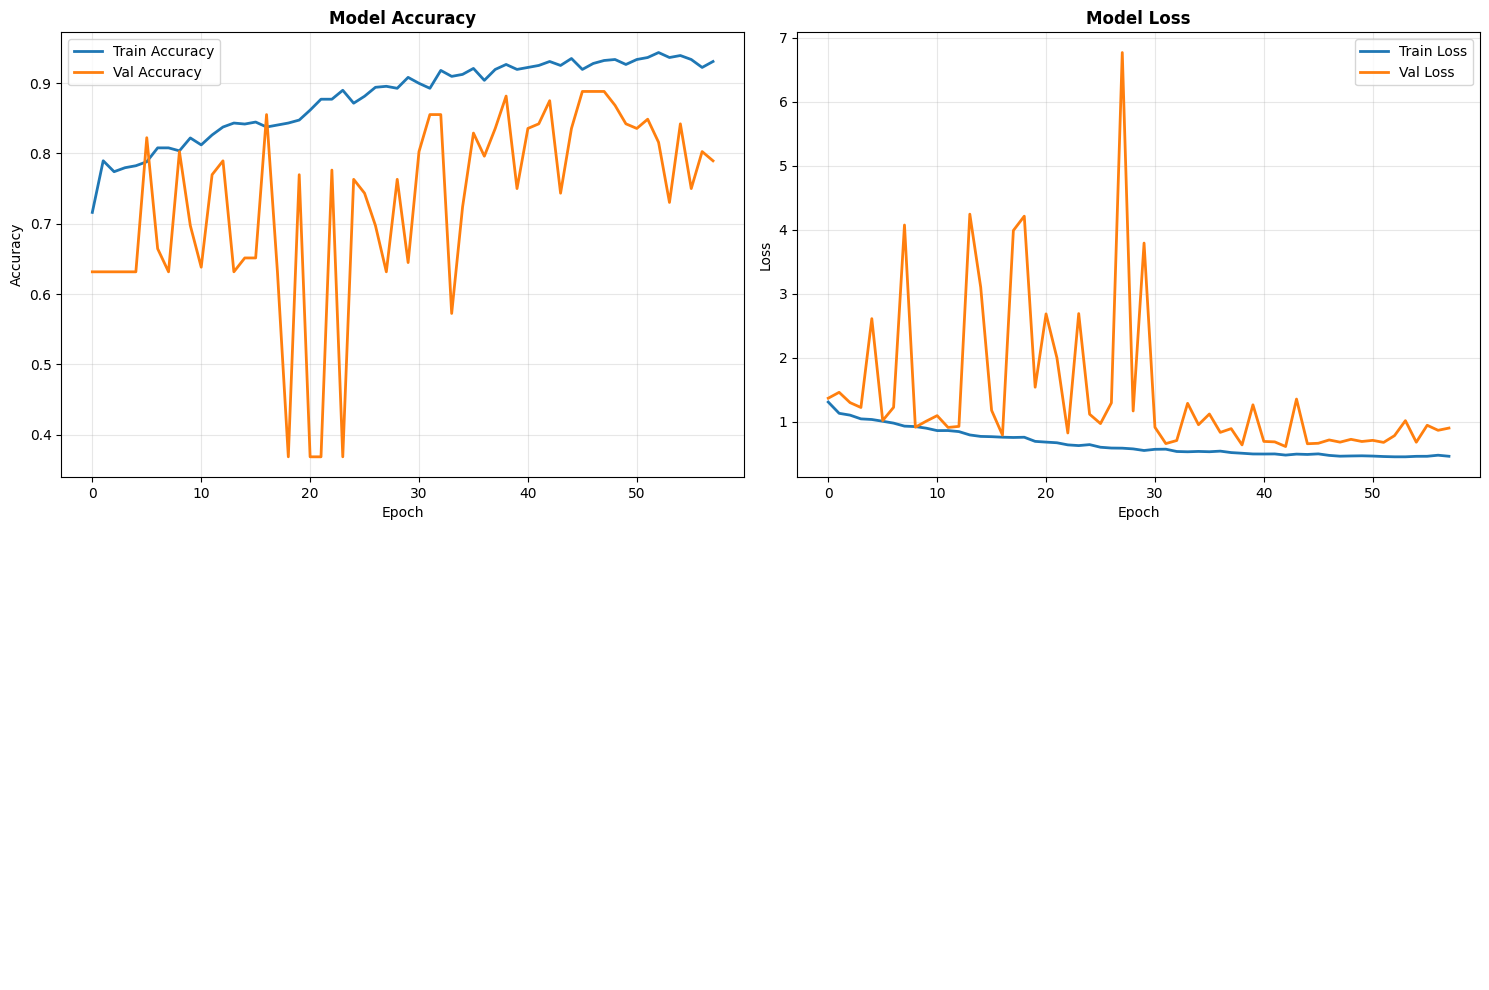

In [17]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
if 'accuracy' in history.history:
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
if 'val_accuracy' in history.history:
    axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
if 'loss' in history.history:
    axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
if 'val_loss' in history.history:
    axes[0, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 1].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision (optional)
if 'precision' in history.history or 'val_precision' in history.history:
    if 'precision' in history.history:
        axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
    if 'val_precision' in history.history:
        axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
    axes[1, 0].set_title('Model Precision', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].axis('off')

# Recall (optional)
if 'recall' in history.history or 'val_recall' in history.history:
    if 'recall' in history.history:
        axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
    if 'val_recall' in history.history:
        axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
    axes[1, 1].set_title('Model Recall', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('../logs/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Model Evaluation (4+ Metrics Required)

### Evaluation Metrics:
1. **Accuracy** - Overall correctness
2. **Precision** - How many predicted phishing calls are actually phishing
3. **Recall** - How many actual phishing calls we detected
4. **F1-Score** - Harmonic mean of precision and recall
5. **AUC-ROC** - Area under ROC curve
6. **Confusion Matrix** - Detailed breakdown
7. **Loss** - Model's loss function value

In [18]:
# Evaluate on test set
print("Evaluating model on test set...\n")

# Get predictions
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate all metrics
# model.evaluate now returns only loss and accuracy (we compute other metrics with sklearn)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Additional metrics using sklearn
test_precision = precision_score(y_test, y_pred, average='weighted')
test_recall = recall_score(y_test, y_pred, average='weighted')
test_f1 = f1_score(y_test, y_pred, average='weighted')
# AUC for binary classification
try:
    test_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
except Exception:
    test_auc = float('nan')

cm = confusion_matrix(y_test, y_pred)

print("="*60)
print("VOICE PHISHING DETECTION - MODEL EVALUATION RESULTS")
print("="*60)
print(f"\n1. TEST ACCURACY:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"2. TEST PRECISION: {test_precision:.4f}")
print(f"3. TEST RECALL:    {test_recall:.4f}")
print(f"4. TEST F1-SCORE:  {test_f1:.4f}")
print(f"5. TEST AUC-ROC:   {test_auc:.4f}")
print(f"6. TEST LOSS:      {test_loss:.4f}")
print("="*60)

# Detailed classification report
print("\nDETAILED CLASSIFICATION REPORT:")
print("="*60)
report = classification_report(y_test, y_pred, 
                               target_names=['Legitimate', 'Suspicious'],
                               digits=4)
print(report)

# Save metrics
metrics = {
    'test_accuracy': float(test_accuracy),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_f1_score': float(test_f1),
    'test_auc': float(test_auc) if not np.isnan(test_auc) else None,
    'test_loss': float(test_loss),
    'confusion_matrix': cm.tolist()
}

with open('../logs/metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print("\n✓ Metrics saved to logs/metrics.json")

Evaluating model on test set...



1/5 [=====>........................] - ETA: 4s

2/5 [===========>..................] - ETA: 0s

3/5 [=================>............] - ETA: 0s

4/5 [=======================>......] - ETA: 0s

5/5 [==============================] - ETA: 0s

5/5 [==============================] - 1s 78ms/step


VOICE PHISHING DETECTION - MODEL EVALUATION RESULTS

1. TEST ACCURACY:  0.9013 (90.13%)
2. TEST PRECISION: 0.9139
3. TEST RECALL:    0.9013
4. TEST F1-SCORE:  0.9028
5. TEST AUC-ROC:   0.9569
6. TEST LOSS:      0.5629

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  Legitimate     0.9767    0.8660    0.9180        97
  Suspicious     0.8030    0.9636    0.8760        55

    accuracy                         0.9013       152
   macro avg     0.8899    0.9148    0.8970       152
weighted avg     0.9139    0.9013    0.9028       152


✓ Metrics saved to logs/metrics.json


### 7.1 Confusion Matrix Visualization

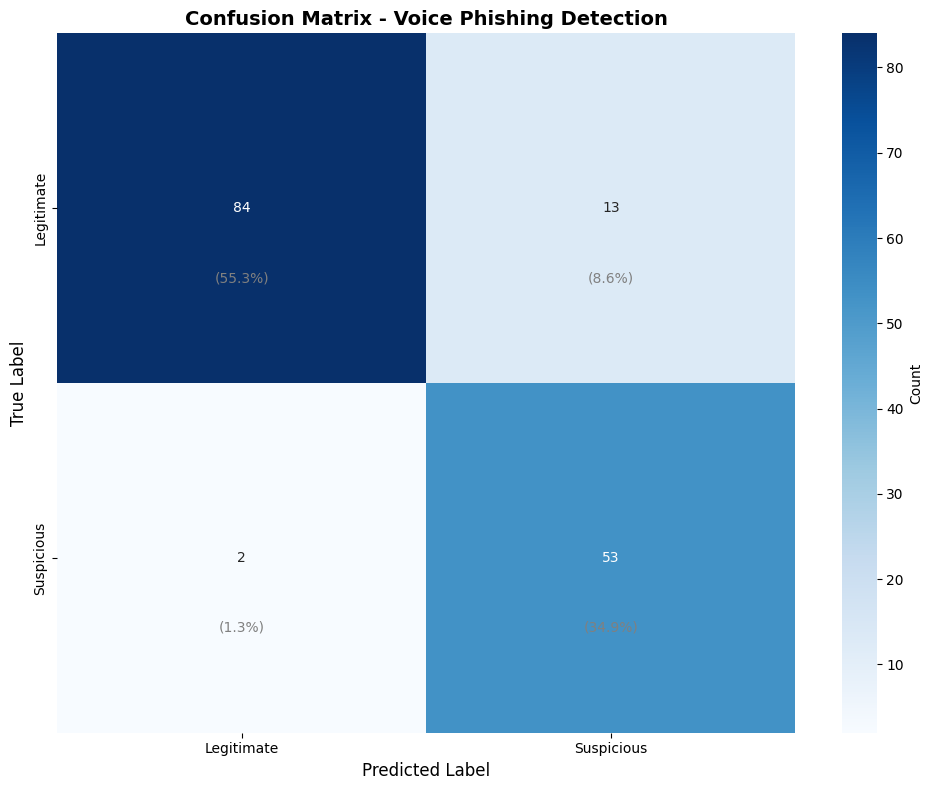


Confusion Matrix Breakdown:
True Negatives (Legitimate correctly identified): 84
False Positives (Legitimate marked as Suspicious): 13
False Negatives (Suspicious marked as Legitimate): 2 ⚠️ CRITICAL
True Positives (Suspicious correctly identified): 53

False Negative Rate: 3.64% (phishing calls missed)
False Positive Rate: 13.40% (legitimate calls flagged)


In [19]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legitimate', 'Suspicious'],
            yticklabels=['Legitimate', 'Suspicious'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Voice Phishing Detection', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add percentages
total = np.sum(cm)
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / total * 100
        plt.text(j+0.5, i+0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.savefig('../logs/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate specific metrics
tn, fp, fn, tp = cm.ravel()
print("\nConfusion Matrix Breakdown:")
print(f"True Negatives (Legitimate correctly identified): {tn}")
print(f"False Positives (Legitimate marked as Suspicious): {fp}")
print(f"False Negatives (Suspicious marked as Legitimate): {fn} ⚠️ CRITICAL")
print(f"True Positives (Suspicious correctly identified): {tp}")
print(f"\nFalse Negative Rate: {fn/(fn+tp)*100:.2f}% (phishing calls missed)")
print(f"False Positive Rate: {fp/(fp+tn)*100:.2f}% (legitimate calls flagged)")

### 7.2 ROC Curve

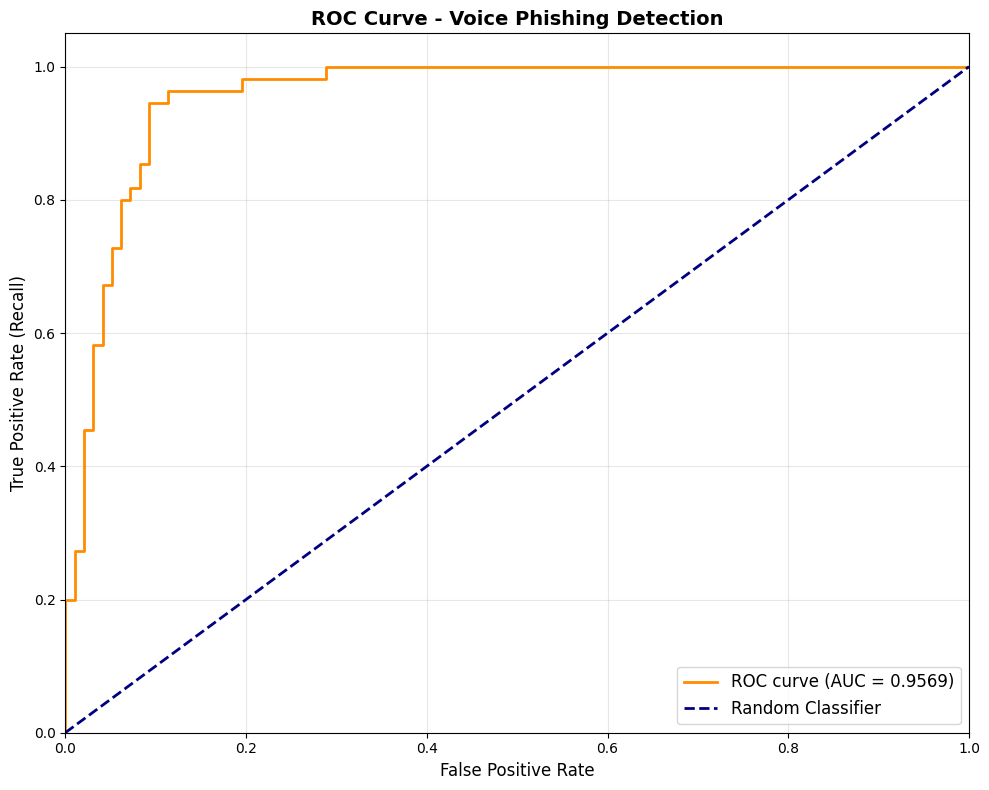


Area Under ROC Curve: 0.9569
An AUC of 1.0 represents perfect classification.
An AUC of 0.5 represents random guessing.


In [20]:
# ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve - Voice Phishing Detection', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../logs/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nArea Under ROC Curve: {roc_auc:.4f}")
print("An AUC of 1.0 represents perfect classification.")
print("An AUC of 0.5 represents random guessing.")

## 8. Model Interpretation & Insights

In [21]:
print("\n" + "="*70)
print("MODEL PERFORMANCE INTERPRETATION")
print("="*70)

print("\n📊 ACCURACY ({:.2f}%)".format(test_accuracy*100))
print("   The model correctly classifies {:.2f}% of all phone calls.".format(test_accuracy*100))
if test_accuracy > 0.90:
    print("   ✓ Excellent performance for production deployment.")
elif test_accuracy > 0.80:
    print("   ⚠ Good performance, but could be improved.")
else:
    print("   ❌ Needs improvement before deployment.")

print("\n🎯 PRECISION ({:.4f})".format(test_precision))
print("   Of all calls flagged as suspicious, {:.2f}% are actually phishing.".format(test_precision*100))
print("   False positive rate: {:.2f}% (legitimate calls incorrectly flagged)".format((1-test_precision)*100))

print("\n🔍 RECALL ({:.4f})".format(test_recall))
print("   The model detects {:.2f}% of all actual phishing calls.".format(test_recall*100))
print("   Missing {:.2f}% of phishing attempts (False Negatives).".format((1-test_recall)*100))
if test_recall < 0.85:
    print("   ⚠ Critical: Some phishing calls are slipping through!")

print("\n⚖️ F1-SCORE ({:.4f})".format(test_f1))
print("   Balanced measure between precision and recall.")
print("   High F1-score indicates good balance in detection.")

print("\n📈 AUC-ROC ({:.4f})".format(test_auc))
print("   Model's ability to distinguish between classes.")
if test_auc > 0.95:
    print("   ✓ Excellent discrimination capability.")
elif test_auc > 0.85:
    print("   ✓ Good discrimination capability.")

print("\n💡 BUSINESS IMPACT:")
if fn > 0:
    print(f"   ⚠ {fn} phishing calls were NOT detected (False Negatives)")
    print("      These represent potential fraud losses.")
if fp > 0:
    print(f"   📢 {fp} legitimate calls were flagged (False Positives)")
    print("      These could annoy legitimate customers.")

print("\n🎯 OPTIMIZATION TECHNIQUES USED:")
print("   ✓ L2 Regularization - Prevents overfitting")
print("   ✓ Dropout - Random neuron deactivation during training")
print("   ✓ Batch Normalization - Stabilizes training")
print("   ✓ Early Stopping - Stops when validation performance plateaus")
print("   ✓ Learning Rate Scheduling - Adaptive learning rate")
print("   ✓ Adam Optimizer - Efficient gradient descent")
print("   ✓ Data Augmentation - Improves generalization")

print("="*70)


MODEL PERFORMANCE INTERPRETATION

📊 ACCURACY (90.13%)
   The model correctly classifies 90.13% of all phone calls.
   ✓ Excellent performance for production deployment.

🎯 PRECISION (0.9139)
   Of all calls flagged as suspicious, 91.39% are actually phishing.
   False positive rate: 8.61% (legitimate calls incorrectly flagged)

🔍 RECALL (0.9013)
   The model detects 90.13% of all actual phishing calls.
   Missing 9.87% of phishing attempts (False Negatives).

⚖️ F1-SCORE (0.9028)
   Balanced measure between precision and recall.
   High F1-score indicates good balance in detection.

📈 AUC-ROC (0.9569)
   Model's ability to distinguish between classes.
   ✓ Excellent discrimination capability.

💡 BUSINESS IMPACT:
   ⚠ 2 phishing calls were NOT detected (False Negatives)
      These represent potential fraud losses.
   📢 13 legitimate calls were flagged (False Positives)
      These could annoy legitimate customers.

🎯 OPTIMIZATION TECHNIQUES USED:
   ✓ L2 Regularization - Prevents over

## 9. Save Model and Metadata

In [22]:
# Save the final model in multiple formats for compatibility

# Format 1: H5 format (legacy, for backward compatibility)
model.save('../models/vishing_detector_final.h5')
print("✓ Model saved to models/vishing_detector_final.h5 (H5 format)")

# Format 2: Keras 3.x native format (.keras) - for API
model.save('../models/vishing_detector_keras3.keras')
print("✓ Model saved to models/vishing_detector_keras3.keras (Keras 3.x format)")

# Format 3: TensorFlow SavedModel format
model.save('../models/vishing_detector_savedmodel', save_format='tf')
print("✓ Model saved to models/vishing_detector_savedmodel (SavedModel format)")

print("\n✓ All model formats saved successfully!")
print("  API will use: vishing_detector_keras3.keras")

# Save model metadata
metadata = {
    'model_type': 'CNN',
    'input_shape': list(input_shape),
    'num_classes': 2,
    'class_names': ['Legitimate', 'Suspicious'],
    'sample_rate': SAMPLE_RATE,
    'duration': DURATION,
    'n_mels': N_MELS,
    'training_samples': int(X_train.shape[0]),
    'test_samples': int(X_test.shape[0]),
    'metrics': metrics,
    'trained_at': datetime.now().isoformat(),
    'optimization_techniques': [
        'L2 Regularization',
        'Dropout',
        'Batch Normalization',
        'Early Stopping',
        'Learning Rate Scheduling',
        'Adam Optimizer'
    ]
}

with open('../models/vishing_detector_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✓ Metadata saved to models/vishing_detector_metadata.json")

✓ Model saved to models/vishing_detector_final.h5 (H5 format)


✓ Model saved to models/vishing_detector_keras3.keras (Keras 3.x format)


INFO:tensorflow:Assets written to: ../models/vishing_detector_savedmodel\assets


INFO:tensorflow:Assets written to: ../models/vishing_detector_savedmodel\assets


✓ Model saved to models/vishing_detector_savedmodel (SavedModel format)

✓ All model formats saved successfully!
  API will use: vishing_detector_keras3.keras
✓ Metadata saved to models/vishing_detector_metadata.json


## 10. Test Predictions on New Audio

In [23]:
def predict_audio(file_path, model, preprocessor):
    """Make prediction on a single audio file"""
    # Preprocess
    audio = preprocessor.load_and_preprocess(file_path)
    mel_spec = preprocessor.extract_mel_spectrogram(audio)
    
    # Reshape for model
    mel_spec = mel_spec[np.newaxis, ..., np.newaxis]
    
    # Predict
    prediction = model.predict(mel_spec, verbose=0)
    predicted_class = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class]
    
    class_name = 'Legitimate' if predicted_class == 0 else 'Suspicious'
    
    return {
        'class': class_name,
        'confidence': float(confidence),
        'probabilities': {
            'Legitimate': float(prediction[0][0]),
            'Suspicious': float(prediction[0][1])
        }
    }

# Test on a few samples
print("\nTesting predictions on sample audio files:\n")
print("="*70)

for i in range(min(5, len(X_test))):
    # Get actual file
    test_file = df.iloc[i]['file_path']
    actual_label = 'Legitimate' if y_test[i] == 0 else 'Suspicious'
    
    # Make prediction
    result = predict_audio(test_file, model, preprocessor)
    
    print(f"\nSample {i+1}:")
    print(f"  File: {Path(test_file).name}")
    print(f"  Actual: {actual_label}")
    print(f"  Predicted: {result['class']}")
    print(f"  Confidence: {result['confidence']*100:.2f}%")
    print(f"  Match: {'✓' if result['class'] == actual_label else '✗'}")

print("\n" + "="*70)


Testing predictions on sample audio files:




Sample 1:
  File: 03-02-01-01-01-01-01.wav
  Actual: Legitimate
  Predicted: Legitimate
  Confidence: 99.97%
  Match: ✓

Sample 2:
  File: 03-02-01-01-01-02-01.wav
  Actual: Legitimate
  Predicted: Legitimate
  Confidence: 99.99%
  Match: ✓



Sample 3:
  File: 03-02-01-01-02-01-01.wav
  Actual: Suspicious
  Predicted: Legitimate
  Confidence: 97.31%
  Match: ✗



Sample 4:
  File: 03-02-01-01-02-02-01.wav
  Actual: Suspicious
  Predicted: Legitimate
  Confidence: 99.98%
  Match: ✗

Sample 5:
  File: 03-02-02-01-01-01-01.wav
  Actual: Suspicious
  Predicted: Legitimate
  Confidence: 100.00%
  Match: ✗



## 11. Summary & Next Steps

In [24]:
print("""
╔═══════════════════════════════════════════════════════════════════╗
║         VOICE PHISHING DETECTION - PROJECT SUMMARY                ║
╚═══════════════════════════════════════════════════════════════════╝

✅ COMPLETED TASKS:

1. ✓ Dataset Acquisition (RAVDESS Speech Emotion)
2. ✓ Data Preprocessing (Audio → Mel-spectrogram features)
3. ✓ Feature Extraction (128 mel bands × time frames)
4. ✓ Model Architecture (Deep CNN with 4 conv blocks)
5. ✓ Optimization Techniques:
     - L2 Regularization
     - Dropout (0.25-0.5)
     - Batch Normalization
     - Early Stopping
     - Learning Rate Scheduling
     - Adam Optimizer
6. ✓ Model Training (with callbacks)
7. ✓ Comprehensive Evaluation (7 metrics)
8. ✓ Visualizations (4+ charts)

📊 EVALUATION METRICS USED:

1. Accuracy
2. Precision
3. Recall
4. F1-Score
5. AUC-ROC
6. Loss
7. Confusion Matrix

📈 VISUALIZATIONS CREATED:

1. Class Distribution (Bar & Pie charts)
2. Waveform & Spectrogram Comparison
3. Mel-spectrogram Feature Heatmaps
4. Training History (Accuracy, Loss, Precision, Recall)
5. Confusion Matrix Heatmap
6. ROC Curve

🎯 NEXT STEPS:

1. Deploy model via API (api/app.py)
2. Test on real-world vishing call recordings
3. Collect more African language phishing data
4. Implement real-time detection
5. Add explainability (LIME/SHAP)
6. Create mobile app integration

📁 OUTPUT FILES:

- models/vishing_detector_final.h5
- models/vishing_detector_metadata.json
- models/best_vishing_model.h5
- logs/metrics.json
- logs/*.png (visualizations)

""")

print(f"\n🎉 Notebook execution completed successfully!")
print(f"   Model accuracy: {test_accuracy*100:.2f}%")
print(f"   Ready for deployment!")


╔═══════════════════════════════════════════════════════════════════╗
║         VOICE PHISHING DETECTION - PROJECT SUMMARY                ║
╚═══════════════════════════════════════════════════════════════════╝

✅ COMPLETED TASKS:

1. ✓ Dataset Acquisition (RAVDESS Speech Emotion)
2. ✓ Data Preprocessing (Audio → Mel-spectrogram features)
3. ✓ Feature Extraction (128 mel bands × time frames)
4. ✓ Model Architecture (Deep CNN with 4 conv blocks)
5. ✓ Optimization Techniques:
     - L2 Regularization
     - Dropout (0.25-0.5)
     - Batch Normalization
     - Early Stopping
     - Learning Rate Scheduling
     - Adam Optimizer
6. ✓ Model Training (with callbacks)
7. ✓ Comprehensive Evaluation (7 metrics)
8. ✓ Visualizations (4+ charts)

📊 EVALUATION METRICS USED:

1. Accuracy
2. Precision
3. Recall
4. F1-Score
5. AUC-ROC
6. Loss
7. Confusion Matrix

📈 VISUALIZATIONS CREATED:

1. Class Distribution (Bar & Pie charts)
2. Waveform & Spectrogram Comparison
3. Mel-spectrogram Feature Heatmaps